
 # <center> Music-Learning</center>

<center>
Caliandro Pierciro (0299815)
    <br>
Falcone Gian Marco (0300251)
</center>

# Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [__1__](https://arxiv.org/abs/1612.01840).

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import librosa
from IPython.display import Audio
import scipy
from tinytag import TinyTag
from Dataset_Generator import calculate_metrics, get_features, retrieve_header, post_processing
import pandas as pd

import ast
import os
import cmath
import csv
import math
import json

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# utility imports from .py files
from plot_utils import basic_plot, bar_plot, three_group_bar_plot, print_cm
from dataset_utils import drop_complex_cols, get_top_genres, load, write_metrics_header, write_metrics, write_tuning_header, write_on_tuning_file 
from utils import write_cm_on_file, compute_class_metrics

We present two versions of the notebook, associated with the two binary value of  __VERSION__:
- 0: use the dataset from FMA repository
- 1: use our dataset, extracted by the mp3 archive of the FMA repository
<br><br>

There is also an __EXEC_PROFILE__ variable that is a dictonary which value will be used as an "operational profile": the keys refers to the fact that during the rur there will be the application of some feature selection/extraction or dataset resampling.
<br> 
This happens by chaning the default value (False) to 'True' for the desired key, keeping in mind that some keys are mutually exclusive (eg: Smote and oversampling, or PCA and feature selection).
<br>


In [9]:
VERSION = 1
EXEC_PROFILE = {"Plain": False, "PCA": False, "FS": False, "SMOTE": False, "OVERS": True}

legend_validation = ["Plain", "Oversampling", "Smote"]
legend_test = ["PCA", "Feature Selection"]

# Dataset generation


In [ ]:
file_name = 'raw_csv_file.csv'

# open the file in the write mode
f = open(file_name, 'w', newline='')

# create the csv writer
writer = csv.writer(f)

# write header to the csv file
header = retrieve_header()
writer.writerow(header)

# write data to the csv file
get_features(writer)

# close the file
f.close()

post_processing(file_name)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


## Data preprocessing
There is the need to do some preliminar operations on the data extracted by the .mp3 files:

1. First, there are some columns (the 'Fourier' related) that have complex numbers as values.
These values can't be treated by the ML models so are discared

2. The labels have to be encoded to be processed in the right way

In [5]:
# Open file, extract feature set and label set
if VERSION:
    path = "out.csv"
    dataframe = pd.read_csv(path)
    y = dataframe["genre"]
    dataframe = dataframe.drop(columns=["title", "artist", "filename", "album", "genre"])
    dataframe = dataframe.drop(columns=drop_complex_cols(dataframe))
    X = dataframe.drop(columns=["fourier_tempogram_std"])

    # Label encoding and extraction of uniques for later purposes
    le = LabelEncoder()
    y = le.fit_transform(y)
    labels = pd.Series(y).unique()
    
else:
    path = "dataset/fma_metadata/"
    tracks_file = "tracks.csv"
    features_file = "features.csv"
    ds_features = load(path+features_file)
    ds_tracks = load(path+tracks_file)
    medium = ds_tracks['set', 'subset'] <= 'medium'
    X = ds_features.loc[medium, 'mfcc'] # mel-frequency cepstral coeffcients: TODO add details 
    y = ds_tracks.loc[medium, ('track', 'genre_top')]
    labels = y.unique()

In [3]:
# load profiles from json file and store them as dicts
json_profiles = open("execution_profiles.json")
profiles = json.load(json_profiles)

plain = profiles["plain"]
smote = profiles["smote"]
overs = profiles["overs"]
plain_pca = profiles["pca_plain"]
overs_pca = profiles["pca_overs"]
smote_pca = profiles["pca_smote"]

## Feature manipulation
Feature manipulation is considered due to the fact that dataset is made of 105 feature.
<br>
The scope of this phase is to determine if it is possibile to reduce the dimensionality of the problem without losing any information.
<br>
Weather if feature manipulation is applyed or not (depending on the values of the `EXEC_PROFILE` dict), in the end dataset is split into train/validation/test sets.
<br>
The split proposed is, respectively, 80/10/10 as indicated in paper [__1__](https://arxiv.org/abs/1612.01840).
<br><br>
### Feature selection
Feature selection is applyed using Recursive feature elimination with cross-validation (`RFECV`) method.
<br>
The linear model used to determine the suited number of feature is `LassoCV`, with 5-fold cross validation.
<br><br>
### Principal Component Analysis
PCA is a technique of feature extraction, which is used to map the set of feature onto a space that has a minor dimension with respect to the original one.
<br>
This can be usefull to reduce computational time, without losing any information on the original set.

In [6]:
# check if feature selection is enabled for the current run
if EXEC_PROFILE["FS"]:
    print(X.shape)
    X_new = RFECV(LassoCV(tol=1e-1), step=1, cv=5).fit(X, y).transform(X)
    print(X_new.shape)
    
    # Split into train, validate, test
    X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_new, y, random_state=42, 
                                                                    test_size=0.10)
    X_train_fs, X_validate_fs, y_train_fs, y_validate_fs = train_test_split(X_train_fs, 
                                                                            y_train_fs, 
                                                                            random_state=42, 
                                                                            test_size=0.10)

# Split into train/validate/test sets for "plain" case
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                            random_state=42, test_size=0.10)

as shown by the data, the first value for PCA that ensures variance = 1 is 40 components, so that value has been chosen.

### Dataset resampling
Since the dataset obtained by the medium size mp3 folder is composed of ~ 16000 tracks, it could be usefull to increse the number of instances in train set, to evalute is this boosts a little classifier's performances.
<br>
To do so, both SMOTE and RandomOversampler methods can be applyed:
- SMOTE is a method that creates "synthetic" new instances starting from available data
- Oversampling is applyed on the least populated classes, adding instances to make these classes "easier" to predict.

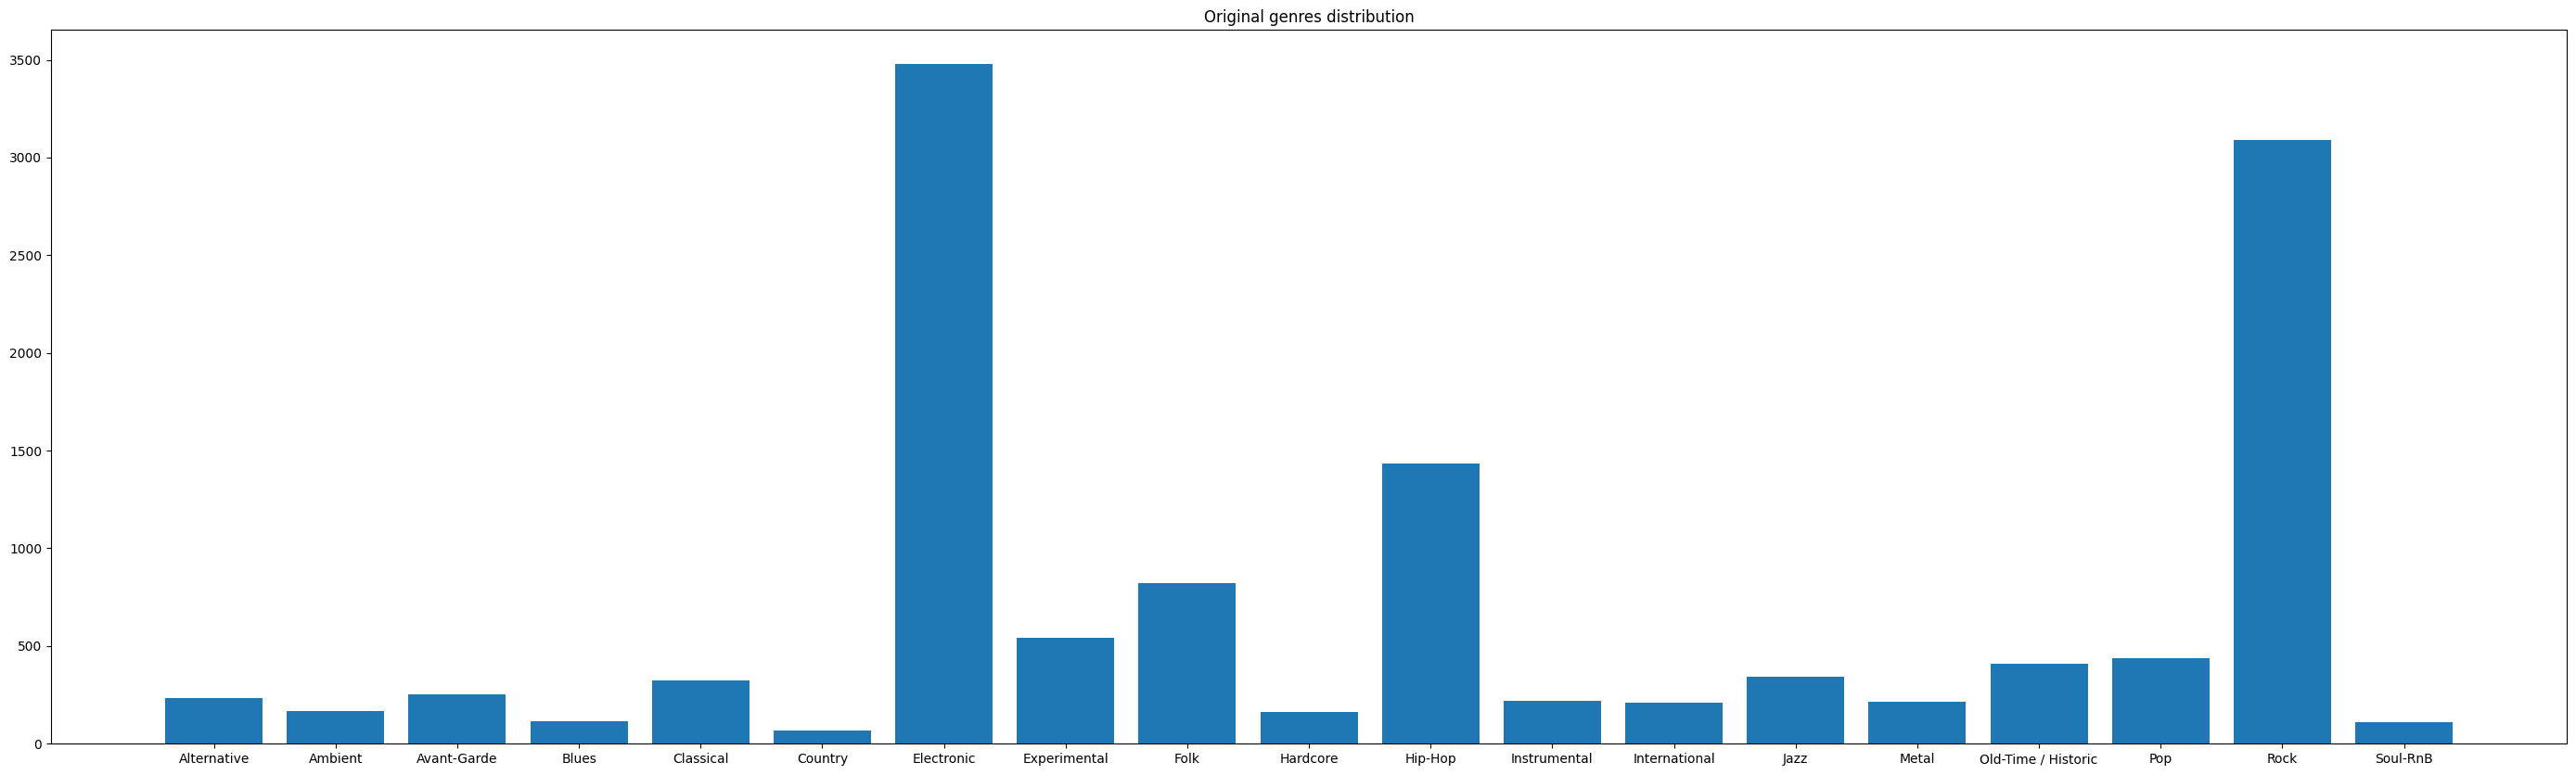

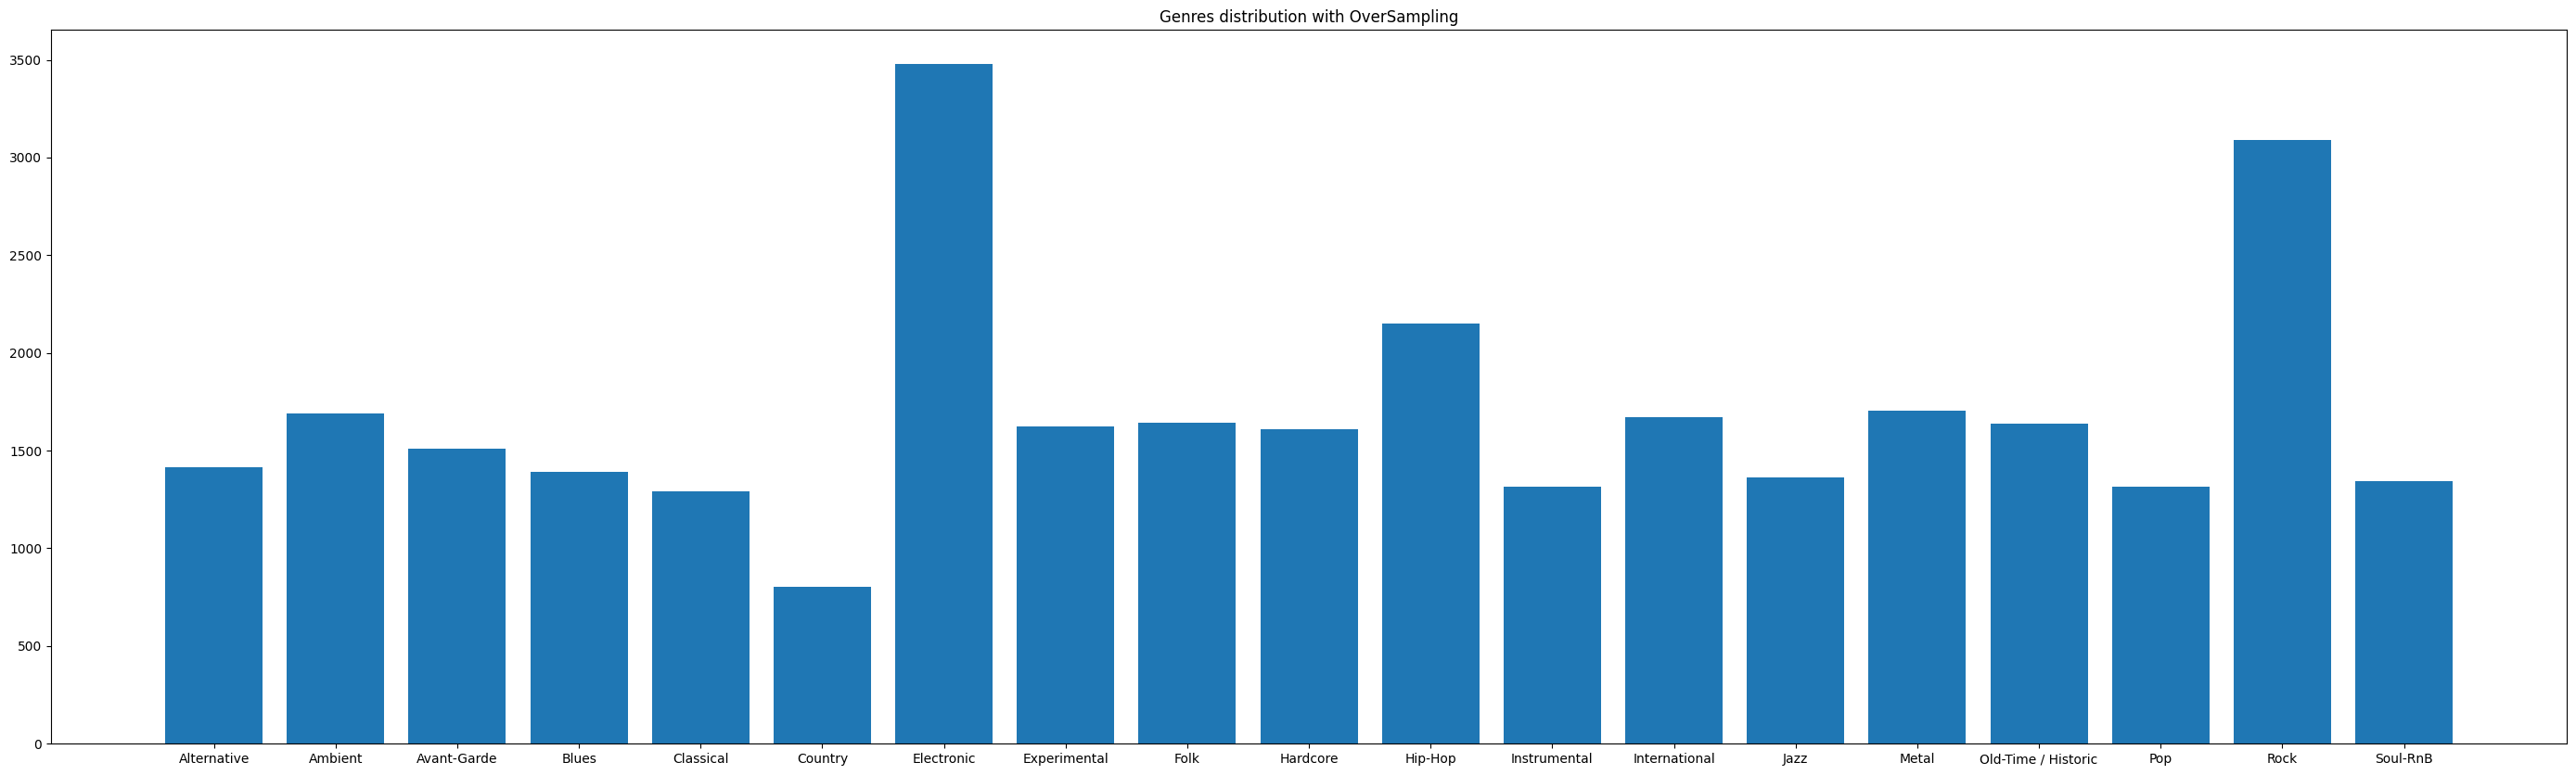

In [10]:
orig_labels = le.inverse_transform(labels)
orig_labels.sort()

# summarize distribution 
counter = Counter(y_train) 
strategy = {} 
for k,v in counter.items(): 
    strategy[k] = v
    
sorted_dict = dict(sorted(strategy.items()))
bar_plot((35,10), sorted_dict.values(), orig_labels, 'Original genres distribution')
     
if EXEC_PROFILE["OVERS"] or EXEC_PROFILE["SMOTE"]:
    # define oversampling strategy 
    max_class = max(strategy, key=strategy.get) 

    for k,v in strategy.items(): 
        if v < strategy[max_class]/24: 
            strategy[k] = v * 12 
        elif v < strategy[max_class]/20: 
            strategy[k] = v * 10
        elif v < strategy[max_class]/16: 
            strategy[k] = v * 8
        elif v < strategy[max_class]/12: 
            strategy[k] = v * 6
        elif v < strategy[max_class]/8: 
            strategy[k] = v * 4
        elif v < strategy[max_class]/6: 
            strategy[k] = math.ceil(v * 3) 
        elif v < strategy[max_class]/4: 
            strategy[k] = math.ceil(v * 2) 
        elif v < strategy[max_class]/2: 
            strategy[k] = math.ceil(v * 1.5) 
        
    # transform the dataset 
    if EXEC_PROFILE["SMOTE"]:
        oversample = SMOTE(sampling_strategy=strategy) 
        # fit and apply the transform 
        X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
        
    elif EXEC_PROFILE["OVERS"]:
        oversample = RandomOverSampler(sampling_strategy=strategy) 
        # fit and apply the transform 
        X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
    
    sorted_dict = dict(sorted(strategy.items()))
    bar_plot((35,10), sorted_dict.values(), orig_labels, 'Genres distribution with OverSampling')

# Model used
For this study, we used 5 different classifiers:

1. Support Vector Machines (SVM)
1. Logistic Regression     (LR)
1. k-Nearest Neighbours    (kNN)
1. Multi Layer Perceptron  (MLP)
1. Decision Tree           (DT)
<br>

For each of them, the first phase was the model selection, that was performed using
<br>
GridSearchCV to determine the best value for the classifier parameters, and even the number of components for PCA to use with that classifier.
<br>
After that, there is a phase of model validation: given the best parameters obtained by GridSearchCV, each classifier is run against a validation set, and some performance metrics are evaluated to define the suited one for this classification problem.
<br> In particular, the comparison on validation set is done considering 3 cases:
- the model without any manipulation of the feature set
- oversampling on train set
- SMOTE on train set
<br>

Last, the 'best' model is applyed on a test set, in this case the comparison is based also on the same model + PCA or feature selection.

## Model tuning

In [7]:
n_components_pca = [15, 30, 40, 60, 90]

## SVM tuning
The first classifier evaluated was SVM.
<br>
Based on the online literature, the suited kernel function seems to be 'rfb', so it was our choice to use it too.
We recall that the radial basis function (rbf) $K(\textbf{x}, \textbf{x'})$ has the following form:<br>
<center>$K(\textbf{x}, \textbf{x'}) = e^{-\frac{||\textbf{x} - \textbf{x'}||^2}{2\sigma^2}}$</center>
<br>
The SVC implementation offered by scikit uses, among the parameters, a $C$ that is used for regularization, with a squared l2 penality function.
<br><br>
So, for tuning, different values of C have been considered

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Construct a pipeline
scaler = StandardScaler()
pca = PCA()

if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
svc = SVC()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("svc", svc)])

kernels = ['rbf']
C_values = [1, 10, 25, 50, 100]
param_grid = { "pca__n_components": n_components_pca, 
              "svc__C": C_values,
              "svc__kernel": kernels
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

NameError: name 'n_components_pca' is not defined

## LR tuning
The second classifier used is Logistic Regression.
<br>
This classifier can use different solvers with different associated penalities
<br>
__TODO__: aggiungi 

In [ ]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
logistic = LogisticRegression()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

model_solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
penalties = ['l1', 'l2', 'none']
param_grid = { "pca__n_components": n_components_pca, 
              "logistic__solver": model_solvers,
              "logistic__penalty": penalties
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.

## kNN tuning
As third classifier we have k-Nearest-Neighbours.
<br>
This classifier works by considering the $k$ nearest points to a given $\textbf{x}$
<br>
__TODO__: aggiungi

In [9]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("knn", knn)])

n_neighbors = [1, 2, 3, 5, 10, 15, 20, 25, 50, 100]
param_grid = { "pca__n_components": n_components_pca,
              "knn__n_neighbors": n_neighbors
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)
    
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.838):
{'knn__n_neighbors': 1, 'pca__n_components': 90}


## MLP tuning
The fourth considered was Multi Layer Perceptron.
This class has different parameters that can be tuned:
1. hidden_layer_sizes, where the The ith element represents the number of neurons in the ith hidden layer
1. alpha: Strength of the L2 regularization term
<br>

__TODO__: aggiungi

In [ ]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
    
mlp = MLPClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("mlp", mlp)])


hlayers = [10, 20, 50, 75, 100, 150]
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
param_grid = { "pca__n_components": n_components_pca,
              "mlp__alpha": alphas,
              "mlp__hidden_layer_sizes": hlayers
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

## DT tuning
As fifth and last classifier, we used decision three. 
<br>

__TODO__: aggiungi

In [8]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)

dt = DecisionTreeClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("dt", dt)])


min_samples_leaf = [1, 5, 10, 25, 50, 75, 100]
min_samples_split = [2, 4, 8]
param_grid = { "pca__n_components": n_components_pca, 
              "dt__min_samples_leaf": min_samples_leaf,
              "dt__min_samples_split": min_samples_split
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.626):
{'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'pca__n_components': 90}


# Classifiers metrics and comparison
After tuning, next step is validation of the model obtained given the parameters and last is the evaultation of how classifiers are expected to behave on new data, namely on test set.
<br><br>
To do such evaluation, 4 different metrics for each classifier are computed and showed:
<br>
----------------------------------------------------------------------------
- Metric: &emsp;&emsp;&emsp;&emsp;&emsp; Expression
----------------------------------------------------------------------------
- Accuracy: &emsp;&emsp;&emsp; $\tfrac{TN + TP}{TP+FP+TN+FN}$
- Precision: &emsp;&emsp;&emsp;&emsp;&emsp; $\tfrac{TP}{TP + FP}$
- Recall: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\tfrac{TP}{TP + FN}$
- F1-score: &emsp;&emsp;&emsp;     $2 \cdot \tfrac{Precision \cdot Recall}{Precision + Recall}$
----------------------------------------------------------------------------

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
Note: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

## SVM classification

### SVM without tweaks

In [9]:
svm_clf = skl.svm.SVC(C=plain['SVM']['C_best'], kernel='rbf').fit(X_train, y_train)
svm_val_predict = cross_val_predict(svm_clf, X_validate, y_validate, cv=5)

svm_results = compute_class_metrics(predictions= le.inverse_transform(svm_val_predict), 
                                y_set= le.inverse_transform(y_validate), 
                                labels= le.inverse_transform(labels))

# vector structure: [report, precision, recall, f1-score]
svm_report = svm_results[0]
svm_precision = svm_results[1]
svm_recall = svm_results[2]
svm_f1 = svm_results[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### SVM with oversampling

In [ ]:
svm_clf_os = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf').fit(X_train_os, y_train_os)
svm_val_predict_os = cross_val_predict(svm_clf_os, X_validate, y_validate, cv=5)

svm_results_os = compute_class_metrics(predictions= le.inverse_transform(svm_val_predict_os), 
                                y_set= le.inverse_transform(y_validate), 
                                labels= le.inverse_transform(labels))

svm_report_os = svm_results_os[0]
svm_precision_os = svm_results_os[1]
svm_recall_os = svm_results_os[2]
svm_f1_os = svm_results_os[3]

### SVM with SMOTE

In [10]:
svm_clf_smote = skl.svm.SVC(C=smote['SVM']['C_best'], kernel='rbf').fit(X_train_smote, 
                                                                        y_train_smote)
svm_val_predict_smote = cross_val_predict(svm_clf_smote, X_validate, y_validate, cv=5)

svm_results_smote = compute_class_metrics(
    predictions= le.inverse_transform(svm_val_predict_smote), 
    y_set= le.inverse_transform(y_validate), 
    labels= le.inverse_transform(labels))

svm_report_smote = svm_results_smote[0]
svm_precision_smote = svm_results_smote[1]
svm_recall_smote = svm_results_smote[2]
svm_f1_smote = svm_results_smote[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### Metrics comparison for SVM

In [77]:
#print("------------------------------- Metrics without tweaks -------------------------------")
print(svm_report)

NameError: name 'svm_report' is not defined

In [56]:
print("------------------------------ Metrics with oversampling ------------------------------")
svm_report_os

------------------------------ Metrics with oversampling ------------------------------


{'Hip-Hop': {'precision': 0.544,
  'recall': 0.43037974683544306,
  'f1-score': 0.480565371024735,
  'support': 158},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 51},
 'Folk': {'precision': 0.35294117647058826,
  'recall': 0.37894736842105264,
  'f1-score': 0.36548223350253806,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.5196998123827392,
  'recall': 0.6977329974811083,
  'f1-score': 0.5956989247311828,
  'support': 397},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 29},
 'Rock': {'precision': 0.516728624535316,
  'recall': 0.7679558011049724,
  'f1-score': 0.6177777777777779,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13},
 'International': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 21},
 'B

In [15]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
svm_report_smote

-------------------------------- Metrics with SMOTE --------------------------------


{'Hip-Hop': {'precision': 0.5317460317460317,
  'recall': 0.4240506329113924,
  'f1-score': 0.471830985915493,
  'support': 158},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 51},
 'Folk': {'precision': 0.32323232323232326,
  'recall': 0.3368421052631579,
  'f1-score': 0.3298969072164949,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.5157699443413729,
  'recall': 0.7002518891687658,
  'f1-score': 0.594017094017094,
  'support': 397},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 29},
 'Rock': {'precision': 0.5092250922509225,
  'recall': 0.7624309392265194,
  'f1-score': 0.6106194690265486,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13},
 'International': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support'

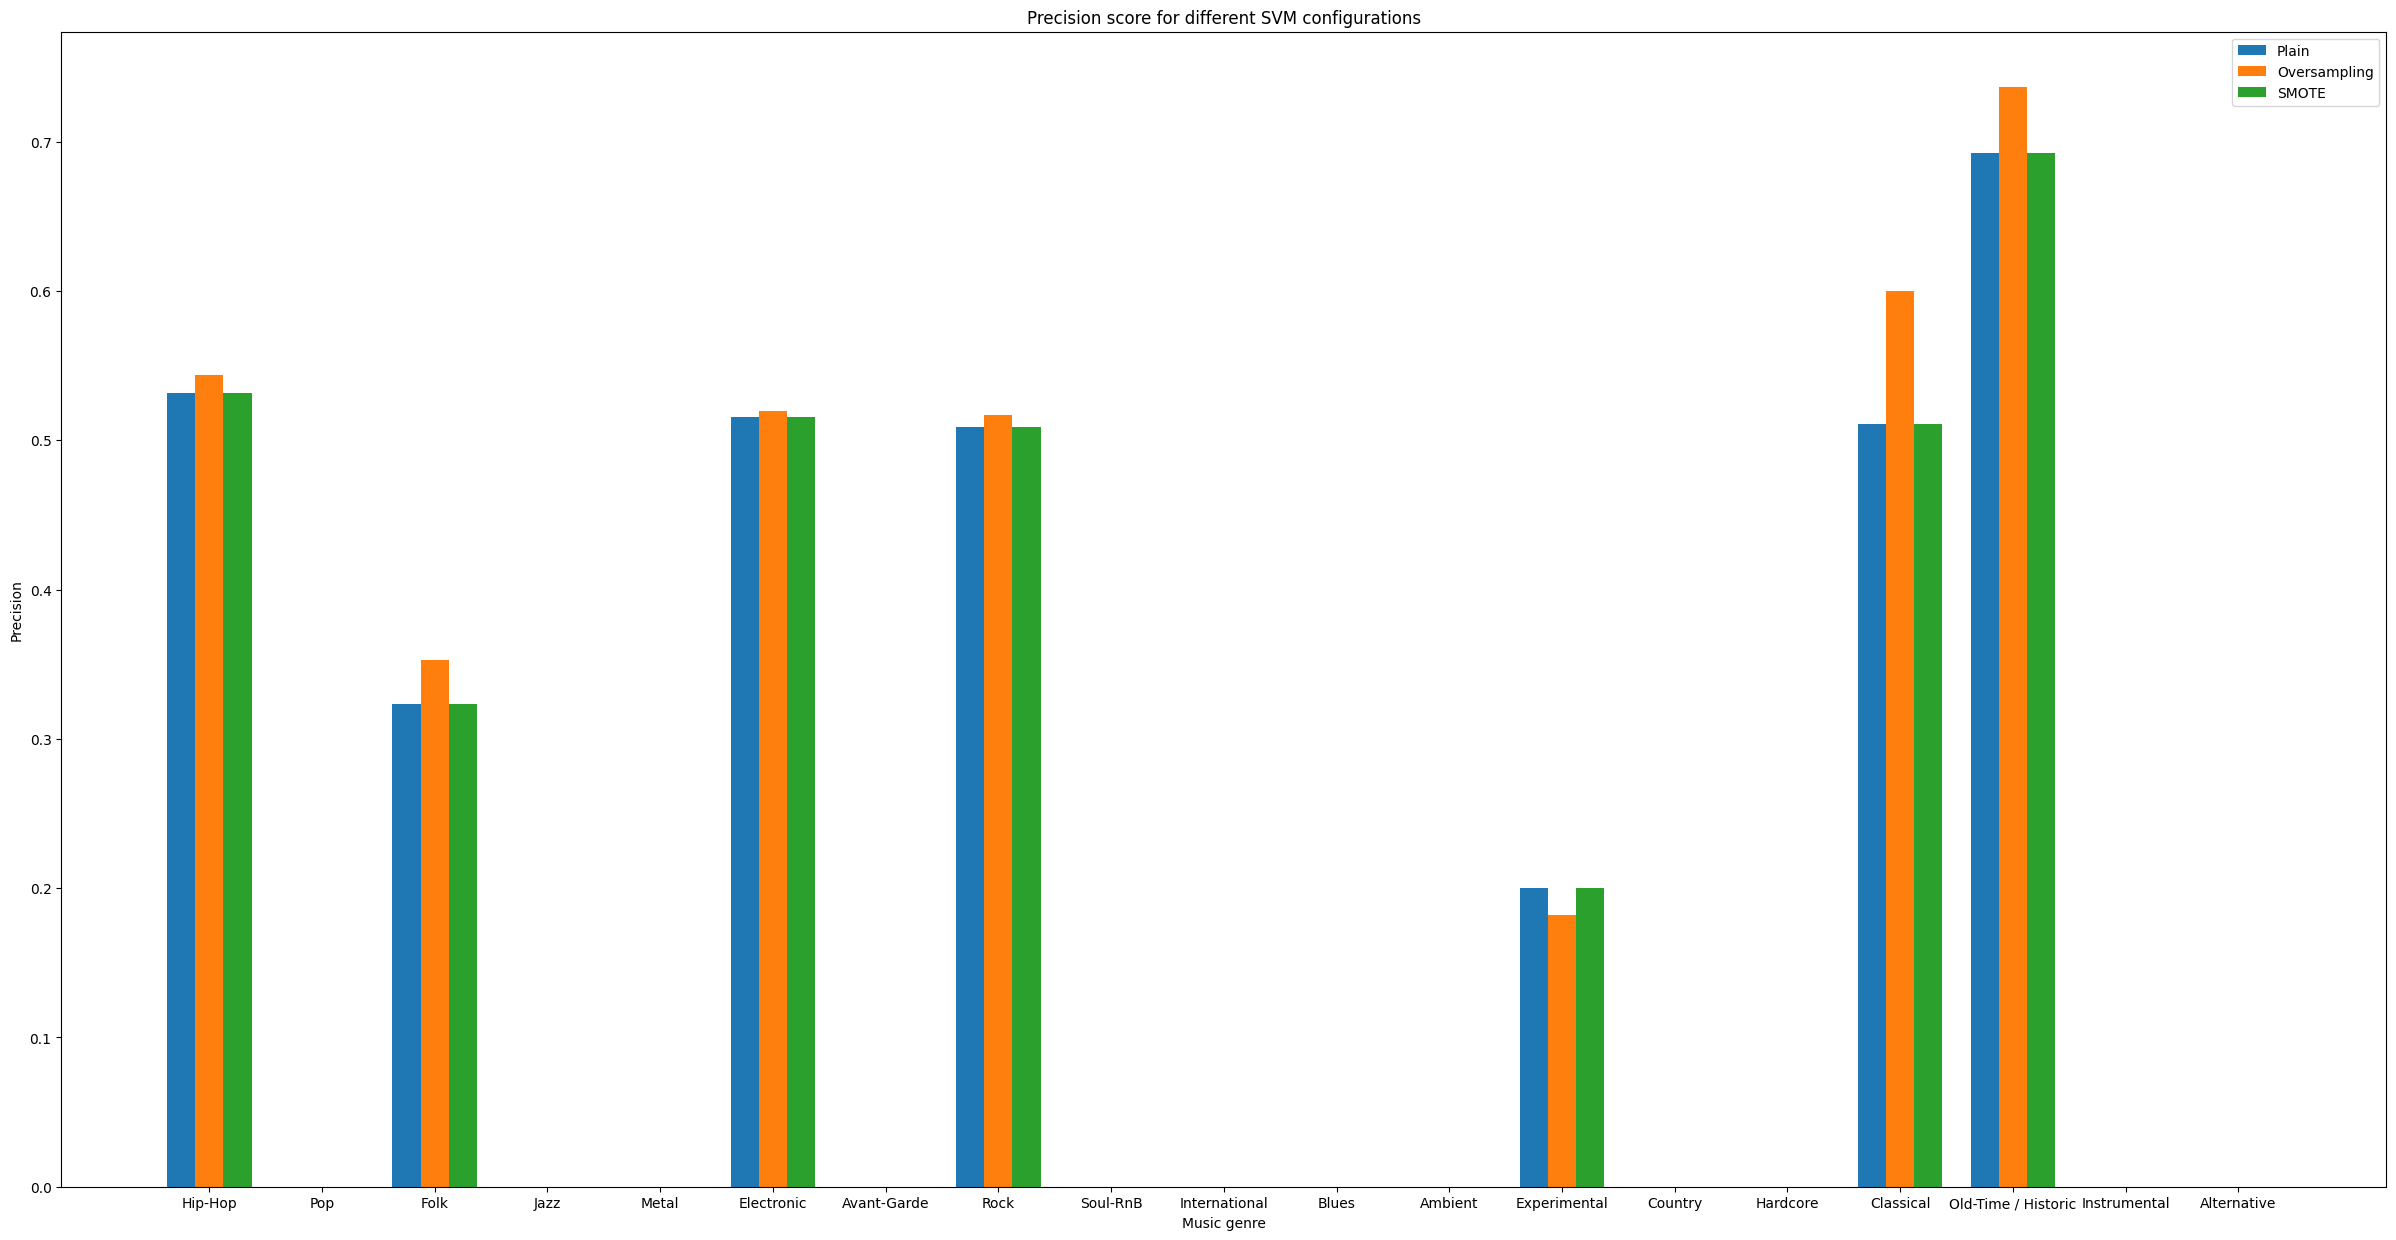

In [58]:
three_group_bar_plot(svm_precision, svm_precision_os, svm_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different SVM configurations", "Music genre", 
                    "Precision", legend_validation)

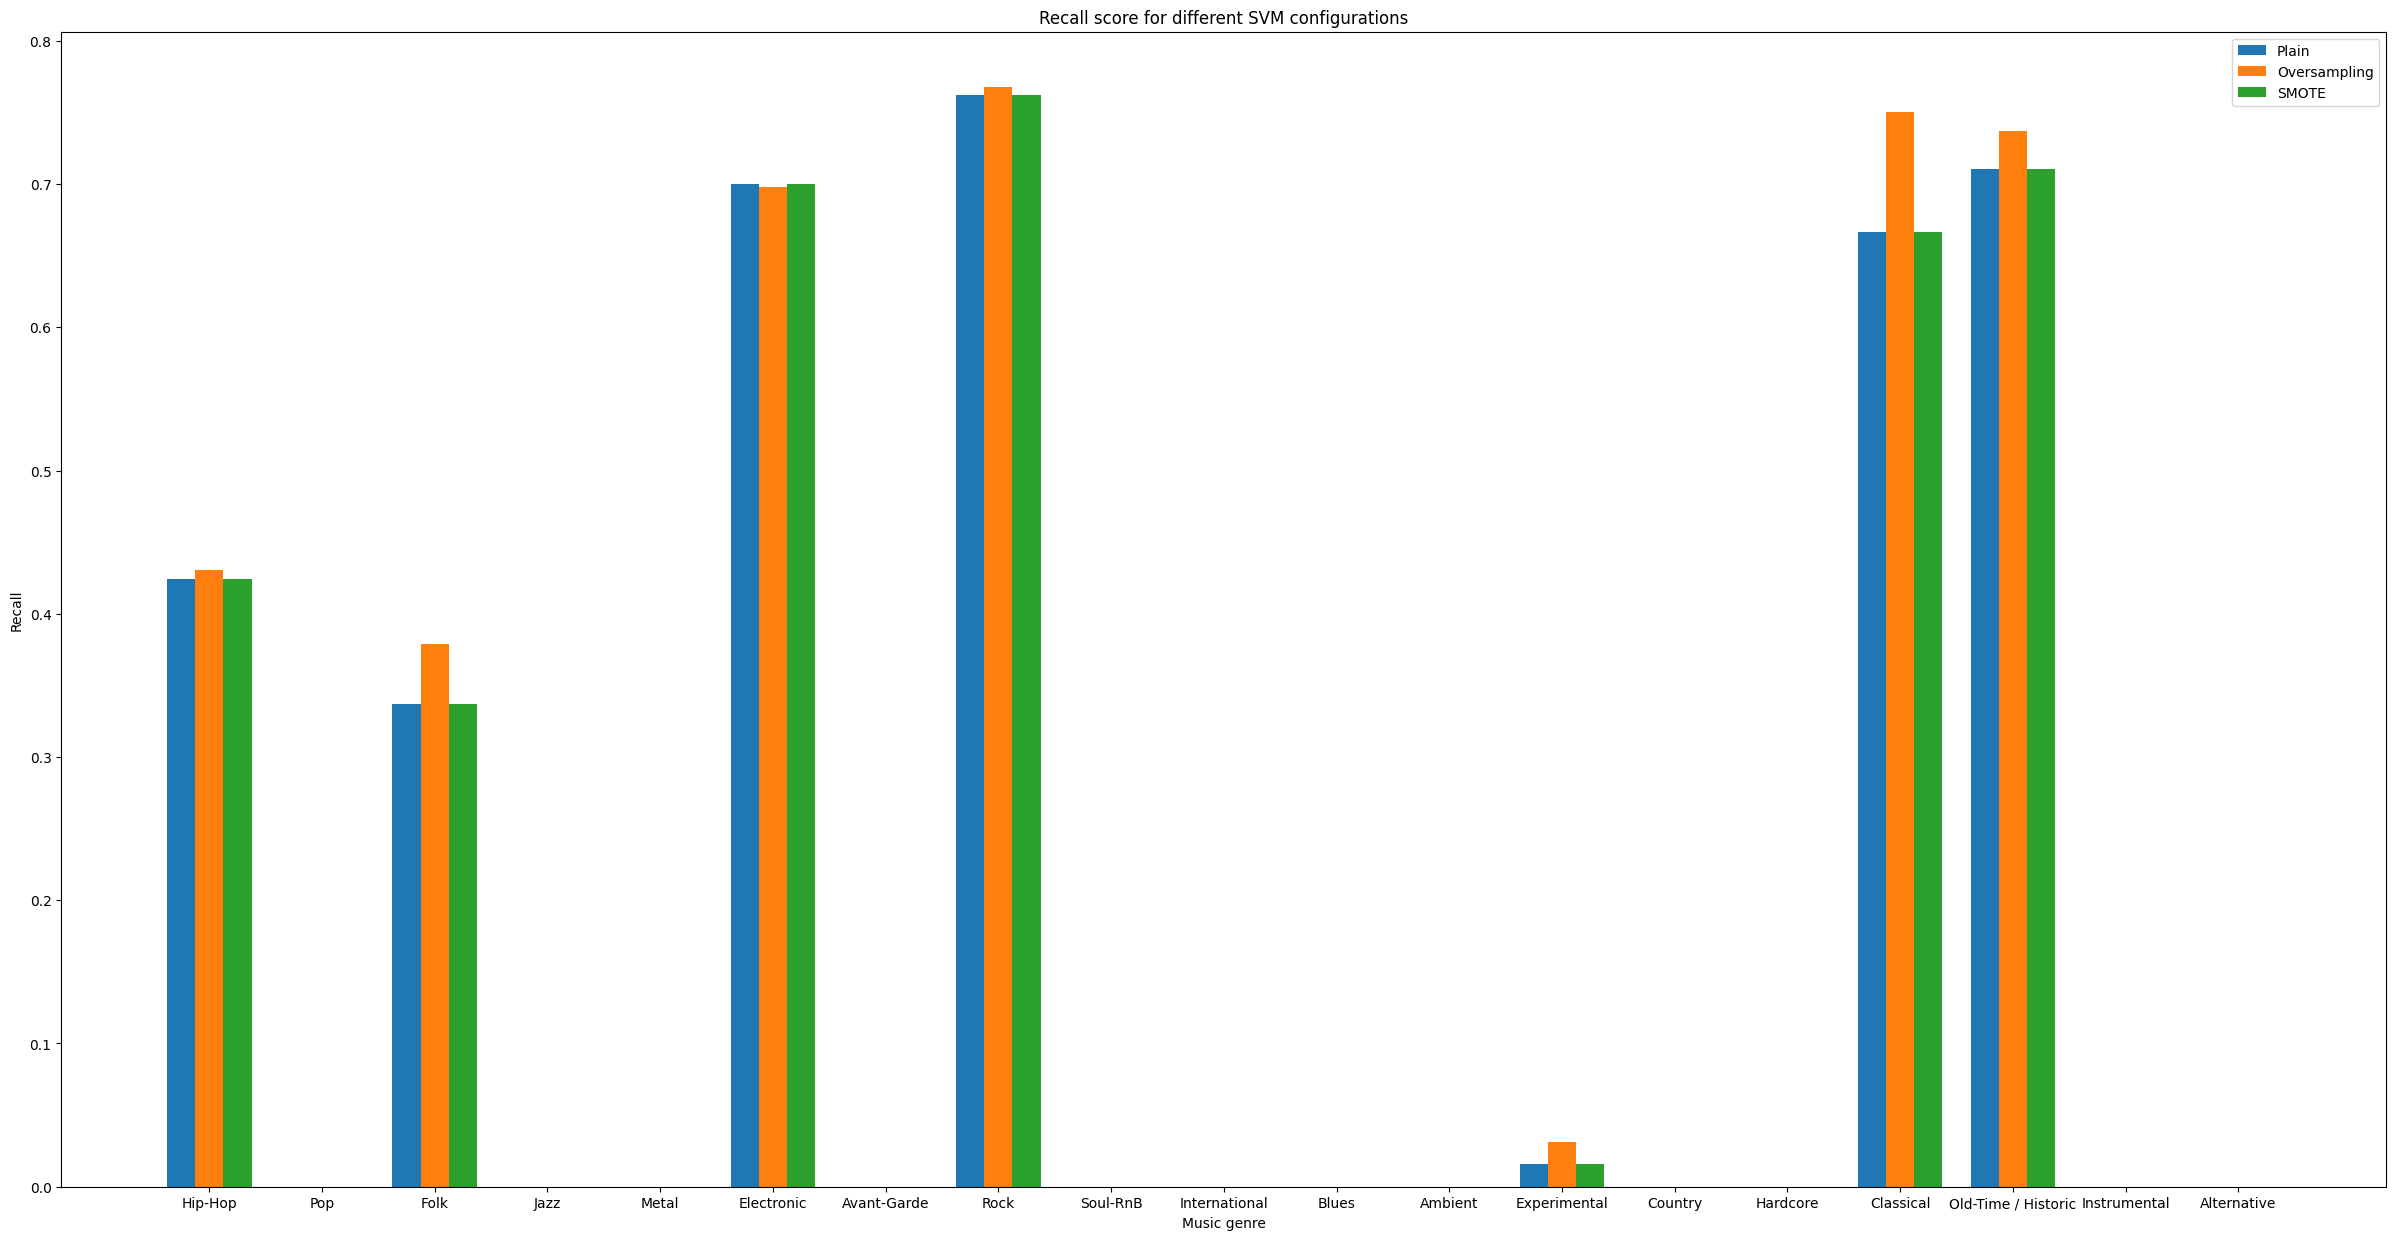

In [59]:
three_group_bar_plot(svm_recall, svm_recall_os, svm_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different SVM configurations", "Music genre", 
                    "Recall", legend_validation)

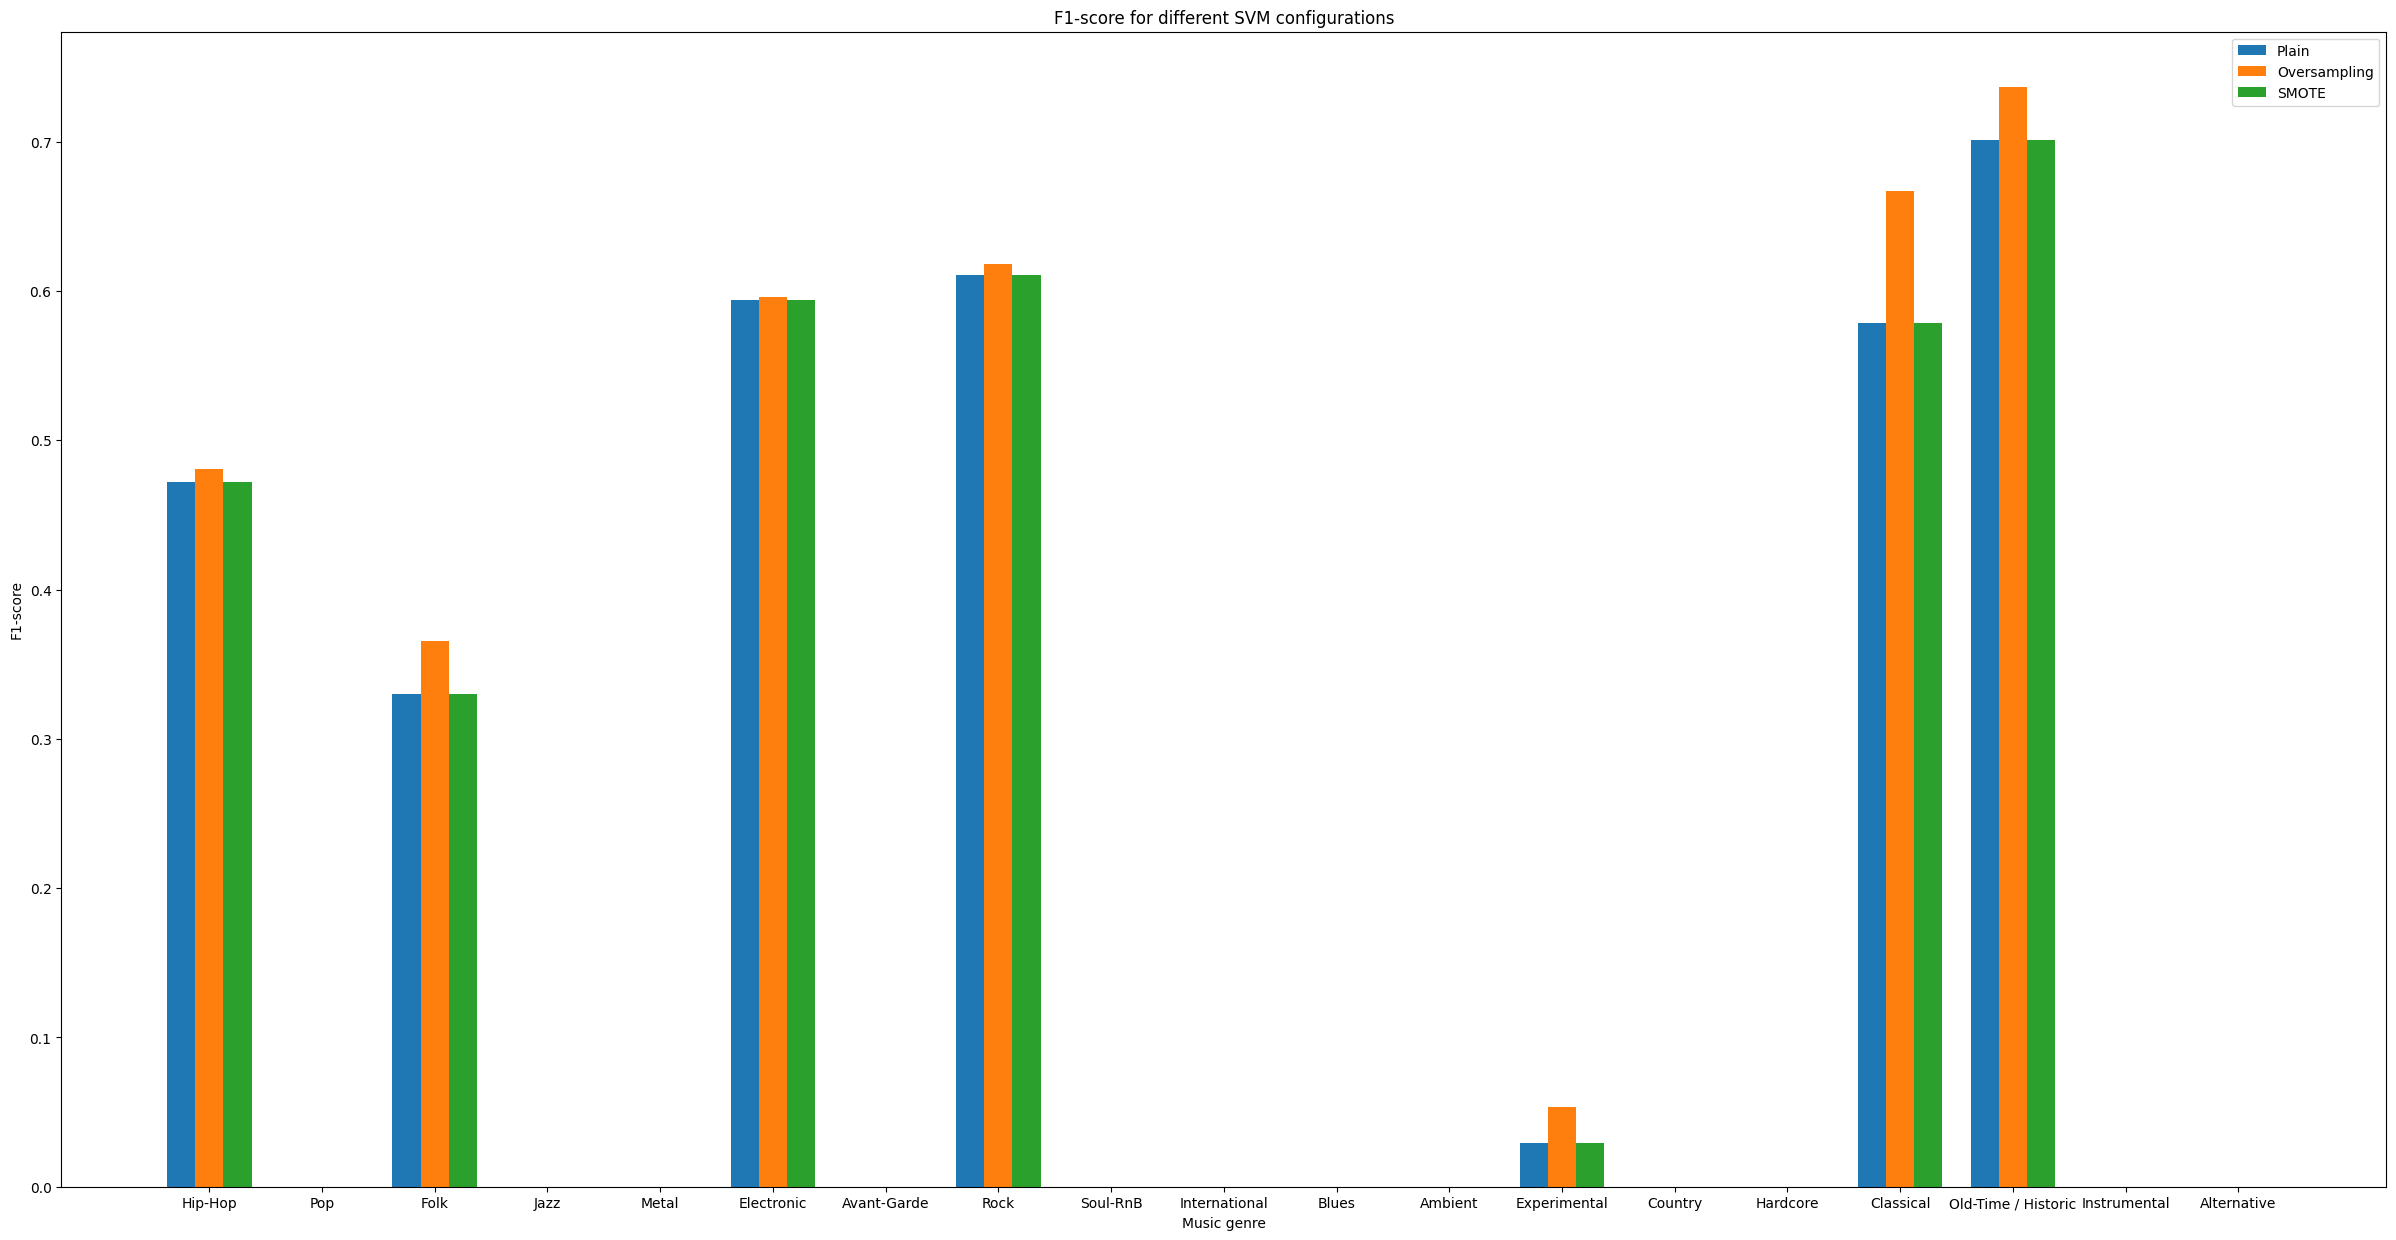

In [43]:
three_group_bar_plot(svm_f1, svm_f1_os, svm_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different SVM configurations", "Music genre", 
                    "F1-score", legend_validation)

### SVM on test set
Best case plain: OverSampling

In [12]:
orig_labels = le.inverse_transform(labels)
svm_clf = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf').fit(X_train_os, y_train_os)
svm_test_preds = svm_clf.predict(X_test)

svm_results_test = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds), 
        y_set=le.inverse_transform(y_test), 
        labels= orig_labels
)
svm_report_test = svm_results_test[0]
svm_precision_test = svm_results_test[1]
svm_recall_test = svm_results_test[2]
svm_f1_test = svm_results_test[3]
svm_cm_test = confusion_matrix(y_test, svm_test_preds, labels=labels)

In [11]:
orig_labels = le.inverse_transform(labels)
pca = PCA(n_components=overs_pca['SVM']['n_components'])
X_train_pca = pca.fit_transform(X_train_os, y_train_os)
X_test_pca = pca.transform(X_test)

svm_clf = skl.svm.SVC(C=overs_pca['SVM']['C'], kernel='rbf').fit(X_train_pca, y_train_os)
svm_test_preds_pca = svm_clf.predict(X_test_pca)

svm_results_test_pca = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds_pca), 
        y_set=le.inverse_transform(y_test), 
        labels= orig_labels
)

svm_report_test_pca = svm_results_test_pca[0]
svm_precision_test_pca = svm_results_test_pca[1]
svm_recall_test_pca = svm_results_test_pca[2]
svm_f1_test_pca = svm_results_test_pca[3]

In [16]:
svm_clf = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf').fit(X_train_fs, y_train_fs)
svm_test_preds_fs = svm_clf.predict(X_test_fs)

svm_results_test_fs = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds_fs), 
        y_set=le.inverse_transform(y_test_fs), 
        labels= orig_labels
)

svm_report_test_fs = svm_results_test_fs[0]
svm_precision_test_fs = svm_results_test_fs[1]
svm_recall_test_fs = svm_results_test_fs[2]
svm_f1_test_fs = svm_results_test_fs[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

In [13]:
svm_report_test

,precision,recall,f1-score,support
Hip-Hop,0.623529,0.619883,0.621701,171
Pop,0.333333,0.031746,0.057971,63
Folk,0.505051,0.431034,0.465116,116
Jazz,0.181818,0.045455,0.072727,44
Metal,0.186441,0.305556,0.231579,36
Electronic,0.604369,0.576389,0.590047,432
Avant-Garde,0.044444,0.083333,0.057971,24
Rock,0.566197,0.566197,0.566197,355
Soul-RnB,0.076923,0.090909,0.083333,11
International,0.185714,0.419355,0.257426,31


In [18]:
svm_report_test_pca

{'Hip-Hop': {'precision': 0.6280487804878049,
  'recall': 0.6023391812865497,
  'f1-score': 0.6149253731343283,
  'support': 171},
 'Pop': {'precision': 0.1,
  'recall': 0.031746031746031744,
  'f1-score': 0.048192771084337345,
  'support': 63},
 'Folk': {'precision': 0.4818181818181818,
  'recall': 0.45689655172413796,
  'f1-score': 0.4690265486725664,
  'support': 116},
 'Jazz': {'precision': 0.3076923076923077,
  'recall': 0.2727272727272727,
  'f1-score': 0.2891566265060241,
  'support': 44},
 'Metal': {'precision': 0.21818181818181817,
  'recall': 0.3333333333333333,
  'f1-score': 0.26373626373626374,
  'support': 36},
 'Electronic': {'precision': 0.6299019607843137,
  'recall': 0.5949074074074074,
  'f1-score': 0.611904761904762,
  'support': 432},
 'Avant-Garde': {'precision': 0.024390243902439025,
  'recall': 0.041666666666666664,
  'f1-score': 0.030769230769230767,
  'support': 24},
 'Rock': {'precision': 0.5784615384615385,
  'recall': 0.5295774647887324,
  'f1-score': 0.5529

In [19]:
svm_report_test_fs

{'Hip-Hop': {'precision': 0.6041666666666666,
  'recall': 0.5087719298245614,
  'f1-score': 0.5523809523809524,
  'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.5465116279069767,
  'recall': 0.4051724137931034,
  'f1-score': 0.4653465346534653,
  'support': 116},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36},
 'Electronic': {'precision': 0.5263157894736842,
  'recall': 0.7638888888888888,
  'f1-score': 0.623229461756374,
  'support': 432},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 24},
 'Rock': {'precision': 0.4983108108108108,
  'recall': 0.8309859154929577,
  'f1-score': 0.6230200633579726,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support

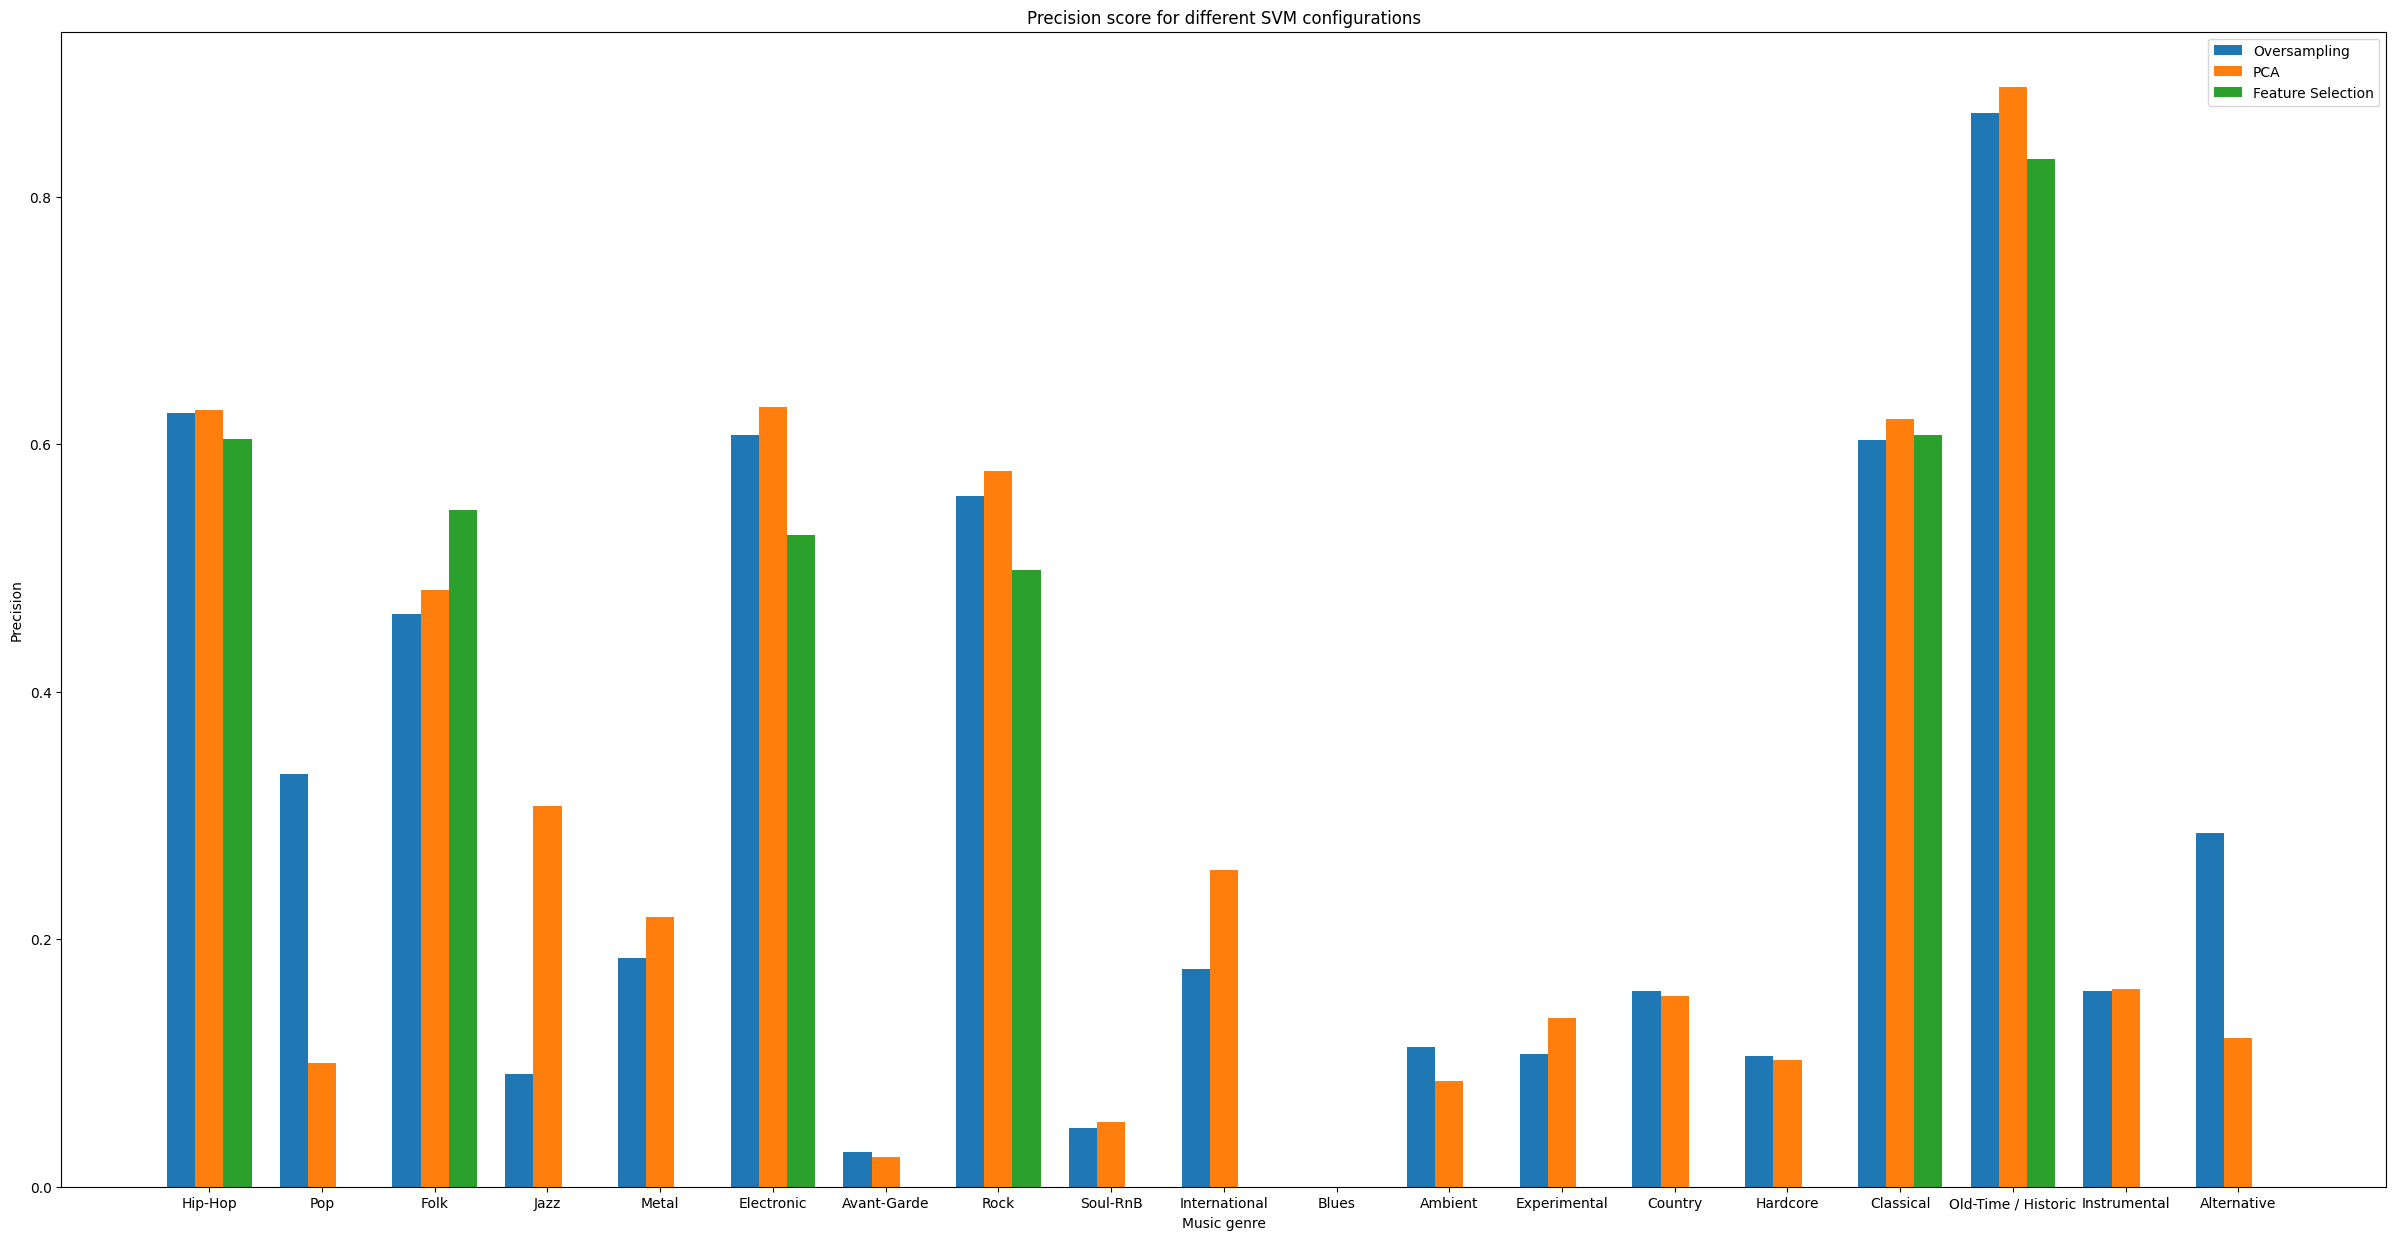

In [20]:
three_group_bar_plot(svm_precision_test, svm_precision_test_pca, svm_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different SVM configurations", "Music genre", 
                    "Precision", ["Oversampling"]+legend_test)

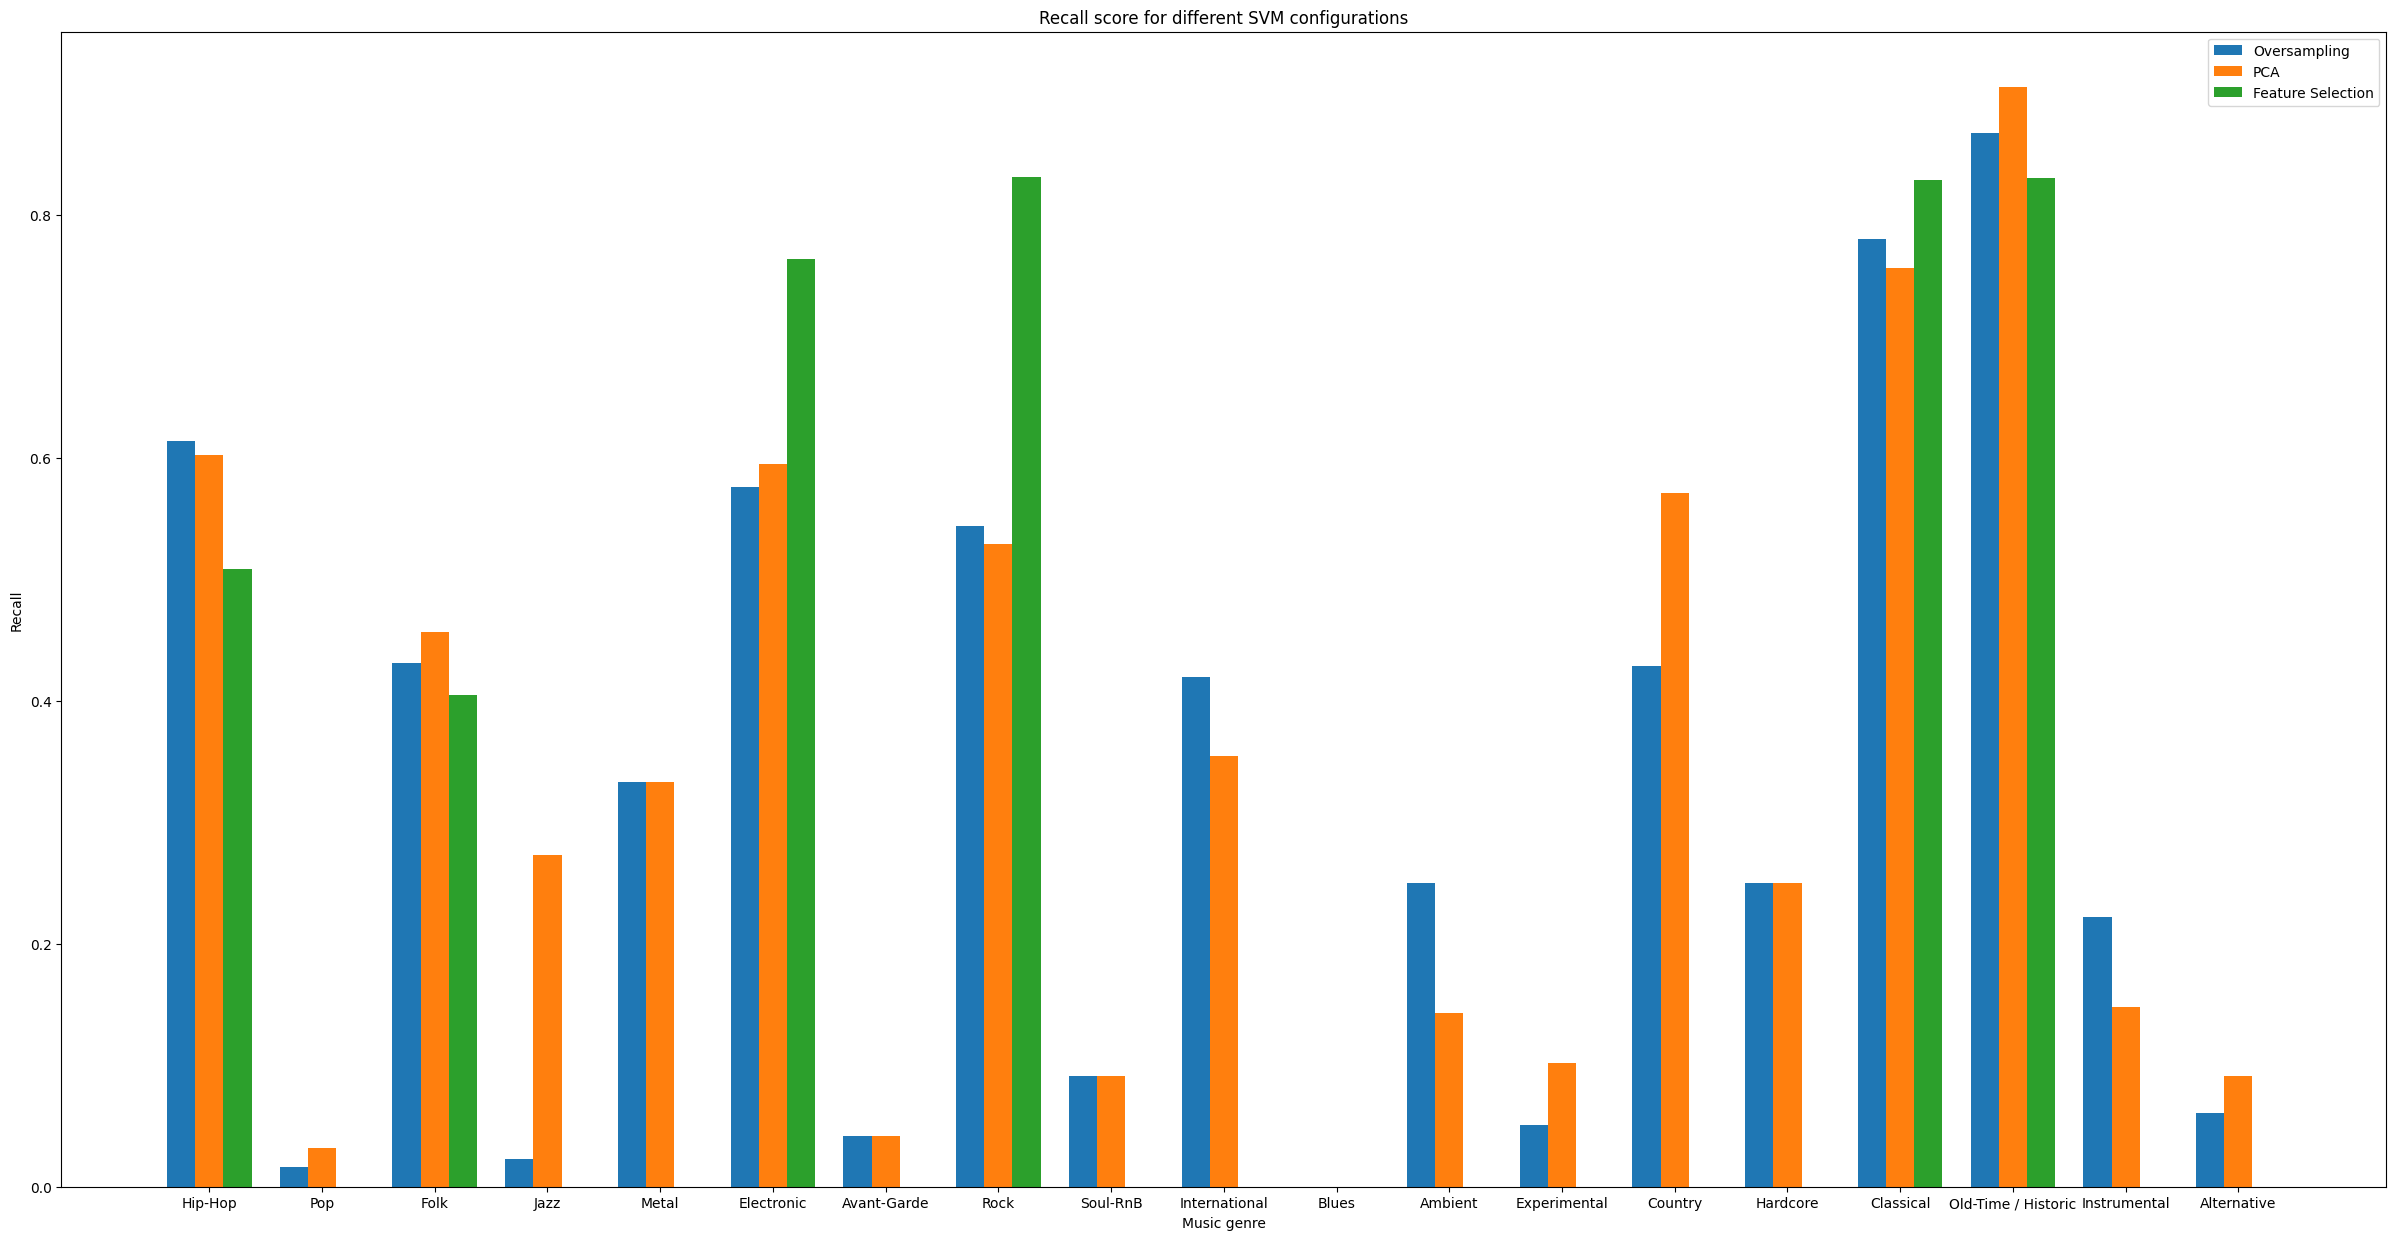

In [21]:
three_group_bar_plot(svm_recall_test, svm_recall_test_pca, svm_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different SVM configurations", "Music genre", 
                    "Recall", ["Oversampling"]+legend_test)

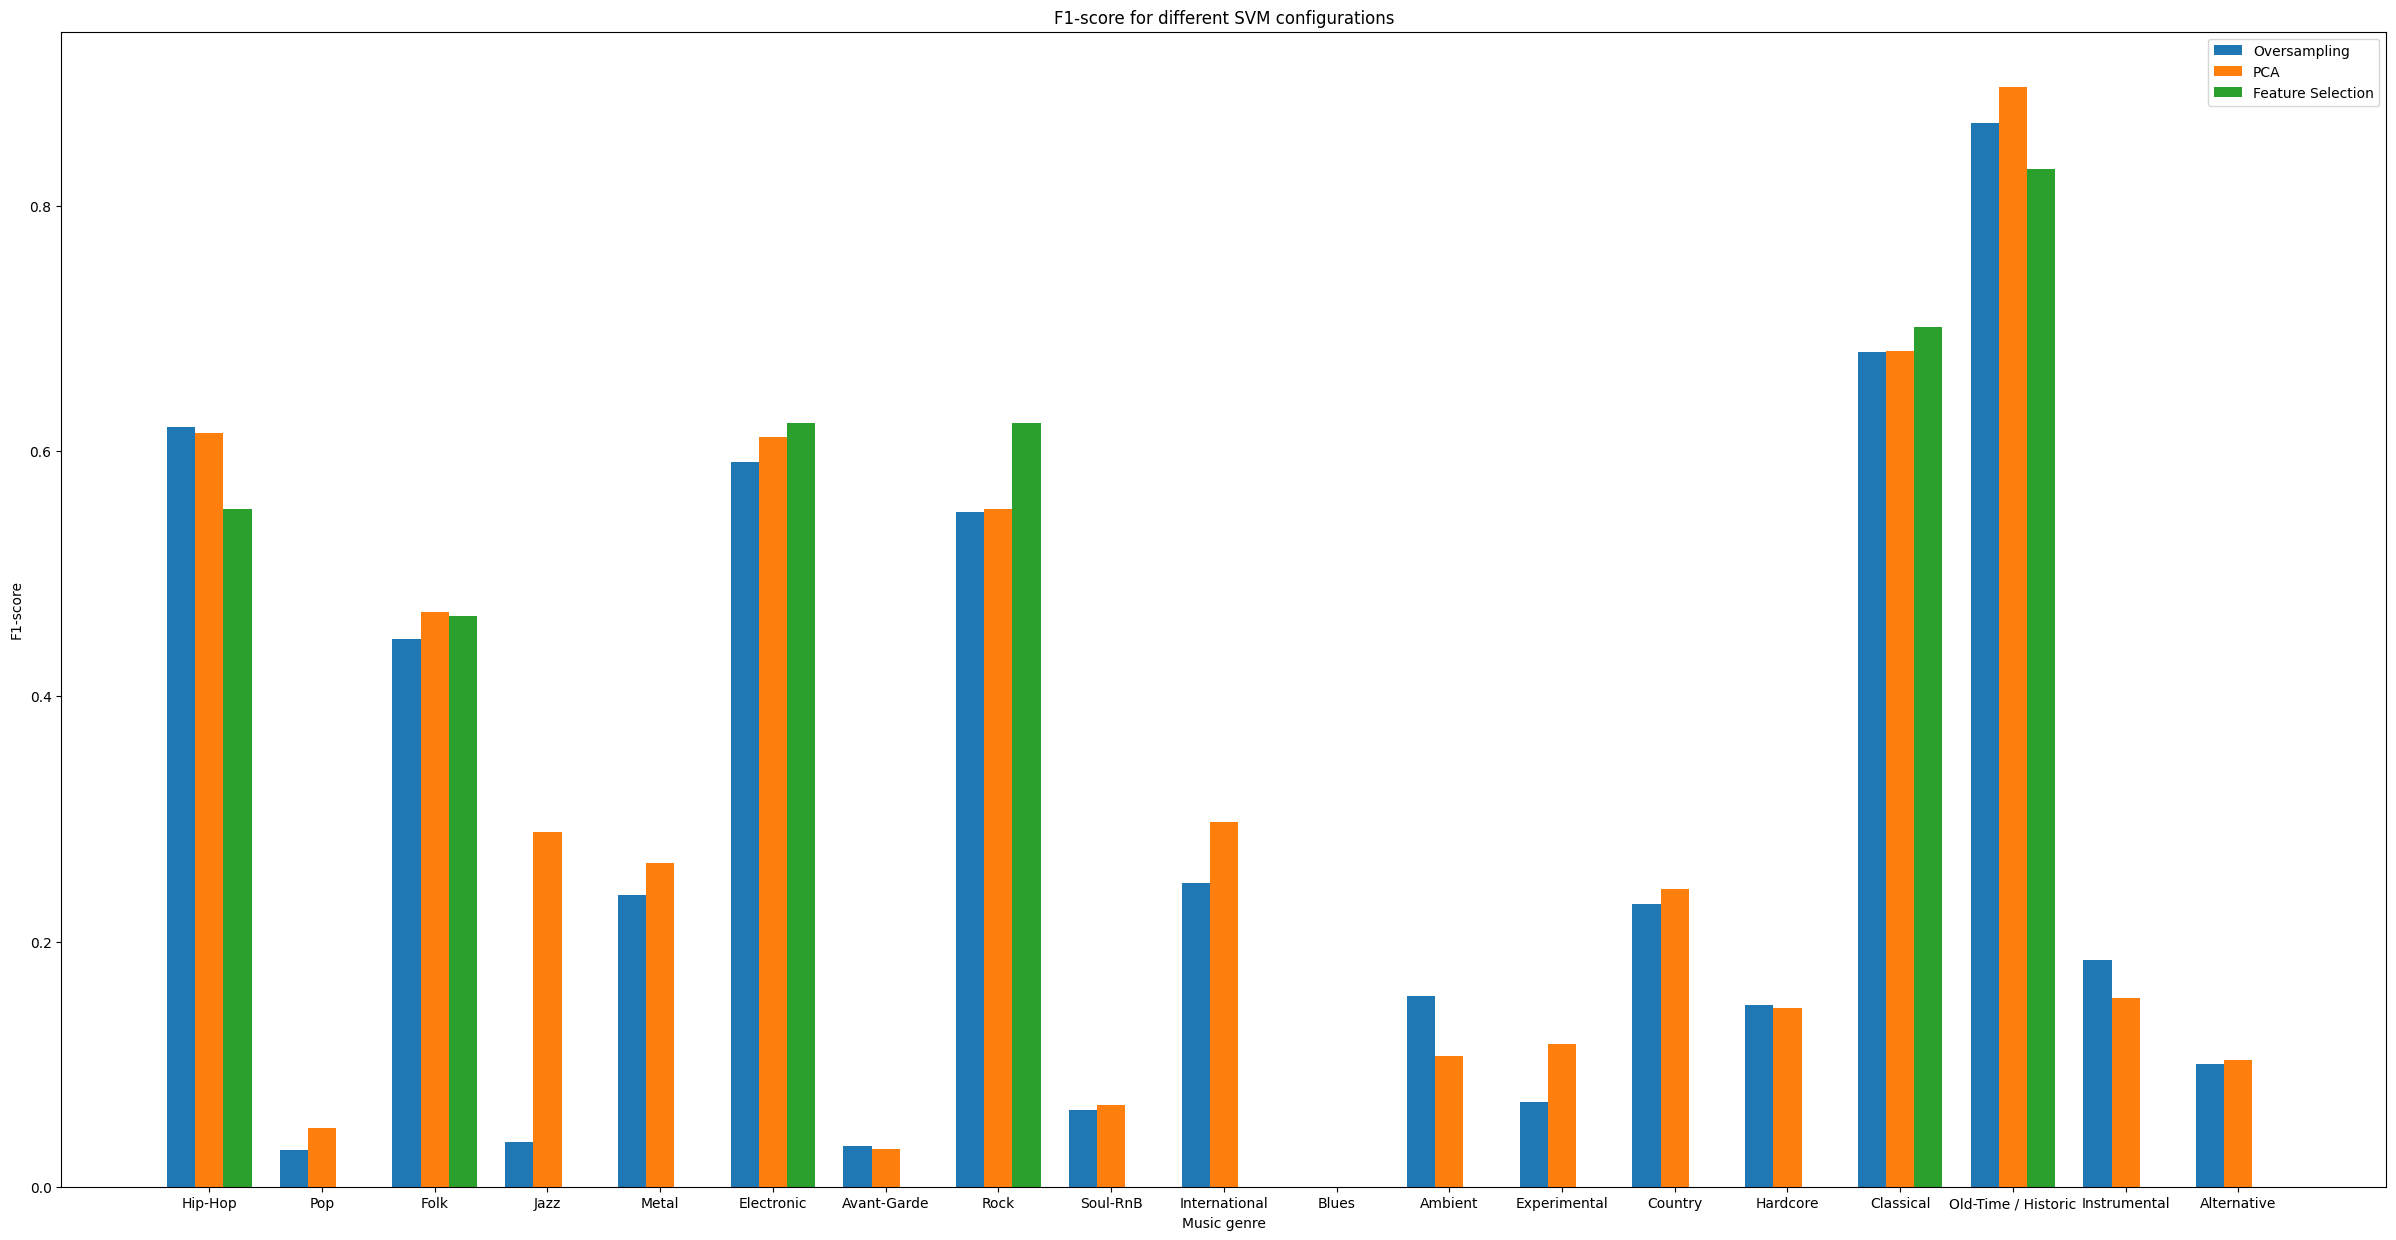

In [22]:
three_group_bar_plot(svm_f1_test, svm_f1_test_pca, svm_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different SVM configurations", "Music genre", 
                    "F1-score", ["Oversampling"]+legend_test)

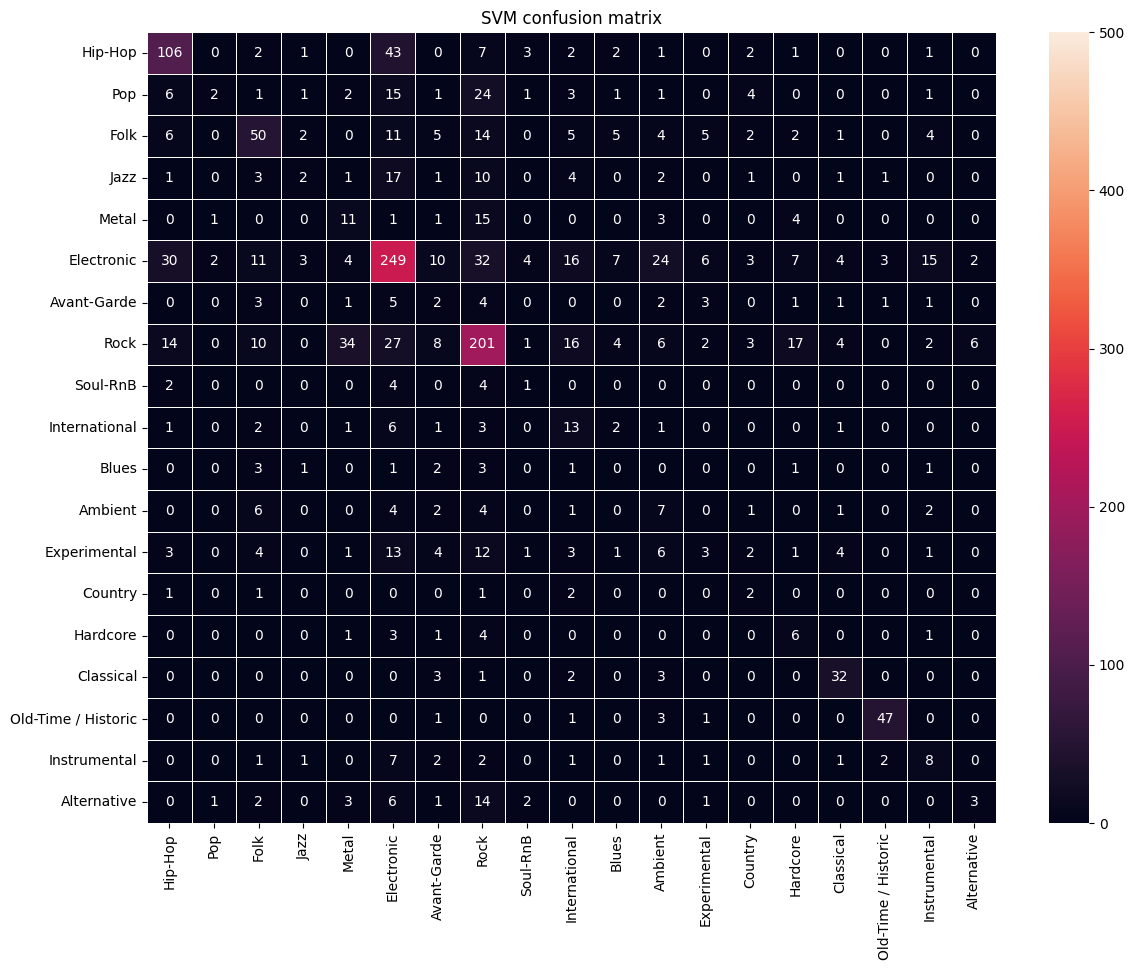

In [14]:
# Confusion matrix
print_cm(svm_cm_test, orig_labels, "Confusion matrix for SVM")

## LR classification

### LR without tweaks

In [22]:
lr_clf = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                            solver=plain['LR']['solver']).fit(X_train, y_train)
lr_val_predict = cross_val_predict(lr_clf, X_validate, y_validate, cv=5)

lr_results = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report = lr_results[0]
lr_precision = lr_results[1]
lr_recall = lr_results[2]
lr_f1 = lr_results[3]

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


------------------------------ LR completed ------------------------------


/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


### LR with oversampling

In [23]:
lr_clf_os = LogisticRegression(C=1, penalty=overs['LR']['penalty'], dual=False, 
                               solver=overs['LR']['solver']).fit(X_train_os, y_train_os)
lr_val_predict_os = cross_val_predict(lr_clf_os, X_validate, y_validate, cv=5)

lr_results_os = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report_os = lr_results_os[0]
lr_precision_os = lr_results_os[1]
lr_recall_os = lr_results_os[2]
lr_f1_os = lr_results_os[3]

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn

### LR with SMOTE

In [24]:
lr_clf_smote = LogisticRegression(C=1, penalty=smote['LR']['penalty'], dual=False, 
                                  solver=smote['LR']['solver']).fit(X_train_smote, y_train_smote)
lr_val_predict_smote = cross_val_predict(lr_clf_smote, X_validate, y_validate, cv=5)

lr_results_smote = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict_smote), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report_smote = lr_results_smote[0]
lr_precision_smote = lr_results_smote[1]
lr_recall_smote = lr_results_smote[2]
lr_f1_smote = lr_results_smote[3]

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn

### Metrics comparison for LR

In [25]:
# Print the summary tables
print("-------------------------------- Metrics without tweaks --------------------------------")
lr_report

-------------------------------- Metrics without tweaks --------------------------------


{'Hip-Hop': {'precision': 0.5939849624060151,
  'recall': 0.5,
  'f1-score': 0.5429553264604811,
  'support': 158},
 'Pop': {'precision': 0.125,
  'recall': 0.0196078431372549,
  'f1-score': 0.03389830508474576,
  'support': 51},
 'Folk': {'precision': 0.45714285714285713,
  'recall': 0.5052631578947369,
  'f1-score': 0.48000000000000004,
  'support': 95},
 'Jazz': {'precision': 0.1,
  'recall': 0.02857142857142857,
  'f1-score': 0.04444444444444444,
  'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.5546038543897216,
  'recall': 0.6523929471032746,
  'f1-score': 0.599537037037037,
  'support': 397},
 'Avant-Garde': {'precision': 0.09090909090909091,
  'recall': 0.034482758620689655,
  'f1-score': 0.05,
  'support': 29},
 'Rock': {'precision': 0.5591182364729459,
  'recall': 0.7707182320441989,
  'f1-score': 0.6480836236933797,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 's

In [26]:
print("------------------------------ Metrics with oversampling ------------------------------")
lr_report_os

------------------------------ Metrics with oversampling ------------------------------


{'Hip-Hop': {'precision': 0.582089552238806,
  'recall': 0.4936708860759494,
  'f1-score': 0.5342465753424658,
  'support': 158},
 'Pop': {'precision': 0.14285714285714285,
  'recall': 0.0196078431372549,
  'f1-score': 0.034482758620689655,
  'support': 51},
 'Folk': {'precision': 0.4752475247524752,
  'recall': 0.5052631578947369,
  'f1-score': 0.4897959183673469,
  'support': 95},
 'Jazz': {'precision': 0.1,
  'recall': 0.02857142857142857,
  'f1-score': 0.04444444444444444,
  'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.551063829787234,
  'recall': 0.6523929471032746,
  'f1-score': 0.5974625144175317,
  'support': 397},
 'Avant-Garde': {'precision': 0.09090909090909091,
  'recall': 0.034482758620689655,
  'f1-score': 0.05,
  'support': 29},
 'Rock': {'precision': 0.5582329317269076,
  'recall': 0.7679558011049724,
  'f1-score': 0.6465116279069768,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall

In [27]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
lr_report_smote

-------------------------------- Metrics with SMOTE --------------------------------


{'Hip-Hop': {'precision': 0.582089552238806,
  'recall': 0.4936708860759494,
  'f1-score': 0.5342465753424658,
  'support': 158},
 'Pop': {'precision': 0.14285714285714285,
  'recall': 0.0196078431372549,
  'f1-score': 0.034482758620689655,
  'support': 51},
 'Folk': {'precision': 0.4752475247524752,
  'recall': 0.5052631578947369,
  'f1-score': 0.4897959183673469,
  'support': 95},
 'Jazz': {'precision': 0.1,
  'recall': 0.02857142857142857,
  'f1-score': 0.04444444444444444,
  'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.551063829787234,
  'recall': 0.6523929471032746,
  'f1-score': 0.5974625144175317,
  'support': 397},
 'Avant-Garde': {'precision': 0.09090909090909091,
  'recall': 0.034482758620689655,
  'f1-score': 0.05,
  'support': 29},
 'Rock': {'precision': 0.5582329317269076,
  'recall': 0.7679558011049724,
  'f1-score': 0.6465116279069768,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall

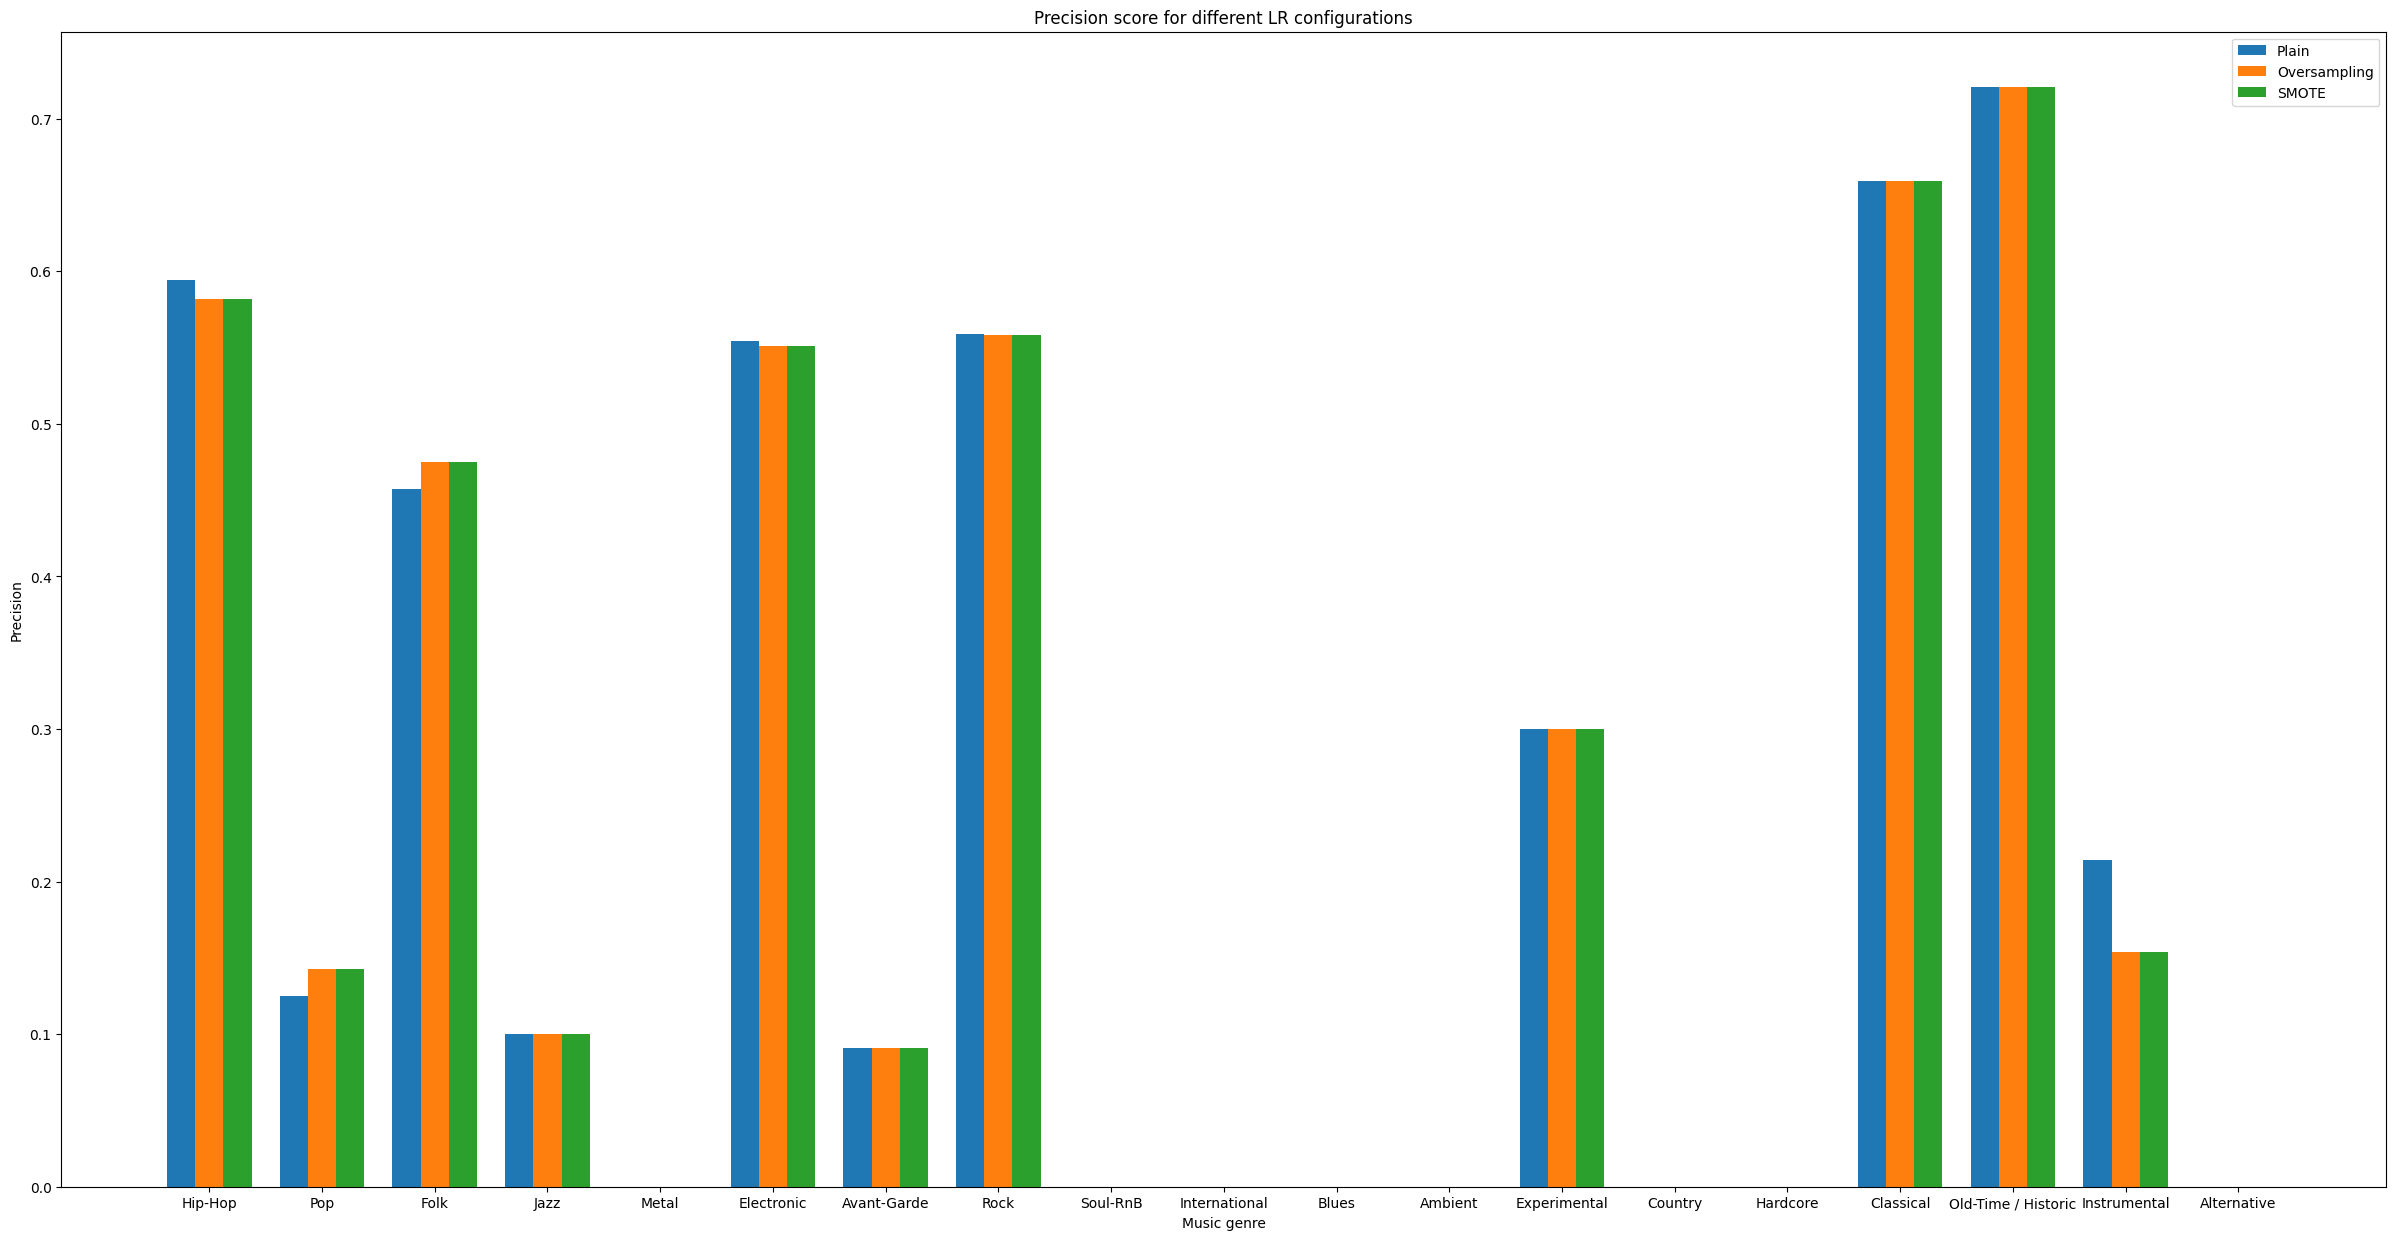

In [28]:
three_group_bar_plot(lr_precision, lr_precision_os, lr_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different LR configurations", "Music genre", 
                    "Precision", legend_validation)

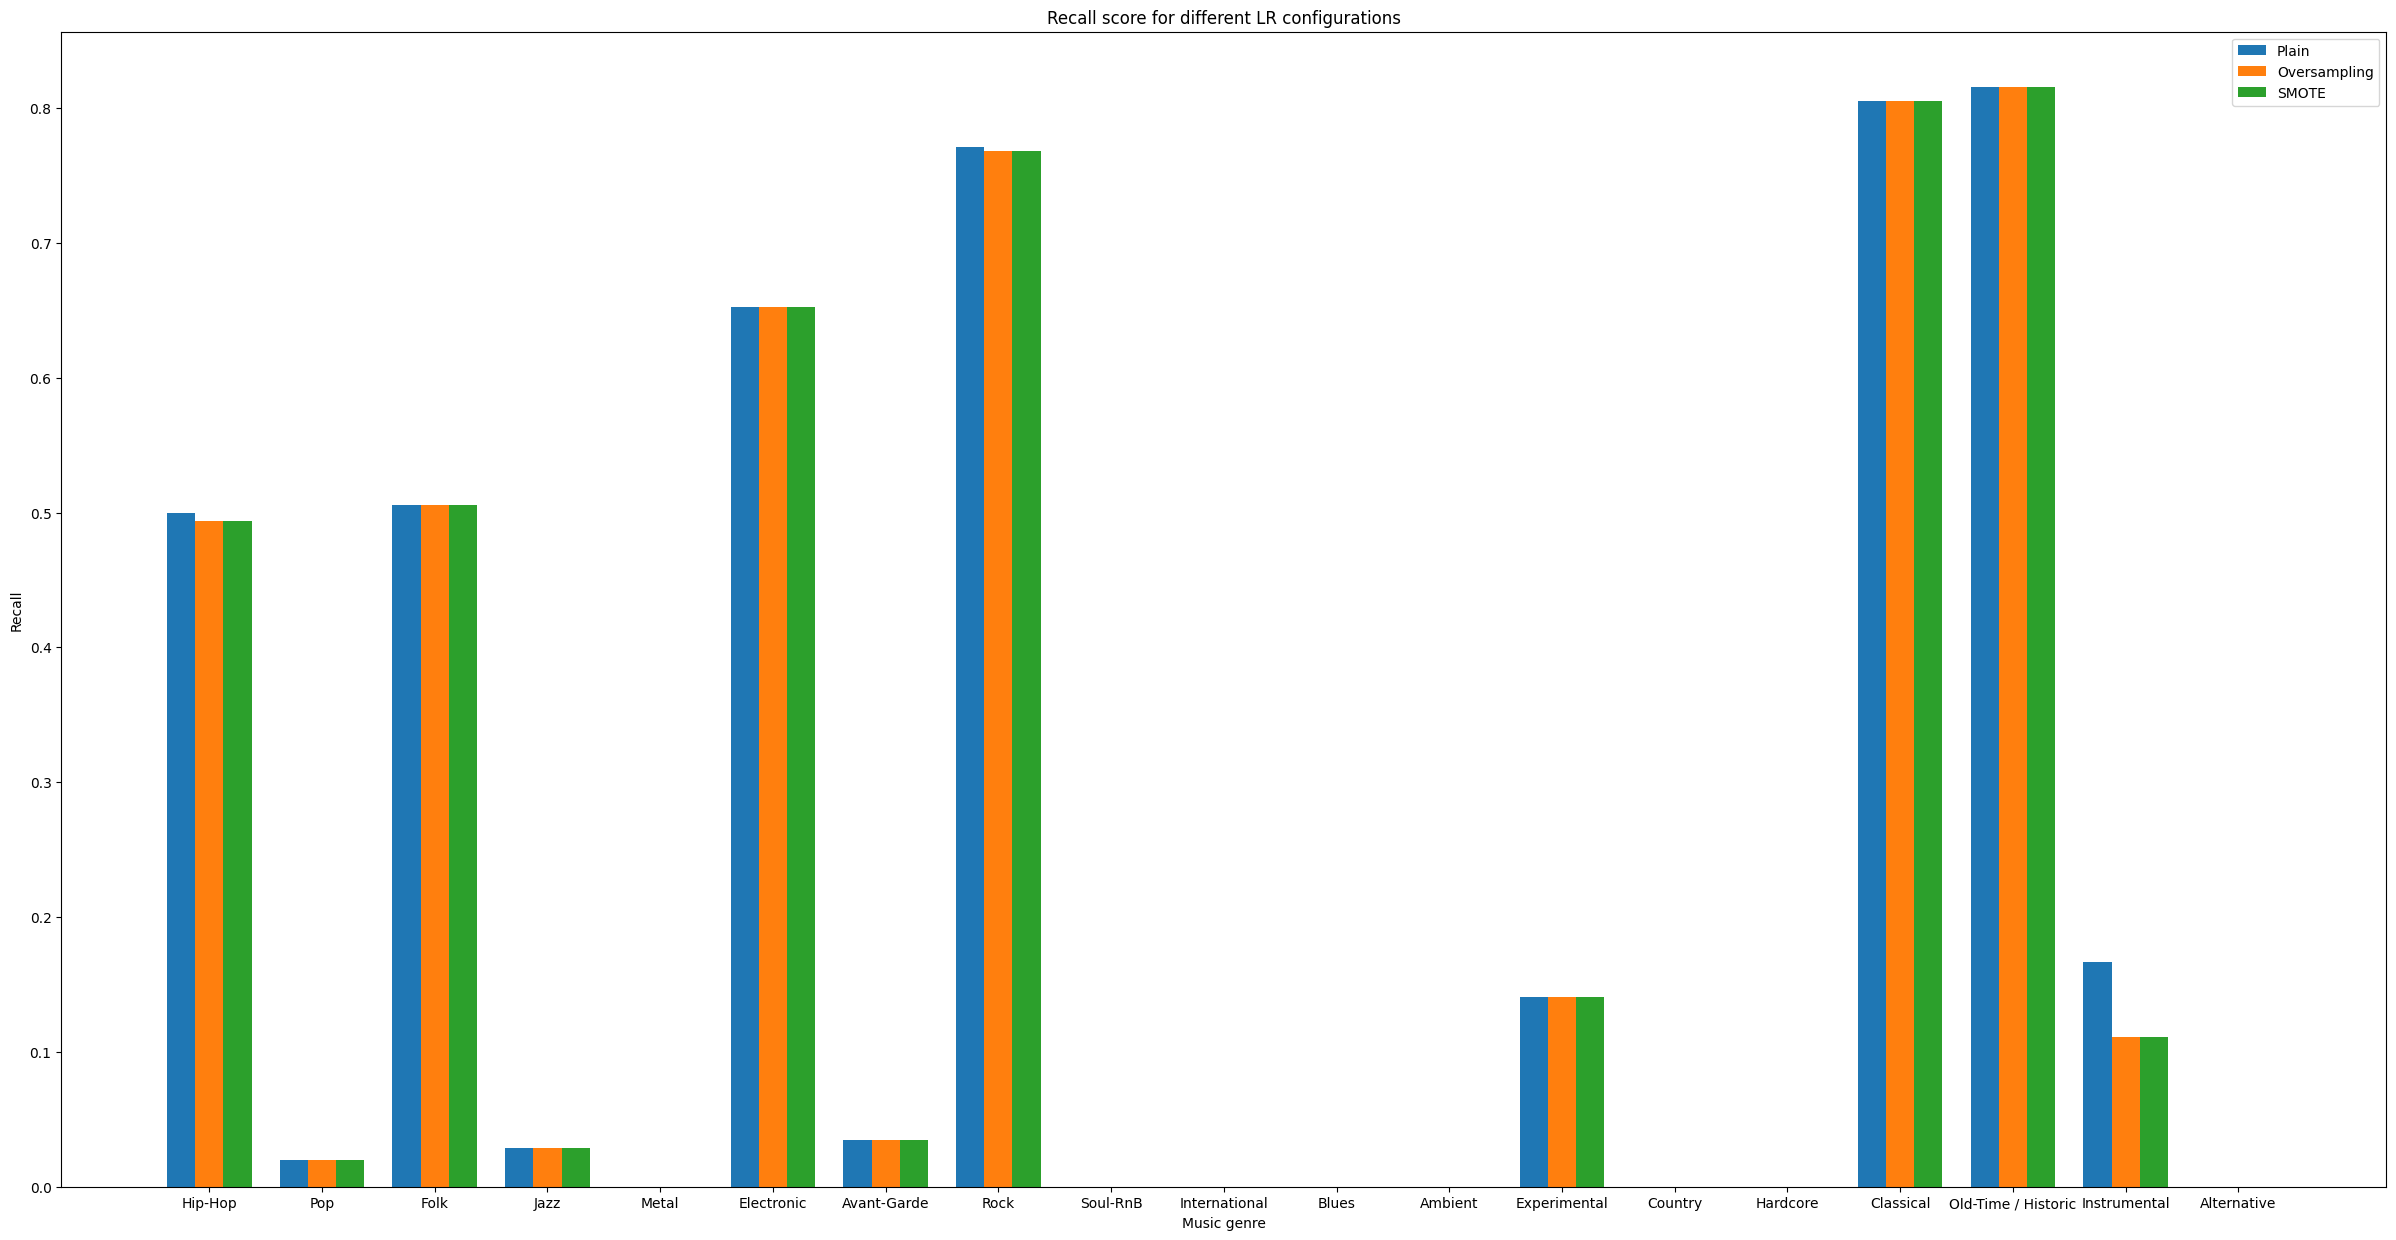

In [29]:
three_group_bar_plot(lr_recall, lr_recall_os, lr_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different LR configurations", "Music genre", 
                    "Recall", legend_validation)

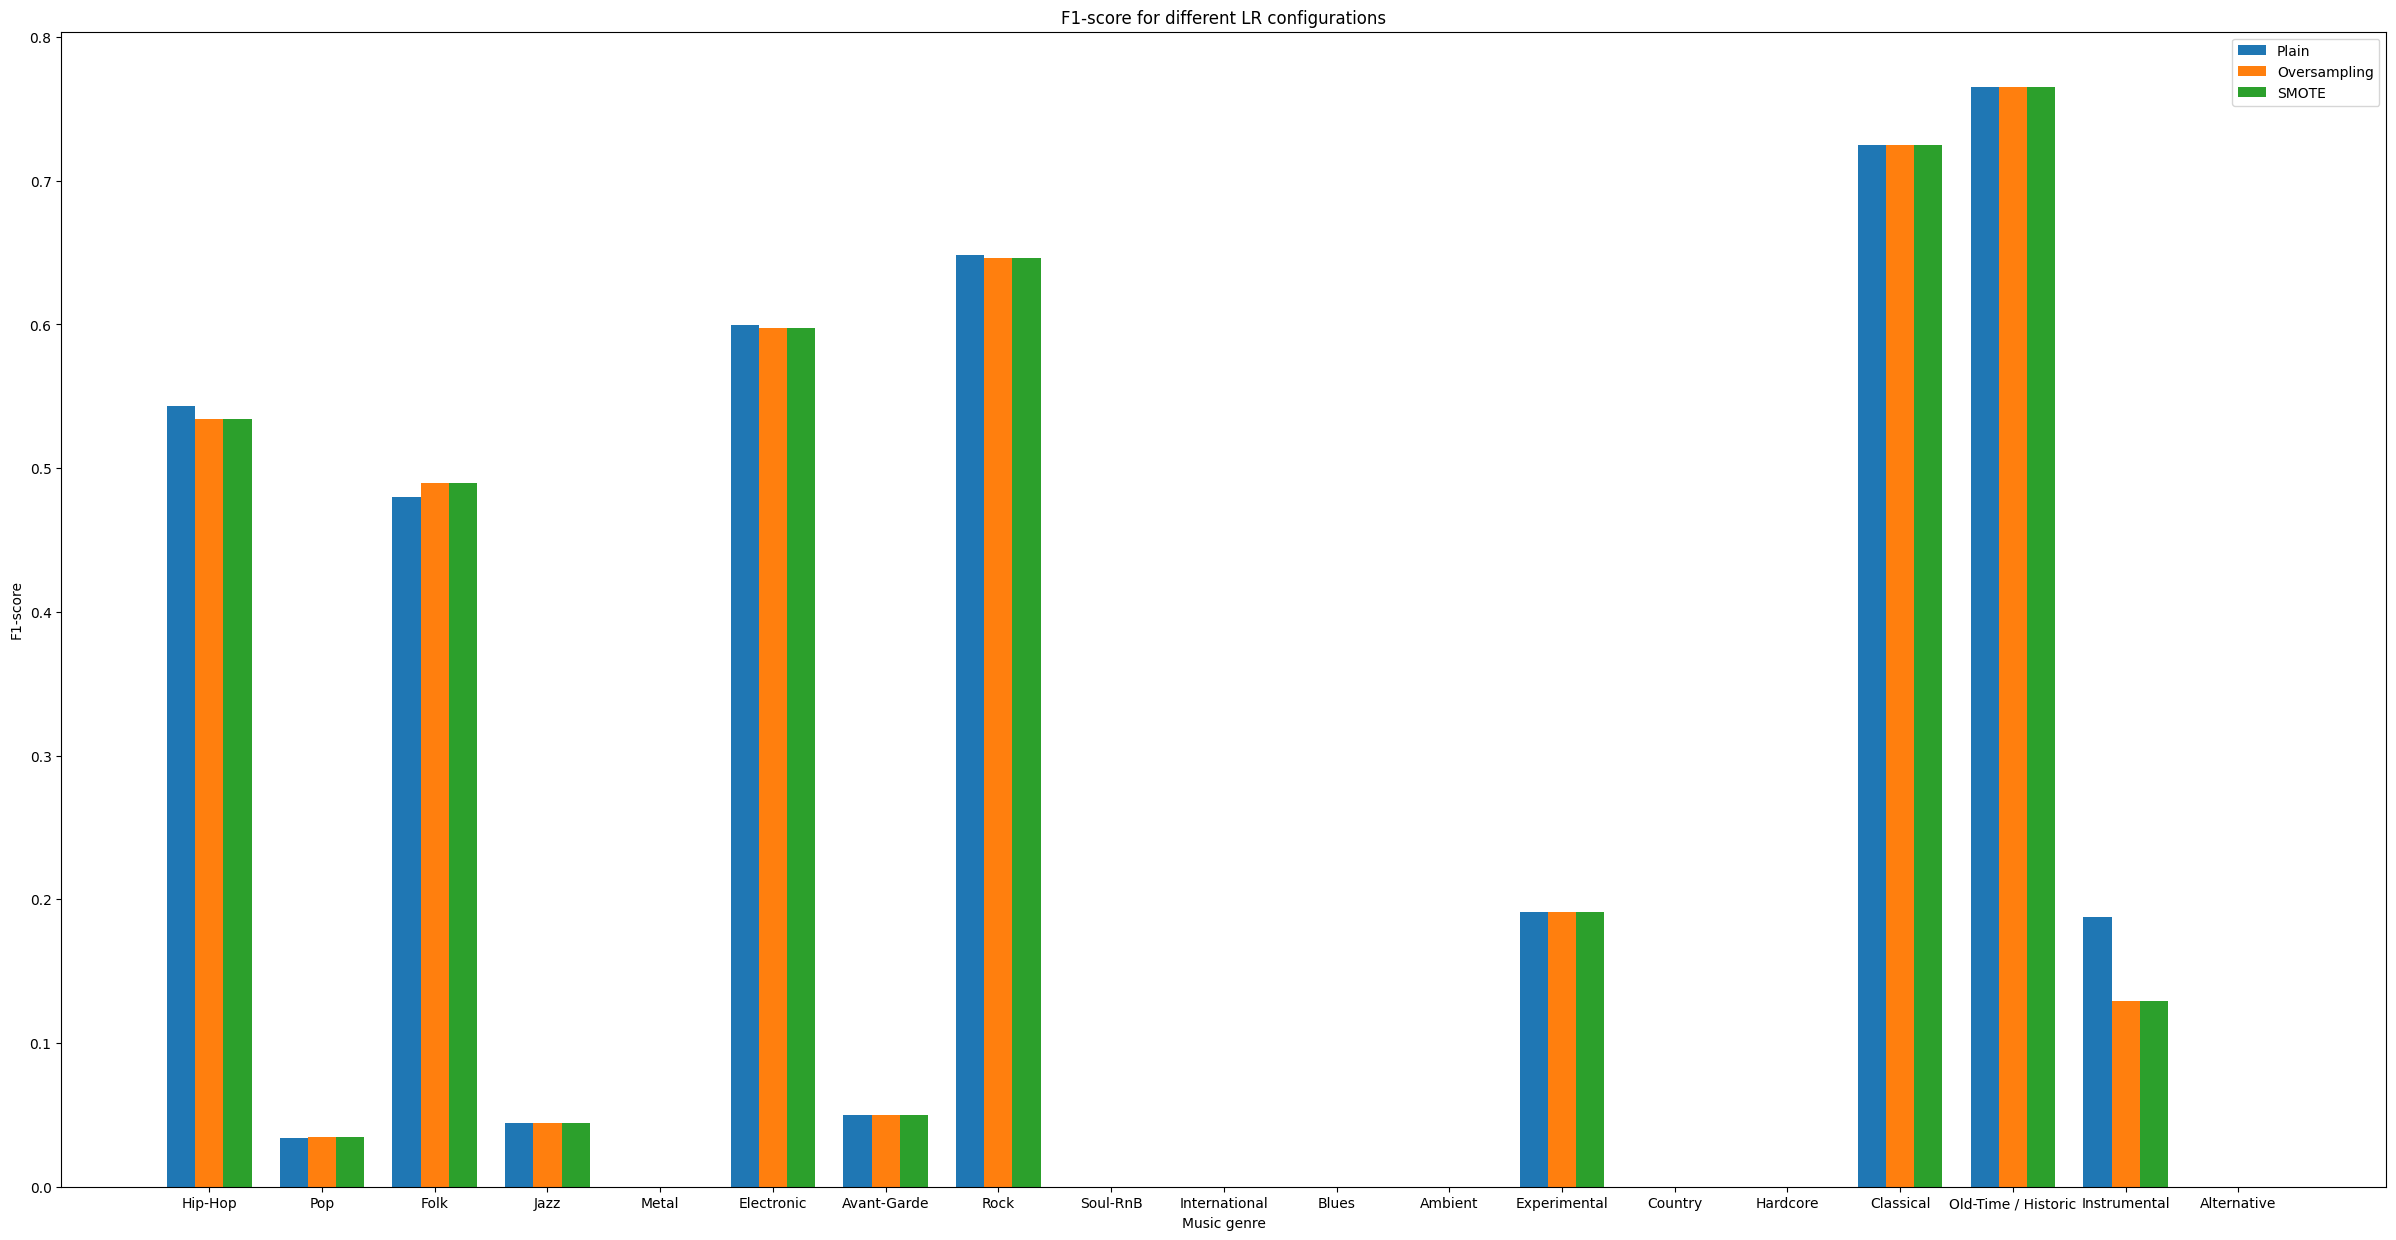

In [30]:
three_group_bar_plot(lr_f1, lr_f1_os, lr_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different LR configurations", "Music genre", 
                    "F1-score", legend_validation)

### LR on test set
Best case: plain

In [24]:
orig_labels = le.inverse_transform(labels)
lr_clf = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                             solver=plain['LR']['solver']).fit(X_train, y_train)

lr_test_preds = lr_clf.predict(X_test)
lr_results_test = compute_class_metrics(
    predictions = le.inverse_transform(lr_test_preds), 
    y_set= le.inverse_transform(y_test), 
    labels=orig_labels
)

lr_report_test = lr_results_test[0]
lr_precision_test = lr_results_test[1]
lr_recall_test = lr_results_test[2]
lr_f1_test = lr_results_test[3]

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [25]:
pca = PCA(n_components=plain_pca['LR']['n_components'])
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

lr_clf = LogisticRegression(C=1, penalty=plain_pca['LR']['penalty'], dual=False, 
                             solver=plain_pca['LR']['solver']).fit(X_train_pca, y_train)
lr_test_preds_pca = lr_clf.predict(X_test_pca)
lr_results_test_pca = compute_class_metrics(
    predictions = le.inverse_transform(lr_test_preds_pca), 
    y_set= le.inverse_transform(y_test), 
    labels=orig_labels
)

lr_report_test_pca = lr_results_test_pca[0]
lr_precision_test_pca = lr_results_test_pca[1]
lr_recall_test_pca = lr_results_test_pca[2]
lr_f1_test_pca = lr_results_test_pca[3]

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [27]:
lr_clf = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                             solver=plain['LR']['solver']).fit(X_train_fs, y_train)
lr_test_preds_fs = lr_clf.predict(X_test_fs)
lr_results_test_fs = compute_class_metrics(
    predictions = le.inverse_transform(lr_test_preds_fs), 
    y_set= le.inverse_transform(y_test_fs), 
    labels=orig_labels
)

lr_report_test_fs = lr_results_test_fs[0]
lr_precision_test_fs = lr_results_test_fs[1]
lr_recall_test_fs = lr_results_test_fs[2]
lr_f1_test_fs = lr_results_test_fs[3]

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [32]:
lr_report_test

{'Hip-Hop': {'precision': 0.6753246753246753,
  'recall': 0.6081871345029239,
  'f1-score': 0.64,
  'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.5630252100840336,
  'recall': 0.5775862068965517,
  'f1-score': 0.5702127659574467,
  'support': 116},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36},
 'Electronic': {'precision': 0.5883424408014571,
  'recall': 0.7476851851851852,
  'f1-score': 0.6585117227319062,
  'support': 432},
 'Avant-Garde': {'precision': 0.14285714285714285,
  'recall': 0.041666666666666664,
  'f1-score': 0.06451612903225806,
  'support': 24},
 'Rock': {'precision': 0.523728813559322,
  'recall': 0.8704225352112676,
  'f1-score': 0.6539682539682539,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'precision': 0.5,
  'recall':

In [33]:
lr_report_test_pca

{'Hip-Hop': {'precision': 0.6962025316455697,
  'recall': 0.6432748538011696,
  'f1-score': 0.668693009118541,
  'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.49295774647887325,
  'recall': 0.603448275862069,
  'f1-score': 0.5426356589147286,
  'support': 116},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36},
 'Electronic': {'precision': 0.5981308411214953,
  'recall': 0.7407407407407407,
  'f1-score': 0.6618407445708376,
  'support': 432},
 'Avant-Garde': {'precision': 0.2727272727272727,
  'recall': 0.125,
  'f1-score': 0.17142857142857143,
  'support': 24},
 'Rock': {'precision': 0.5441176470588235,
  'recall': 0.8338028169014085,
  'f1-score': 0.6585094549499443,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'precision': 0.25,
  'recall': 

In [34]:
lr_report_test_fs

{'Hip-Hop': {'precision': 0.5777777777777777,
  'recall': 0.45614035087719296,
  'f1-score': 0.5098039215686275,
  'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.5,
  'recall': 0.3793103448275862,
  'f1-score': 0.4313725490196078,
  'support': 116},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36},
 'Electronic': {'precision': 0.4890756302521008,
  'recall': 0.6736111111111112,
  'f1-score': 0.5666991236611489,
  'support': 432},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 24},
 'Rock': {'precision': 0.4651539708265802,
  'recall': 0.8084507042253521,
  'f1-score': 0.5905349794238683,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 31},
 'Blu

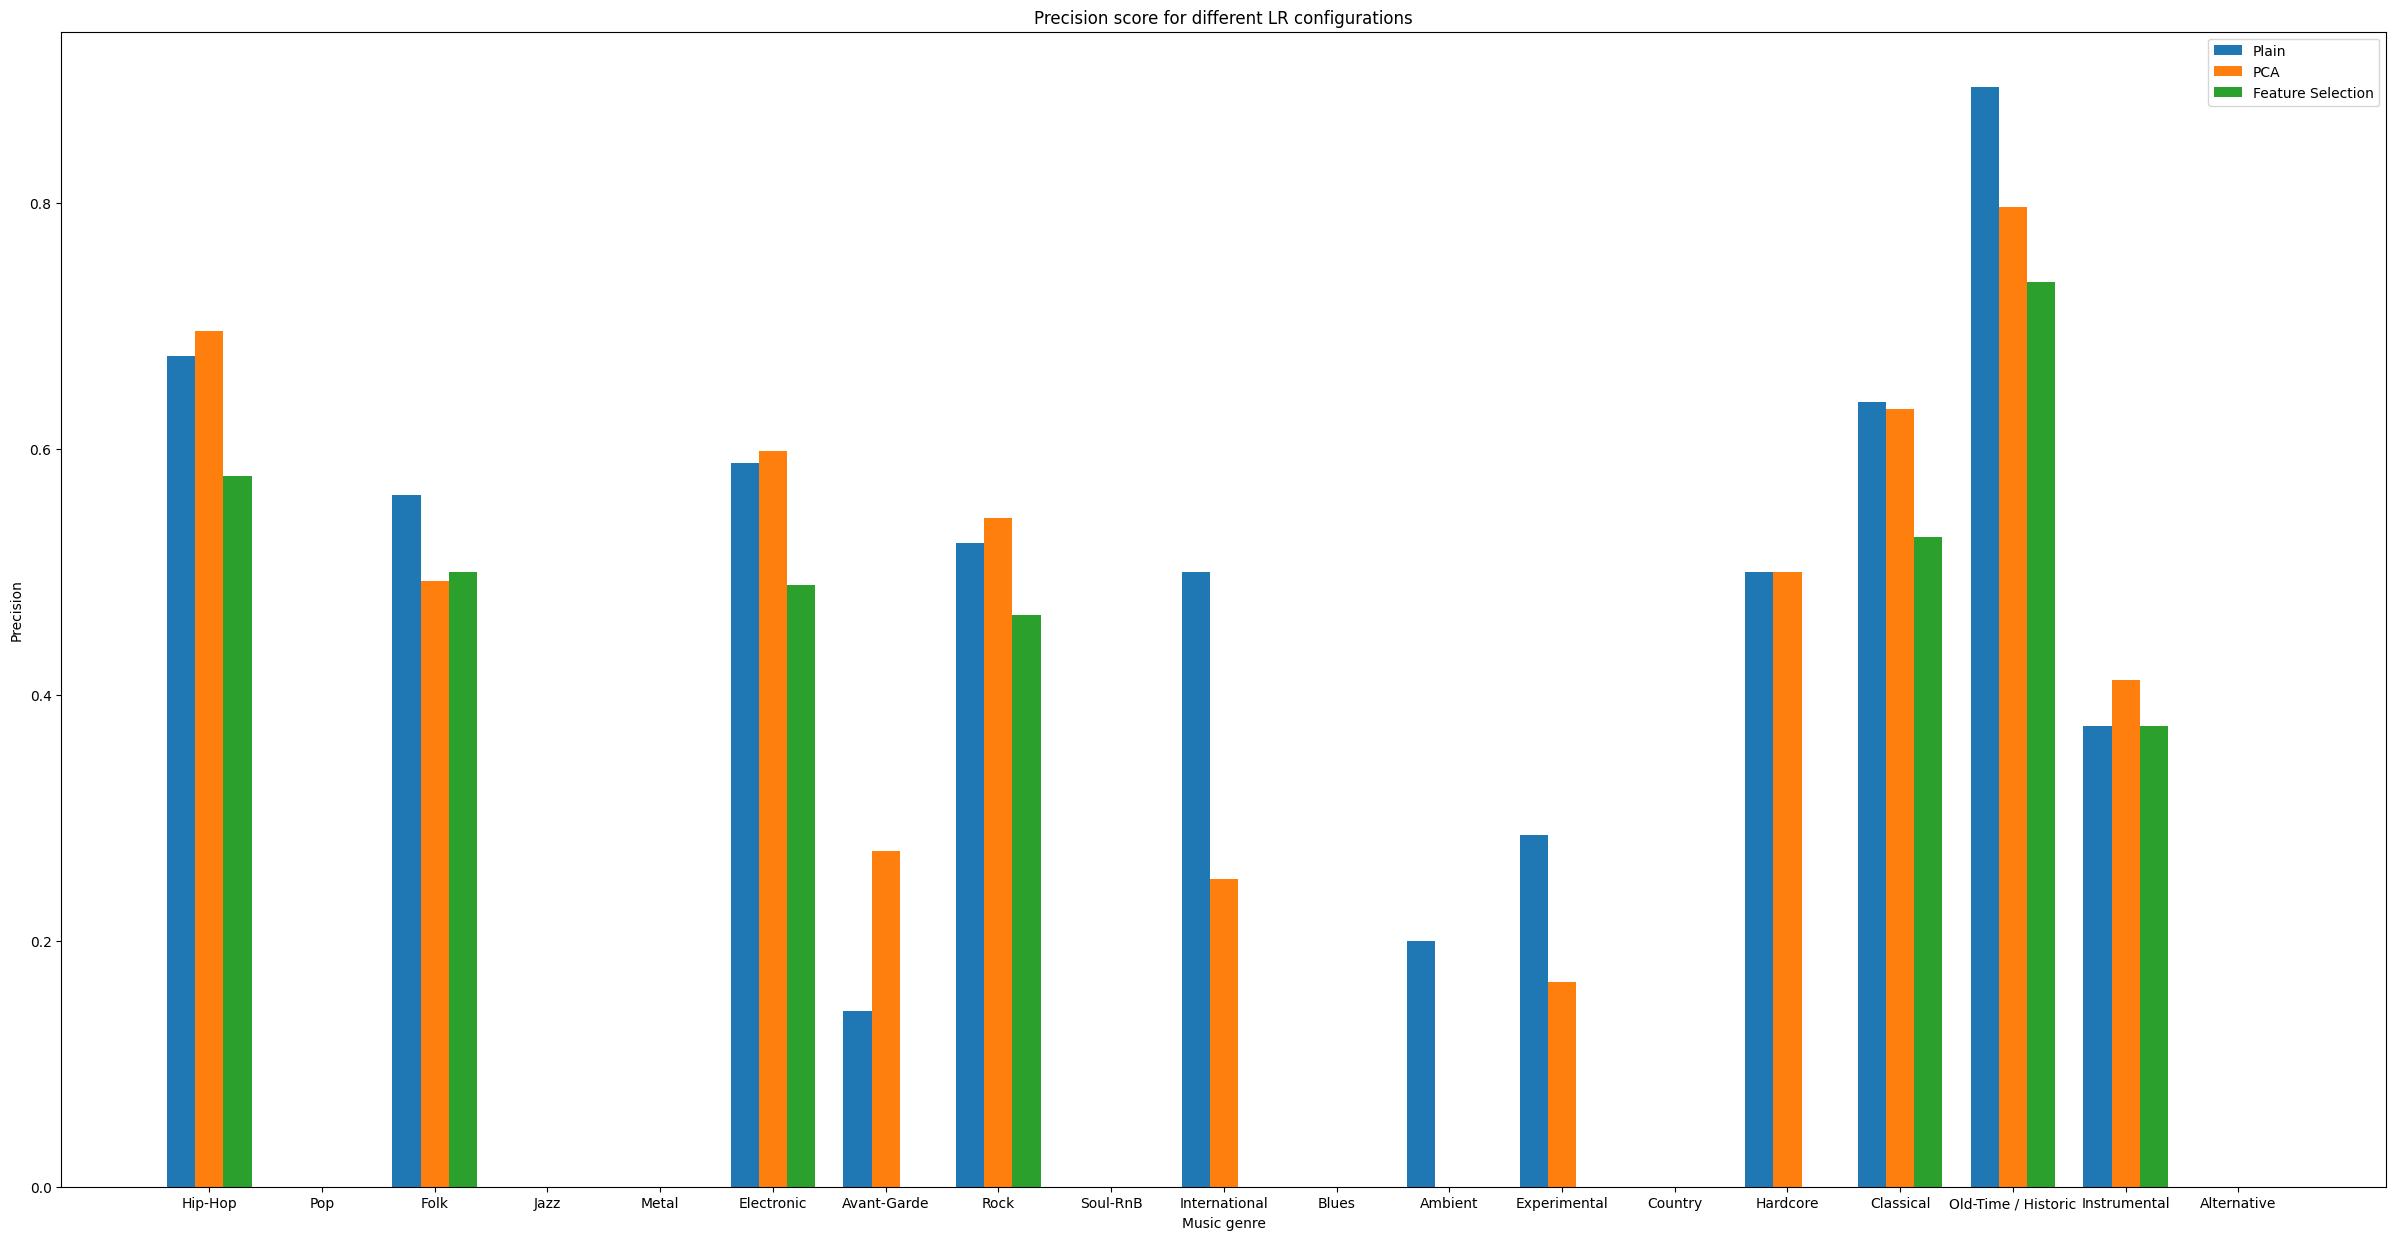

In [29]:
three_group_bar_plot(lr_precision_test, lr_precision_test_pca, lr_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different LR configurations", "Music genre", 
                    "Precision", ["Plain"]+legend_test)

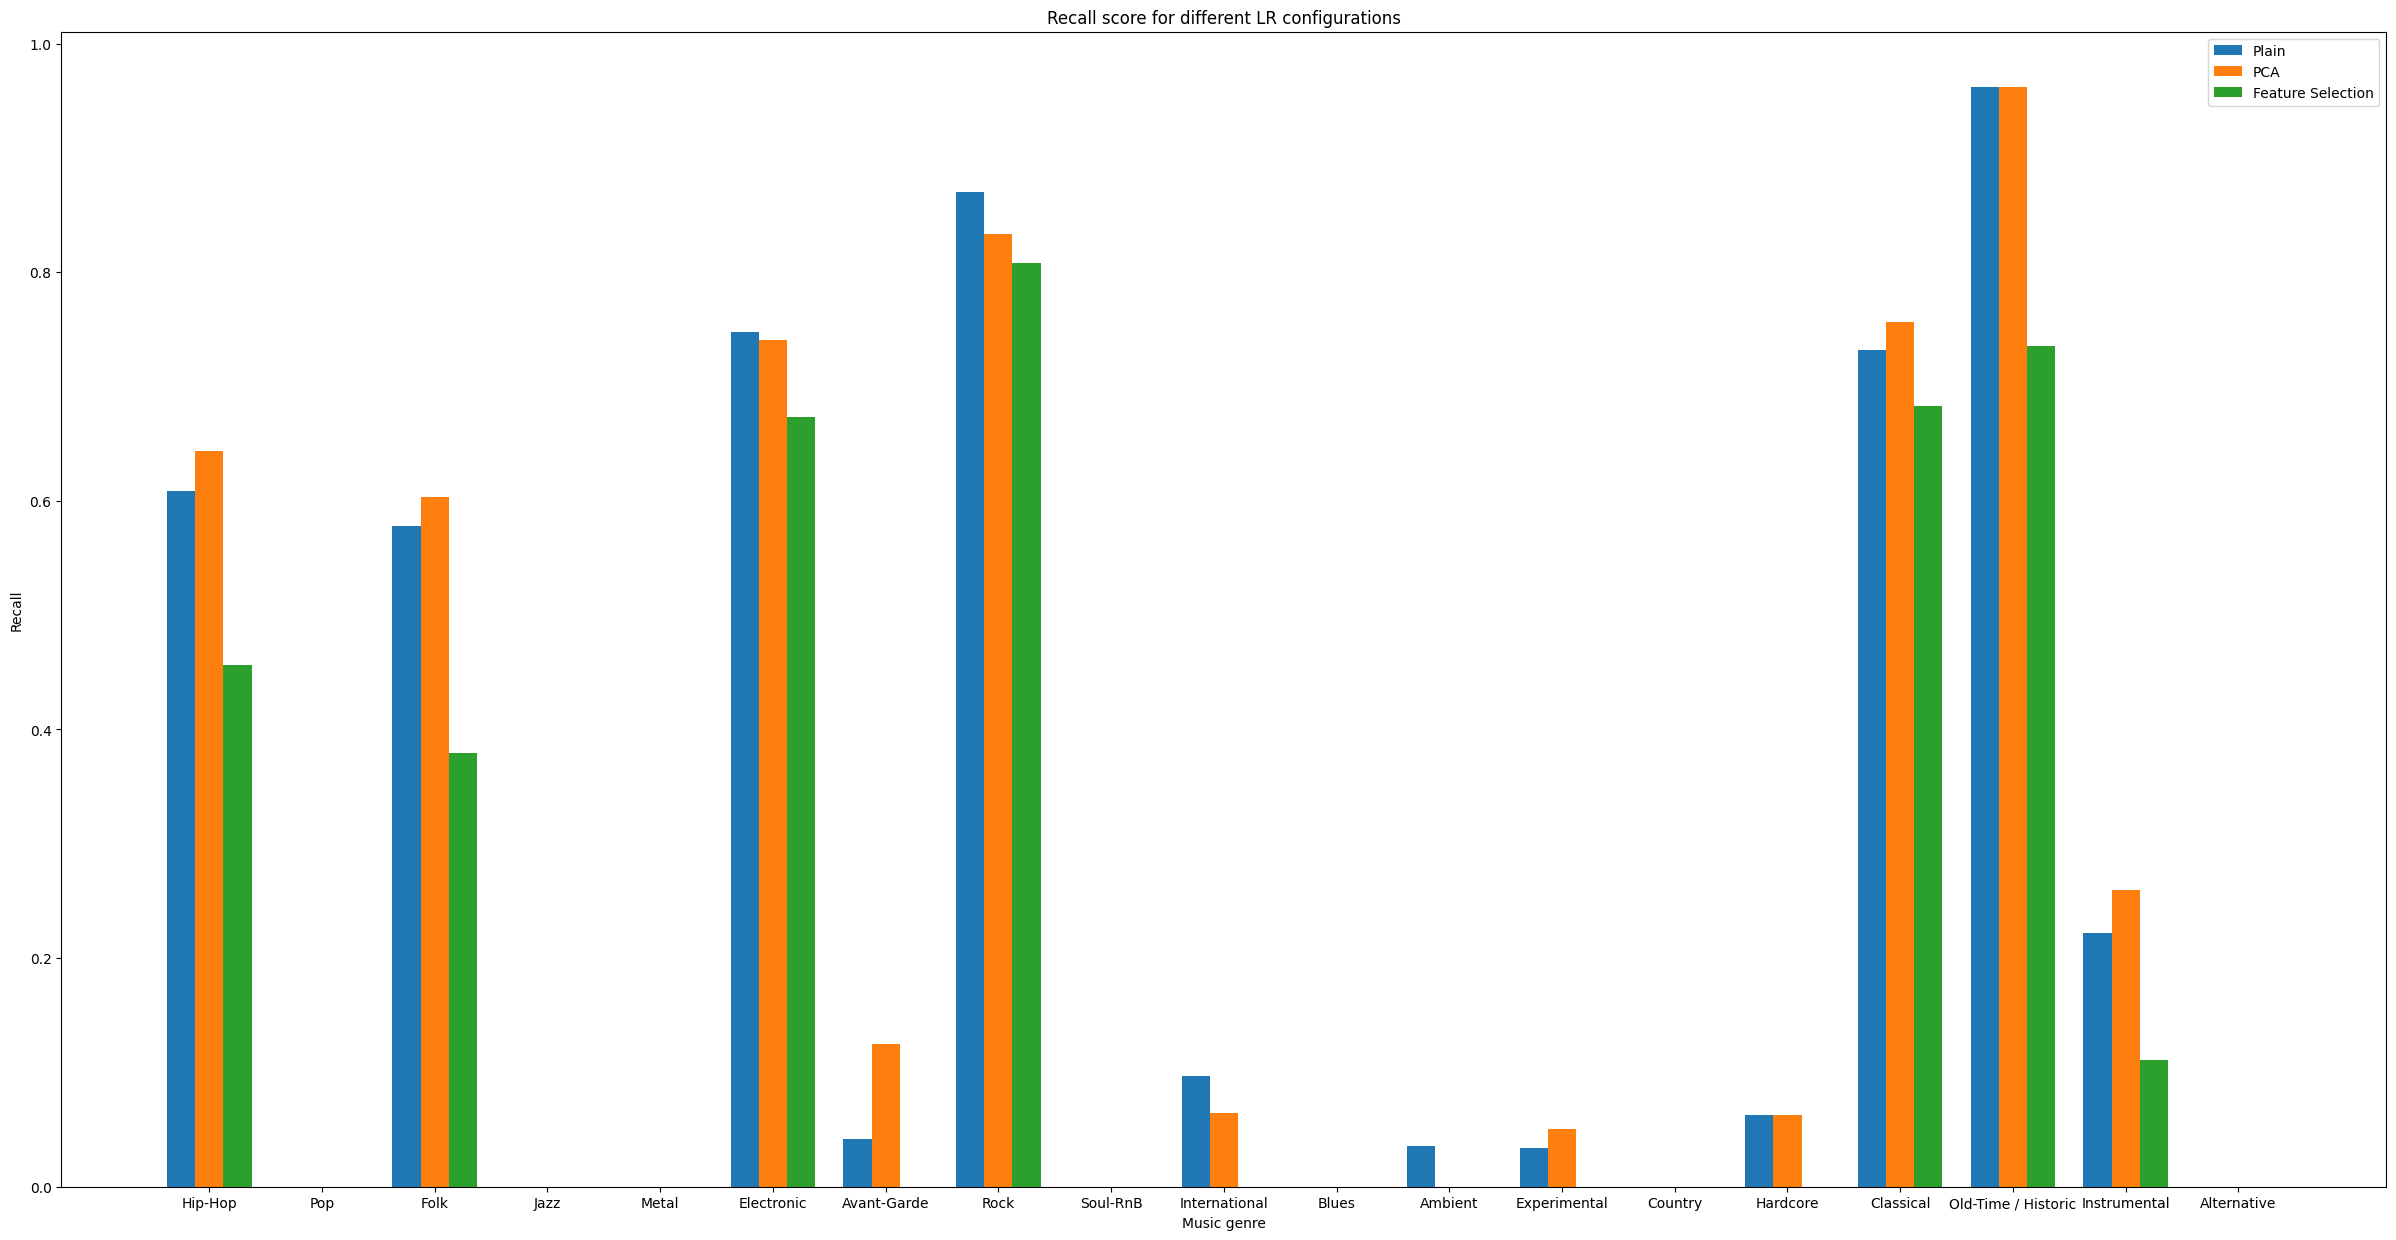

In [30]:
three_group_bar_plot(lr_recall_test, lr_recall_test_pca, lr_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different LR configurations", "Music genre", 
                    "Recall", ["Plain"]+legend_test)

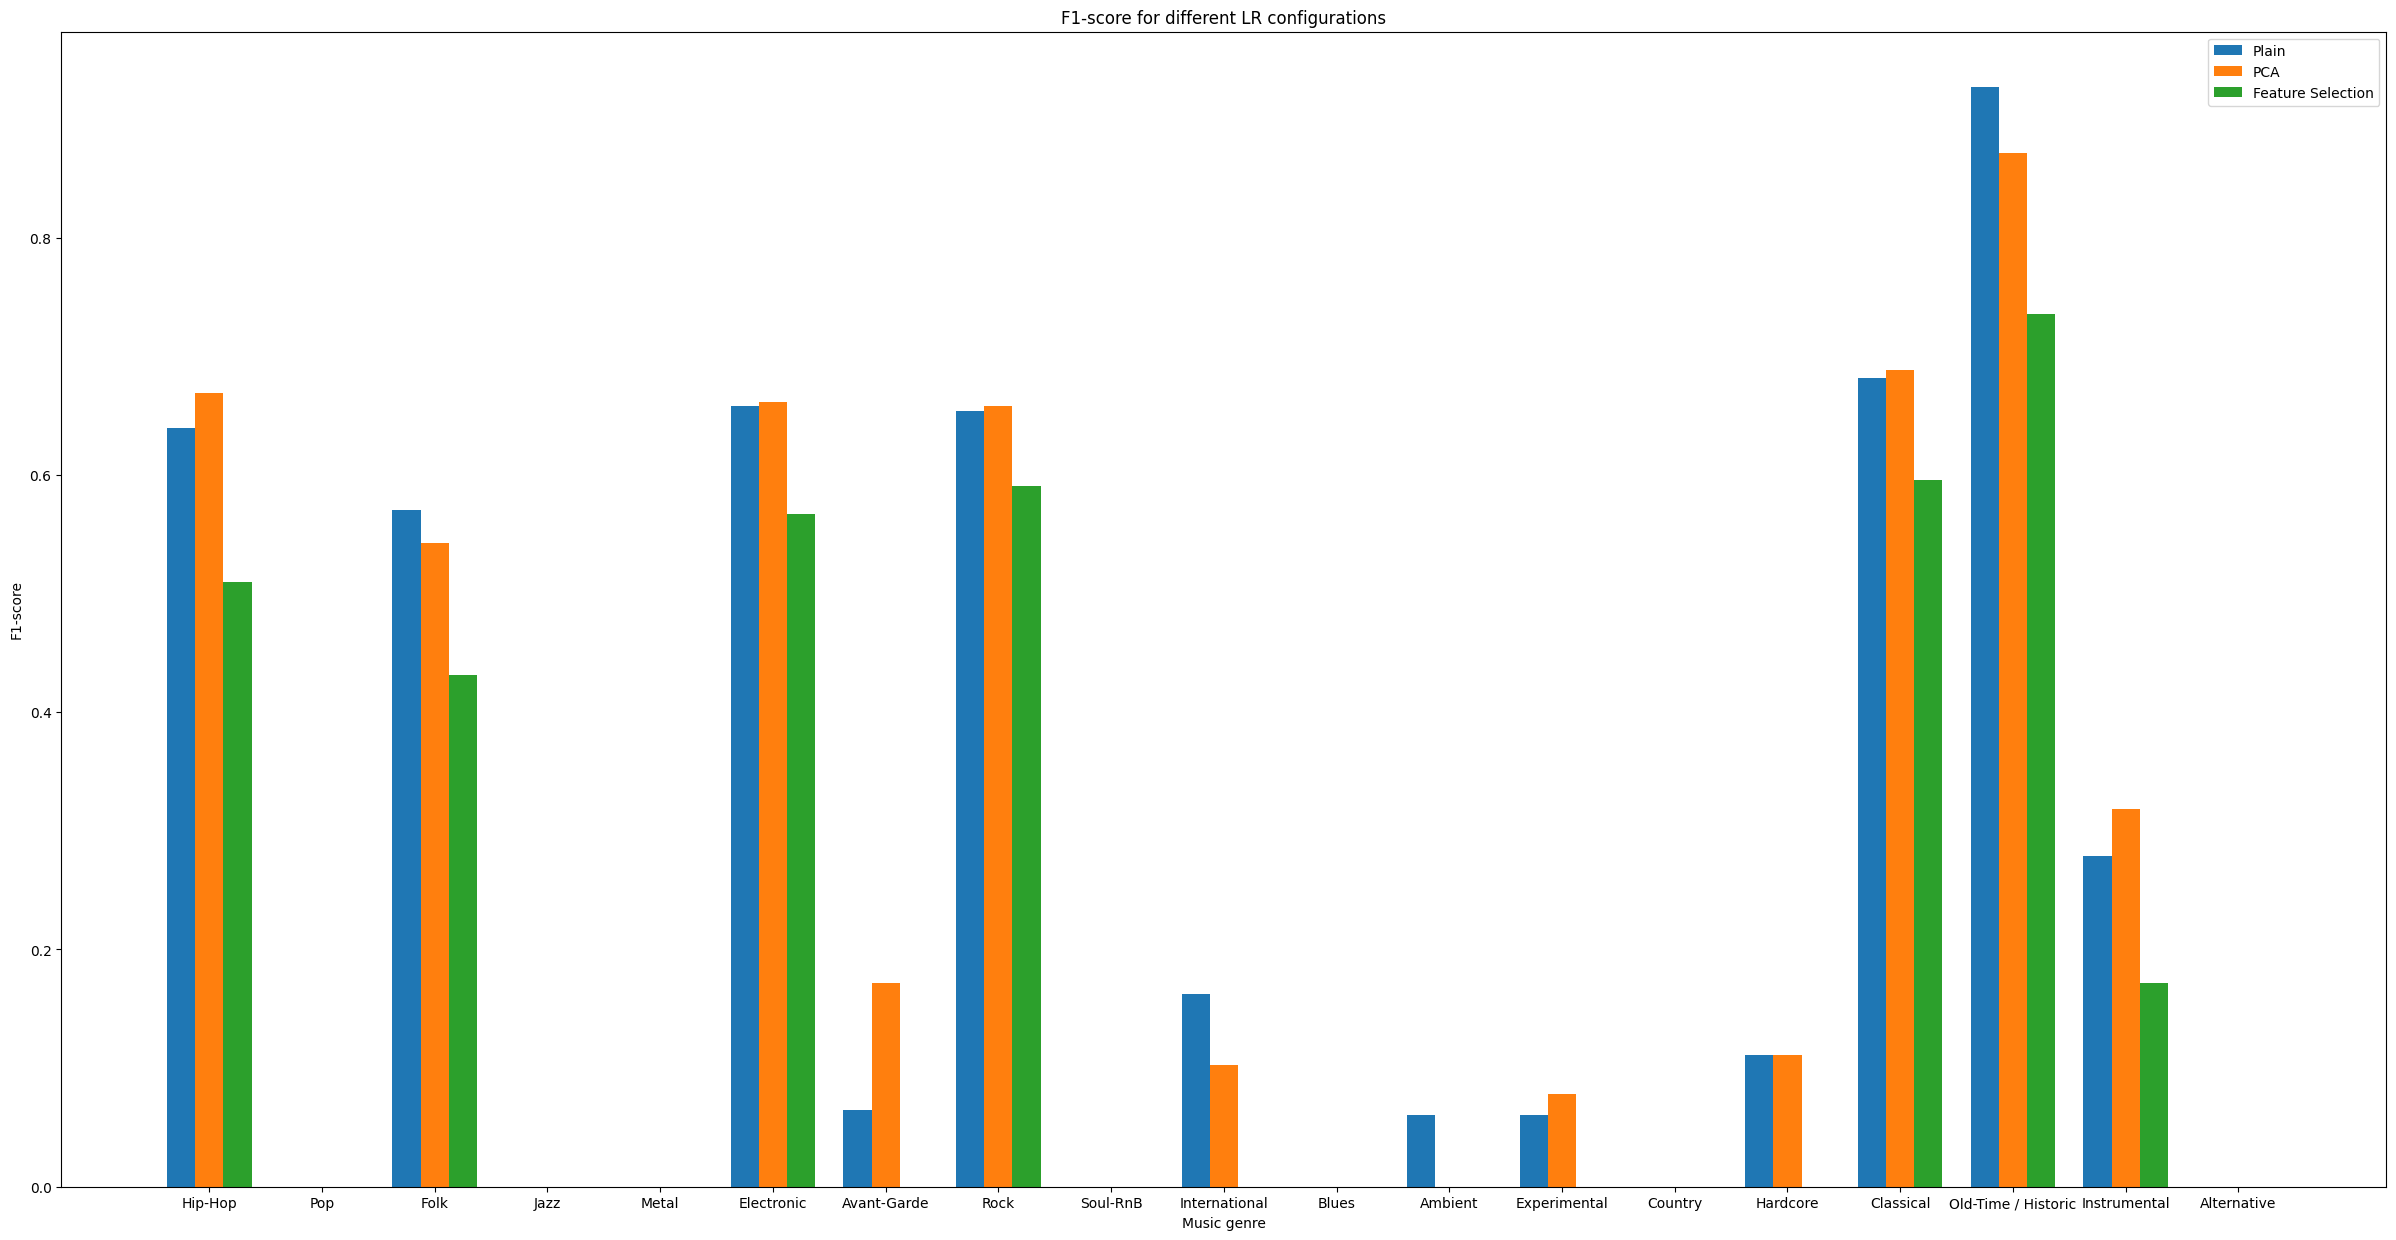

In [31]:
three_group_bar_plot(lr_f1_test, lr_f1_test_pca, lr_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different LR configurations", "Music genre", 
                    "F1-score", ["Plain"]+legend_test)

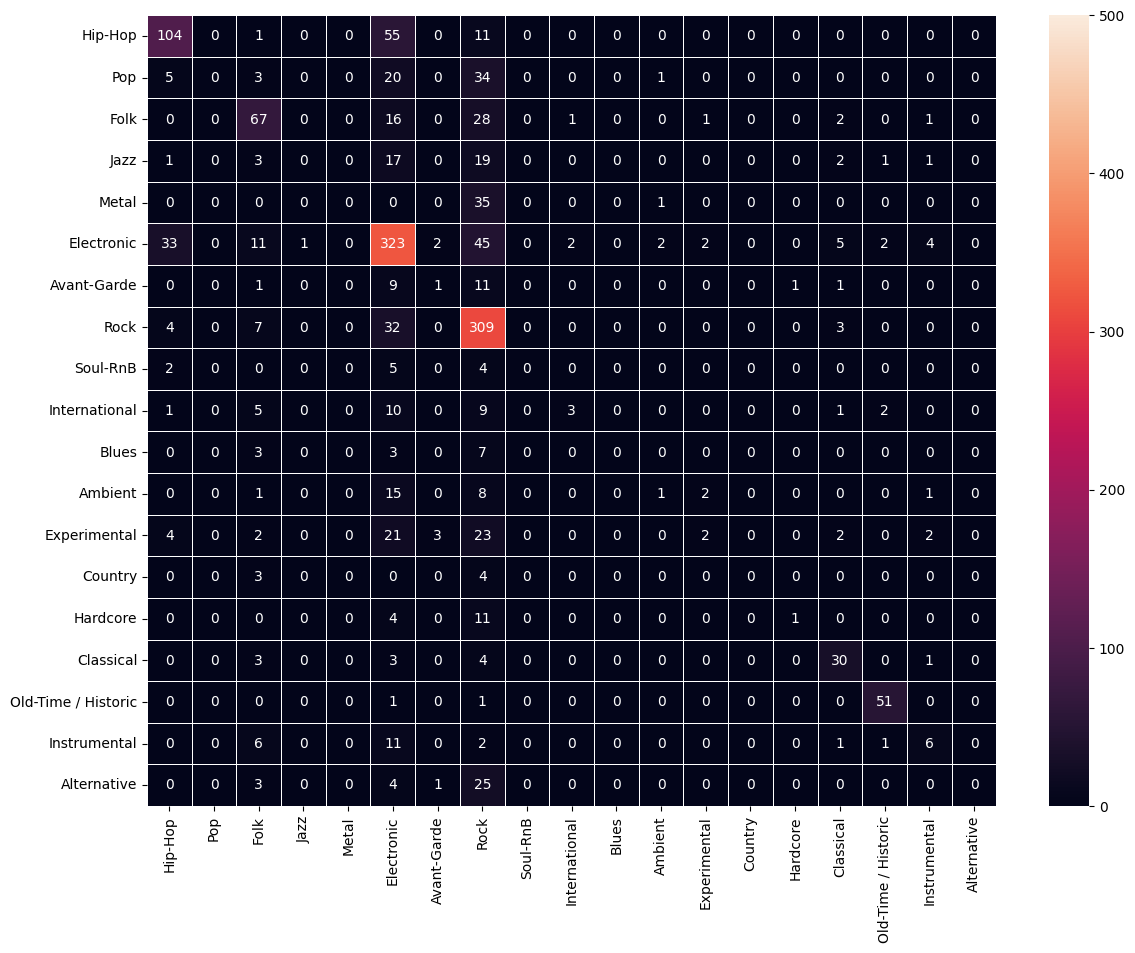

In [35]:
# Confusion matrix
lr_cm_test = confusion_matrix(y_test, lr_test_preds, labels=labels)
print_cm(lr_cm_test, orig_labels, "Confusion matrix for LR")

## kNN classification

### kNN without tweaks

In [17]:
knn_clf = KNeighborsClassifier(n_neighbors=plain['kNN']['n_neighbours']).fit(X_train, y_train)
knn_val_predict = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results = compute_class_metrics(predictions=le.inverse_transform(knn_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
knn_report = knn_results[0]
knn_precision = knn_results[1]
knn_recall = knn_results[2]
knn_f1 = knn_results[3]

------------------------------ kNN completed ------------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### kNN with oversampling

In [34]:
knn_clf = KNeighborsClassifier(n_neighbors=overs['kNN']['n_neighbours']).fit(X_train_os, 
                                                                             y_train_os)
knn_val_predict_os = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results_os = compute_class_metrics(predictions=le.inverse_transform(knn_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
knn_report_os = knn_results_os[0]
knn_precision_os = knn_results_os[1]
knn_recall_os = knn_results_os[2]
knn_f1_os = knn_results_os[3]

------------------------------ kNN oversampling completed ------------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### kNN with SMOTE

In [31]:
knn_clf = KNeighborsClassifier(n_neighbors=smote['kNN']['n_neighbours']).fit(X_train_smote, 
                                                                             y_train_smote)
knn_val_predict_smote = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results_smote = compute_class_metrics(
    predictions=le.inverse_transform(knn_val_predict_smote), 
    y_set=le.inverse_transform(y_validate), 
    labels=le.inverse_transform(labels))

knn_report_smote = knn_results_smote[0]
knn_precision_smote = knn_results_smote[1]
knn_recall_smote = knn_results_smote[2]
knn_f1_smote = knn_results_smote[3]

------------------------------ kNN SMOTE completed ------------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### Metrics comparison for kNN

In [32]:
# Print the summary tables
print("-------------------------------- Metrics without tweaks --------------------------------")
knn_report

-------------------------------- Metrics without tweaks --------------------------------


{'Hip-Hop': {'precision': 0.55,
  'recall': 0.4177215189873418,
  'f1-score': 0.47482014388489213,
  'support': 158},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 51},
 'Folk': {'precision': 0.29347826086956524,
  'recall': 0.28421052631578947,
  'f1-score': 0.2887700534759359,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.47454545454545455,
  'recall': 0.6574307304785895,
  'f1-score': 0.5512143611404435,
  'support': 397},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 29},
 'Rock': {'precision': 0.48,
  'recall': 0.7292817679558011,
  'f1-score': 0.5789473684210527,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13},
 'International': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 21},
 'Blues': {'prec

In [35]:
print("------------------------------ Metrics with oversampling ------------------------------")
knn_report_os

------------------------------ Metrics with oversampling ------------------------------


{'Hip-Hop': {'precision': 0.39097744360902253,
  'recall': 0.3291139240506329,
  'f1-score': 0.35738831615120276,
  'support': 158},
 'Pop': {'precision': 0.029411764705882353,
  'recall': 0.0196078431372549,
  'f1-score': 0.023529411764705882,
  'support': 51},
 'Folk': {'precision': 0.14814814814814814,
  'recall': 0.16842105263157894,
  'f1-score': 0.15763546798029557,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.08333333333333333,
  'recall': 0.09523809523809523,
  'f1-score': 0.08888888888888889,
  'support': 21},
 'Electronic': {'precision': 0.40574506283662476,
  'recall': 0.5692695214105793,
  'f1-score': 0.47379454926624737,
  'support': 397},
 'Avant-Garde': {'precision': 0.046511627906976744,
  'recall': 0.06896551724137931,
  'f1-score': 0.05555555555555555,
  'support': 29},
 'Rock': {'precision': 0.5595238095238095,
  'recall': 0.2596685082872928,
  'f1-score': 0.3547169811320755,
  'support': 362}

In [19]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
knn_report_smote

-------------------------------- Metrics with SMOTE --------------------------------


{'Hip-Hop': {'precision': 0.39097744360902253,
  'recall': 0.3291139240506329,
  'f1-score': 0.35738831615120276,
  'support': 158},
 'Pop': {'precision': 0.029411764705882353,
  'recall': 0.0196078431372549,
  'f1-score': 0.023529411764705882,
  'support': 51},
 'Folk': {'precision': 0.14814814814814814,
  'recall': 0.16842105263157894,
  'f1-score': 0.15763546798029557,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.08333333333333333,
  'recall': 0.09523809523809523,
  'f1-score': 0.08888888888888889,
  'support': 21},
 'Electronic': {'precision': 0.40574506283662476,
  'recall': 0.5692695214105793,
  'f1-score': 0.47379454926624737,
  'support': 397},
 'Avant-Garde': {'precision': 0.046511627906976744,
  'recall': 0.06896551724137931,
  'f1-score': 0.05555555555555555,
  'support': 29},
 'Rock': {'precision': 0.5595238095238095,
  'recall': 0.2596685082872928,
  'f1-score': 0.3547169811320755,
  'support': 362}

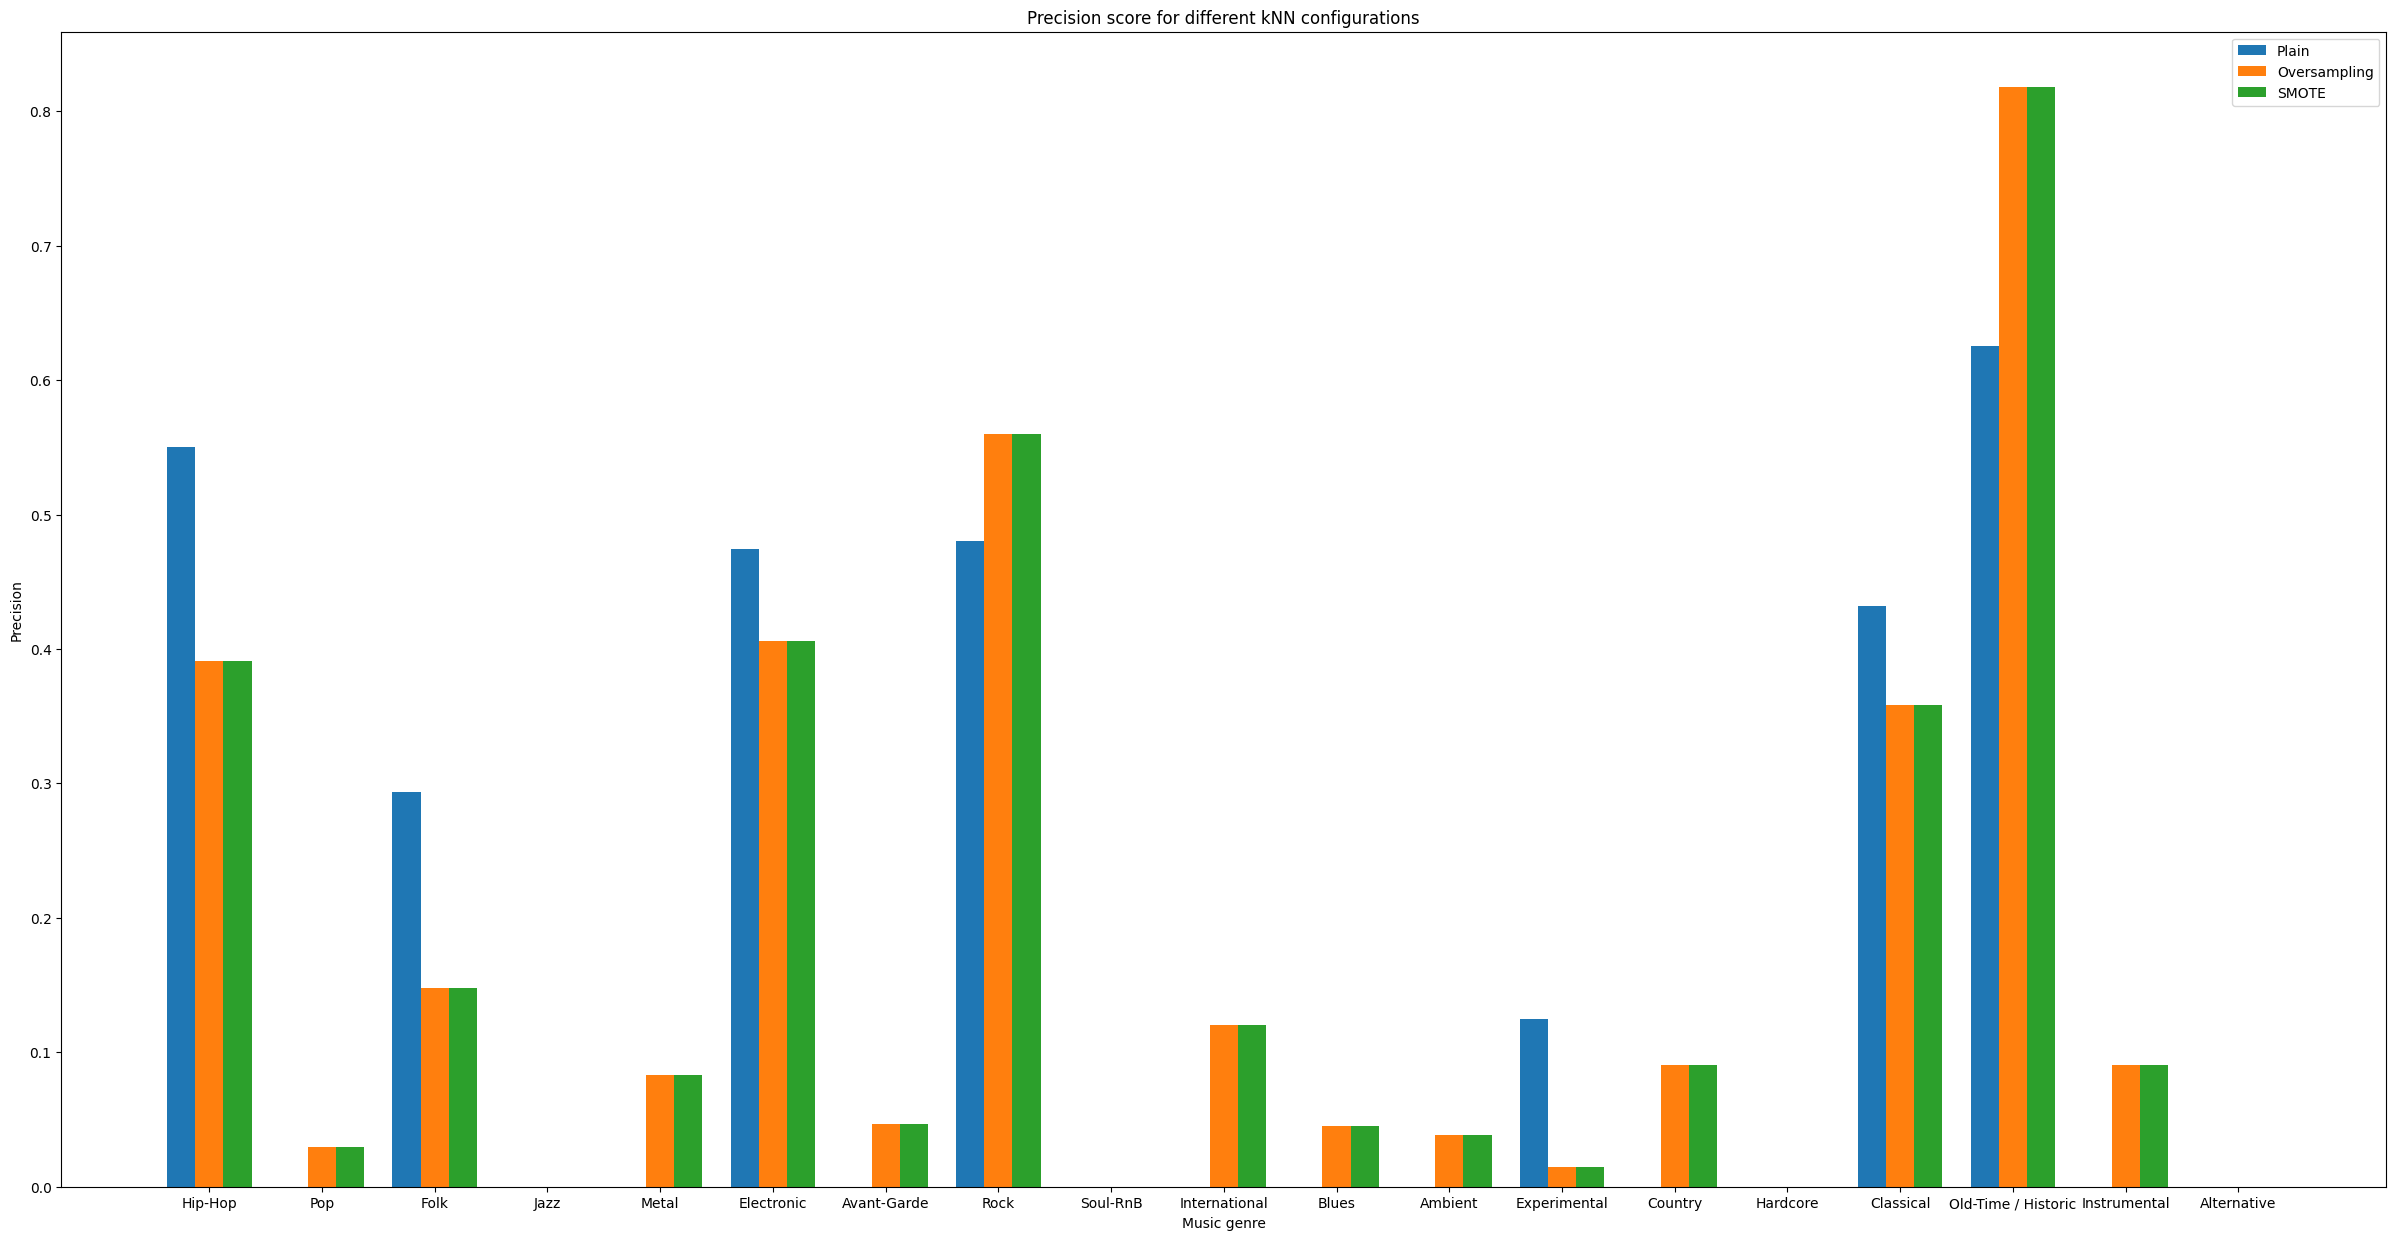

In [36]:
three_group_bar_plot(knn_precision, knn_precision_os, knn_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different kNN configurations", "Music genre", 
                    "Precision", legend_validation)

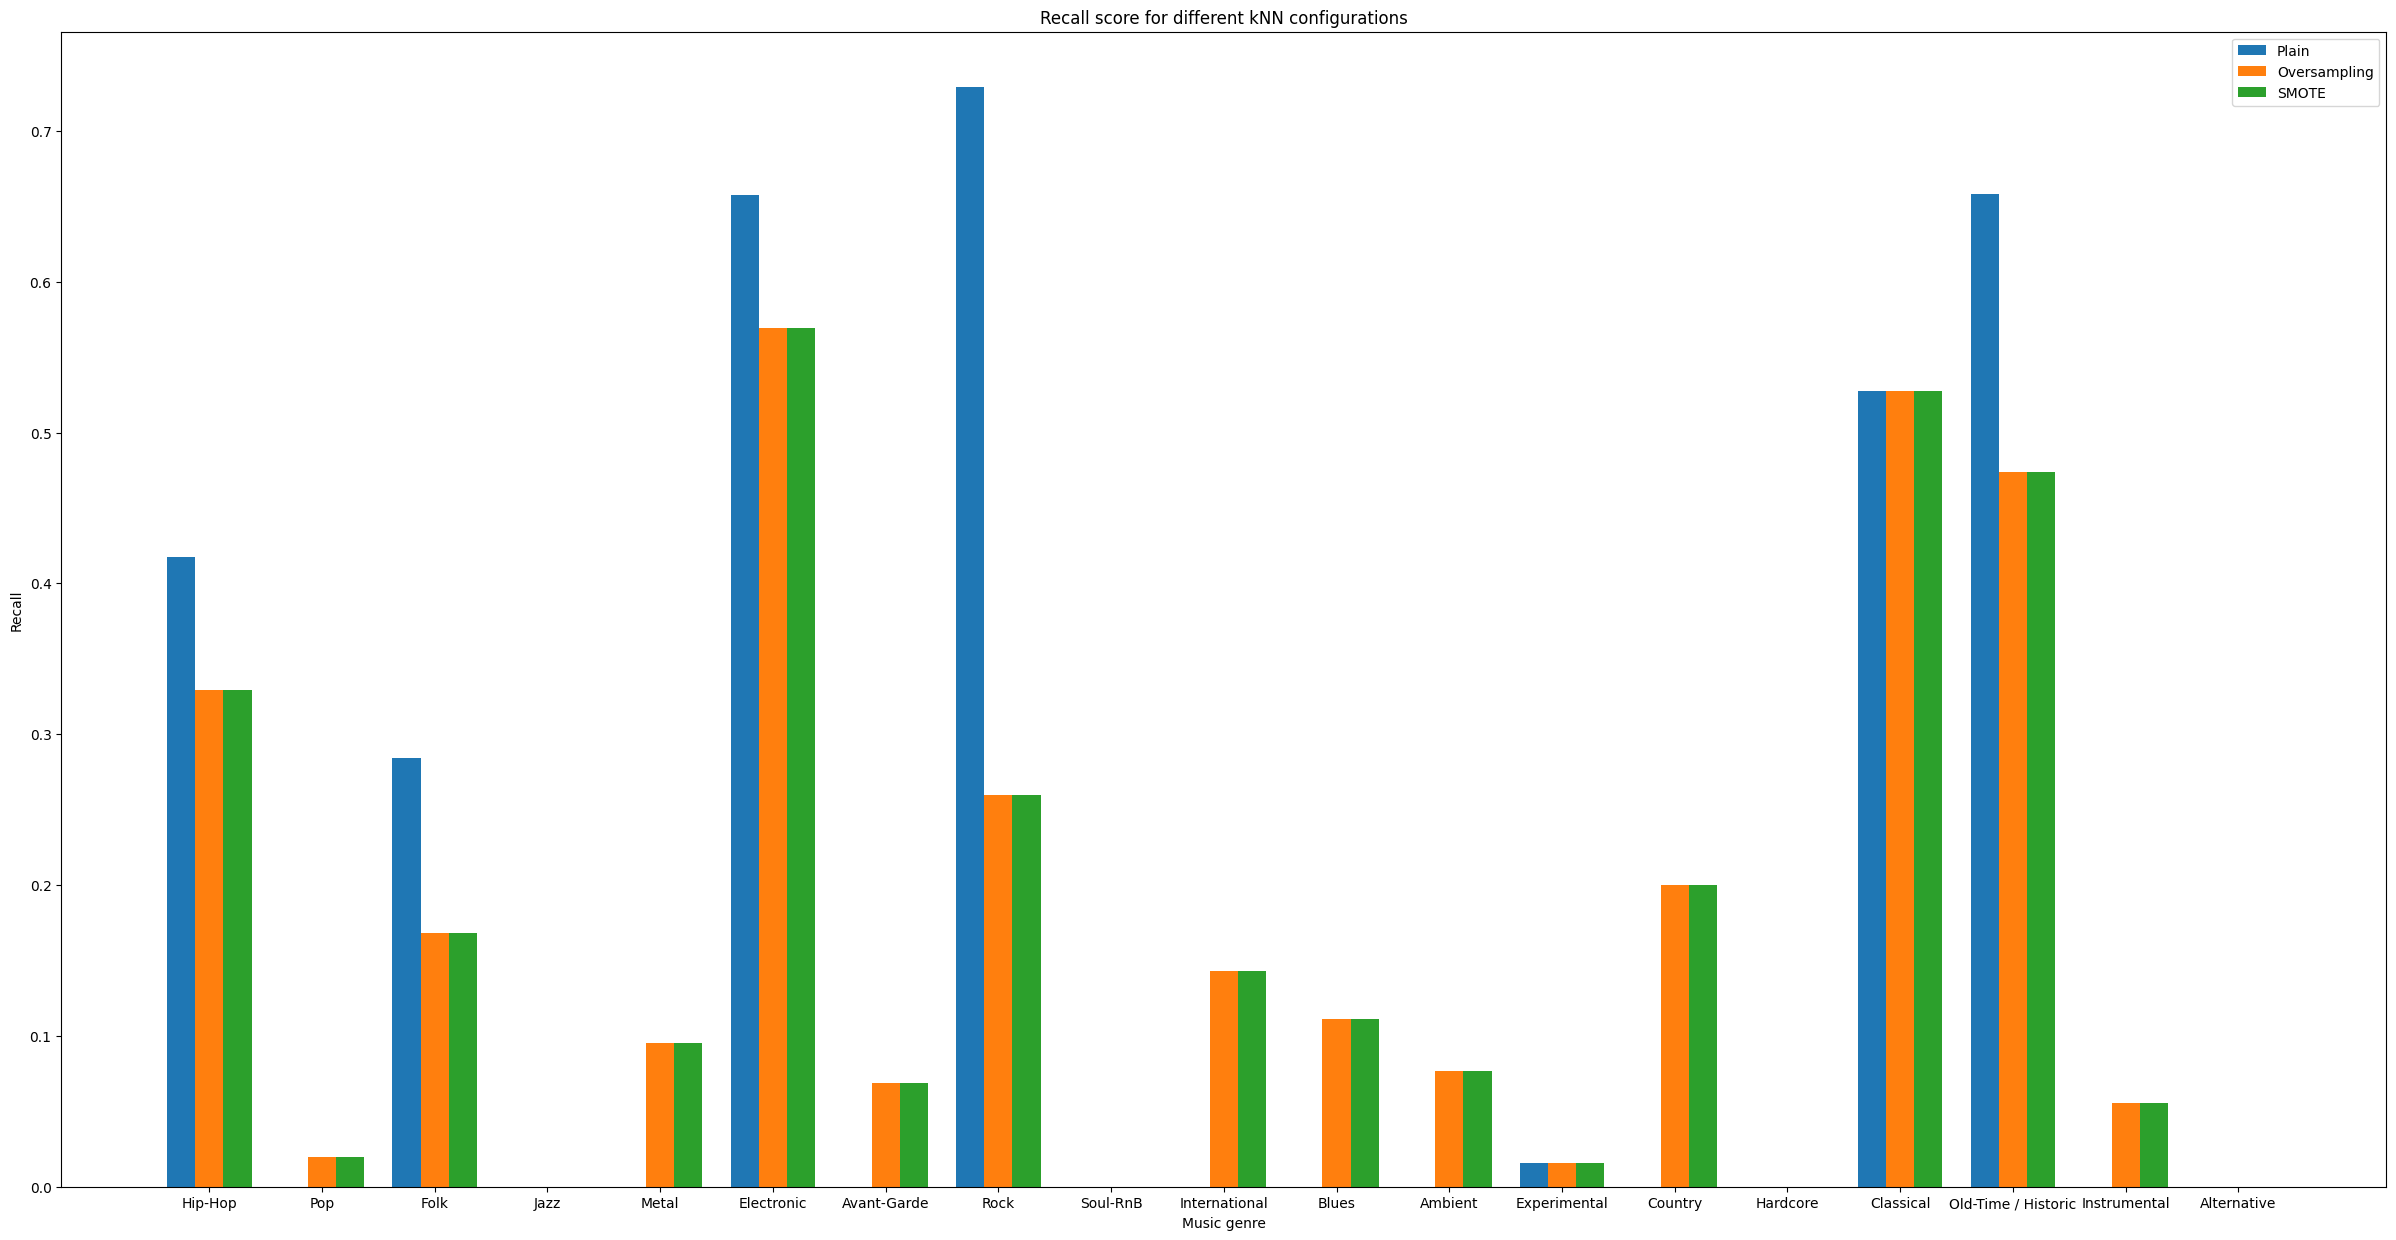

In [37]:
three_group_bar_plot(knn_recall, knn_recall_os, knn_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different kNN configurations", "Music genre", 
                    "Recall", legend_validation)

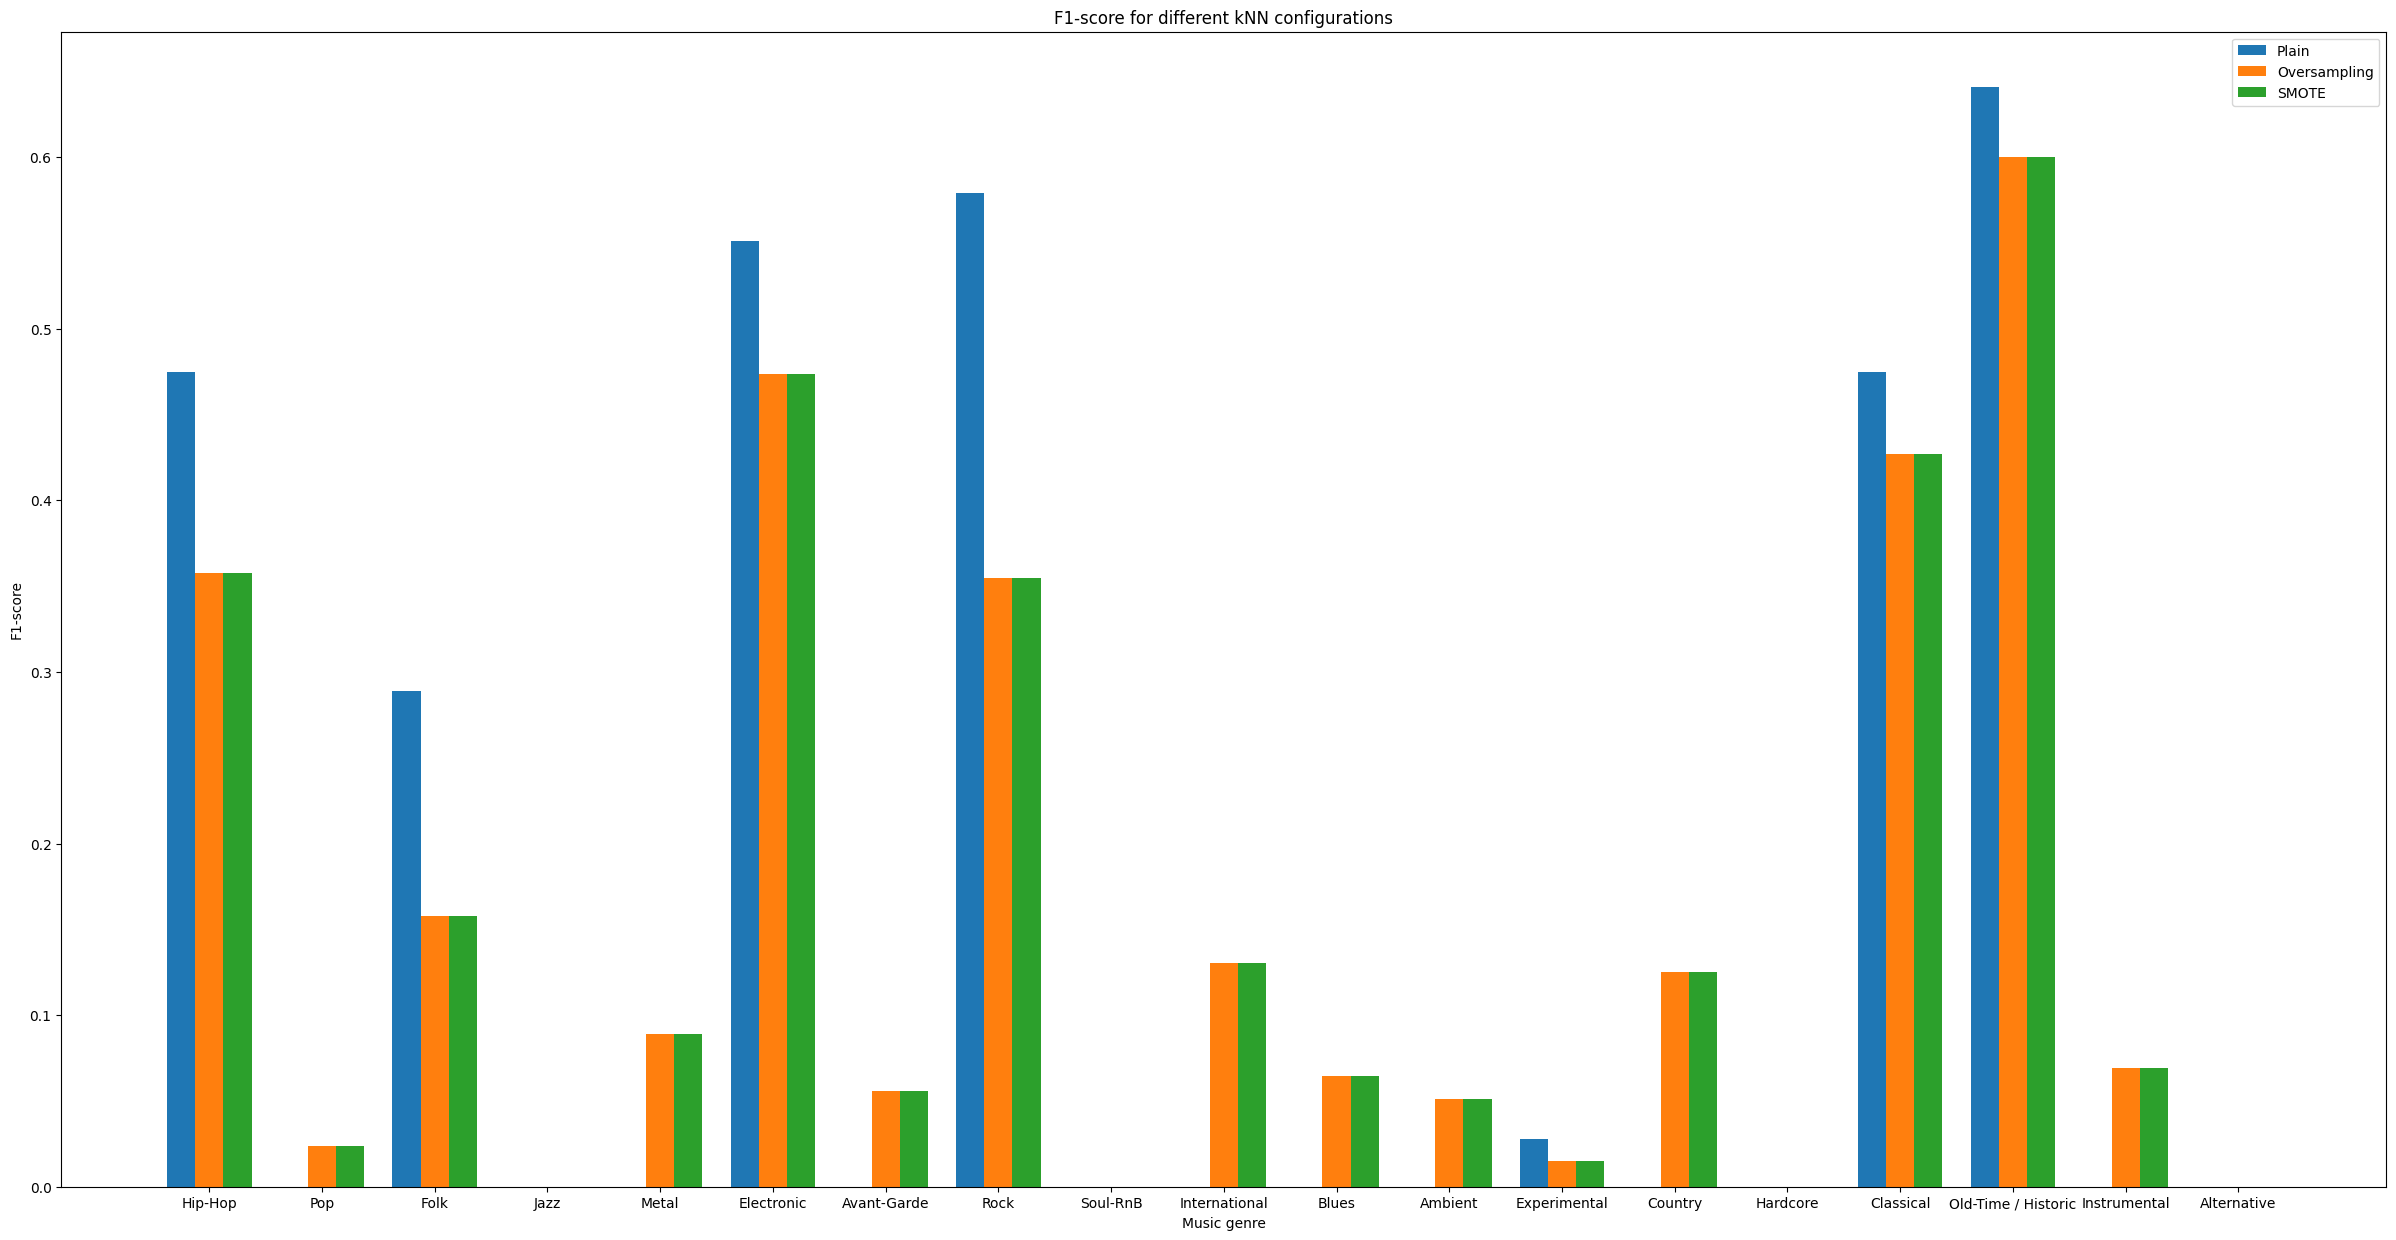

In [38]:
three_group_bar_plot(knn_f1, knn_f1_os, knn_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different kNN configurations", "Music genre", 
                    "F1-score", legend_validation)

### kNN on test set
Best case: SMOTE

In [38]:
orig_labels = le.inverse_transform(labels)
knn_clf = KNeighborsClassifier(n_neighbors=smote['kNN']['n_neighbours']).fit(X_train_smote, 
                                                                      y_train_smote)
knn_test_preds = knn_clf.predict(X_test)
knn_results_test = compute_class_metrics(
    predictions=le.inverse_transform(knn_test_preds), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

knn_report_test = knn_results_test[0]
knn_precision_test = knn_results_test[1]
knn_recall_test = knn_results_test[2]
knn_f1_test = knn_results_test[3]

In [39]:
pca = PCA(n_components=smote_pca['kNN']['n_components'])
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=smote_pca['kNN']['n_neighbours']).fit(X_train_smote, 
                                                                      y_train_smote)
knn_test_preds_pca = knn_clf.predict(X_test)
knn_results_test_pca = compute_class_metrics(
    predictions=le.inverse_transform(knn_test_preds_pca), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

knn_report_test_pca = knn_results_test_pca[0]
knn_precision_test_pca = knn_results_test_pca[1]
knn_recall_test_pca = knn_results_test_pca[2]
knn_f1_test_pca = knn_results_test_pca[3]


In [41]:
knn_clf = KNeighborsClassifier(n_neighbors=smote['kNN']['n_neighbours']).fit(X_train_fs, 
                                                                      y_train_fs)
knn_test_preds_fs = knn_clf.predict(X_test_fs)
knn_results_test_fs = compute_class_metrics(
    predictions=le.inverse_transform(knn_test_preds_fs), 
    y_set=le.inverse_transform(y_test_fs), 
    labels=orig_labels
)

knn_report_test_fs = knn_results_test_fs[0]
knn_precision_test_fs = knn_results_test_fs[1]
knn_recall_test_fs = knn_results_test_fs[2]
knn_f1_test_fs = knn_results_test_fs[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

In [42]:
knn_report_test

{'Hip-Hop': {'precision': 0.47107438016528924,
  'recall': 0.3333333333333333,
  'f1-score': 0.3904109589041096,
  'support': 171},
 'Pop': {'precision': 0.19230769230769232,
  'recall': 0.15873015873015872,
  'f1-score': 0.17391304347826086,
  'support': 63},
 'Folk': {'precision': 0.27884615384615385,
  'recall': 0.25,
  'f1-score': 0.2636363636363636,
  'support': 116},
 'Jazz': {'precision': 0.11904761904761904,
  'recall': 0.11363636363636363,
  'f1-score': 0.11627906976744186,
  'support': 44},
 'Metal': {'precision': 0.10526315789473684,
  'recall': 0.16666666666666666,
  'f1-score': 0.12903225806451615,
  'support': 36},
 'Electronic': {'precision': 0.4673913043478261,
  'recall': 0.39814814814814814,
  'f1-score': 0.42999999999999994,
  'support': 432},
 'Avant-Garde': {'precision': 0.028169014084507043,
  'recall': 0.08333333333333333,
  'f1-score': 0.042105263157894736,
  'support': 24},
 'Rock': {'precision': 0.591304347826087,
  'recall': 0.19154929577464788,
  'f1-score':

In [43]:
knn_report_test_pca

{'Hip-Hop': {'precision': 0.47107438016528924,
  'recall': 0.3333333333333333,
  'f1-score': 0.3904109589041096,
  'support': 171},
 'Pop': {'precision': 0.19230769230769232,
  'recall': 0.15873015873015872,
  'f1-score': 0.17391304347826086,
  'support': 63},
 'Folk': {'precision': 0.27884615384615385,
  'recall': 0.25,
  'f1-score': 0.2636363636363636,
  'support': 116},
 'Jazz': {'precision': 0.11904761904761904,
  'recall': 0.11363636363636363,
  'f1-score': 0.11627906976744186,
  'support': 44},
 'Metal': {'precision': 0.10526315789473684,
  'recall': 0.16666666666666666,
  'f1-score': 0.12903225806451615,
  'support': 36},
 'Electronic': {'precision': 0.4673913043478261,
  'recall': 0.39814814814814814,
  'f1-score': 0.42999999999999994,
  'support': 432},
 'Avant-Garde': {'precision': 0.028169014084507043,
  'recall': 0.08333333333333333,
  'f1-score': 0.042105263157894736,
  'support': 24},
 'Rock': {'precision': 0.591304347826087,
  'recall': 0.19154929577464788,
  'f1-score':

In [44]:
knn_report_test_fs

{'Hip-Hop': {'precision': 0.43661971830985913,
  'recall': 0.36257309941520466,
  'f1-score': 0.39616613418530344,
  'support': 171},
 'Pop': {'precision': 0.13636363636363635,
  'recall': 0.09523809523809523,
  'f1-score': 0.11214953271028037,
  'support': 63},
 'Folk': {'precision': 0.25,
  'recall': 0.21551724137931033,
  'f1-score': 0.23148148148148148,
  'support': 116},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44},
 'Metal': {'precision': 0.21428571428571427,
  'recall': 0.16666666666666666,
  'f1-score': 0.1875,
  'support': 36},
 'Electronic': {'precision': 0.44194107452339687,
  'recall': 0.5902777777777778,
  'f1-score': 0.5054509415262637,
  'support': 432},
 'Avant-Garde': {'precision': 0.04,
  'recall': 0.08333333333333333,
  'f1-score': 0.05405405405405406,
  'support': 24},
 'Rock': {'precision': 0.5233644859813084,
  'recall': 0.3154929577464789,
  'f1-score': 0.3936731107205624,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 

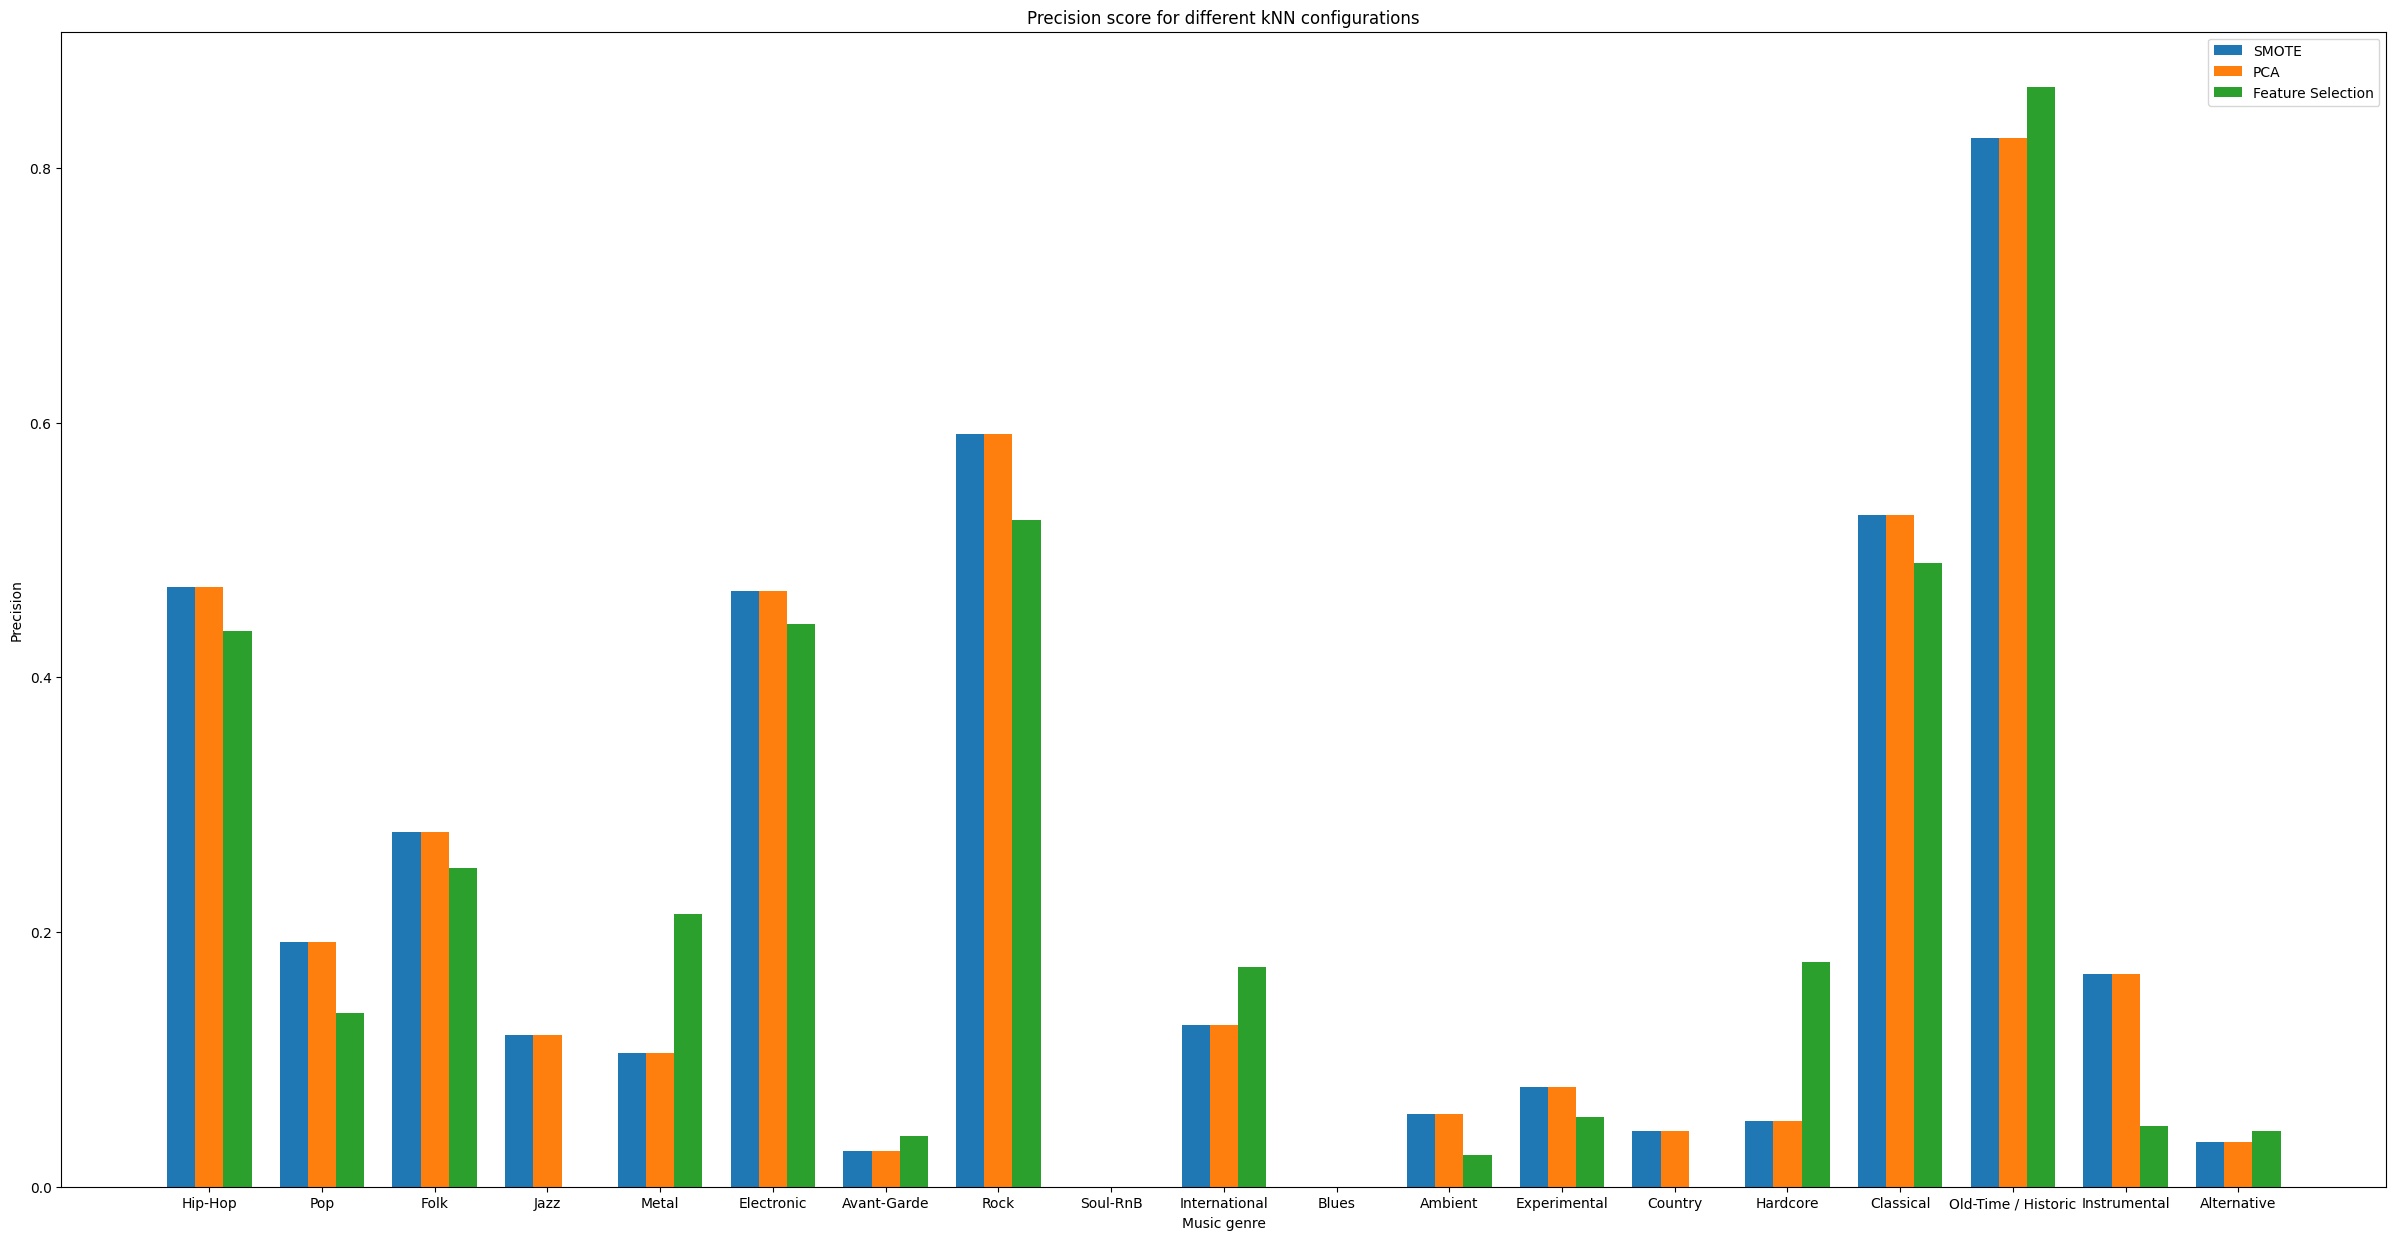

In [45]:
three_group_bar_plot(knn_precision_test, knn_precision_test_pca, knn_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different kNN configurations", "Music genre", 
                    "Precision", ["SMOTE"]+legend_test)

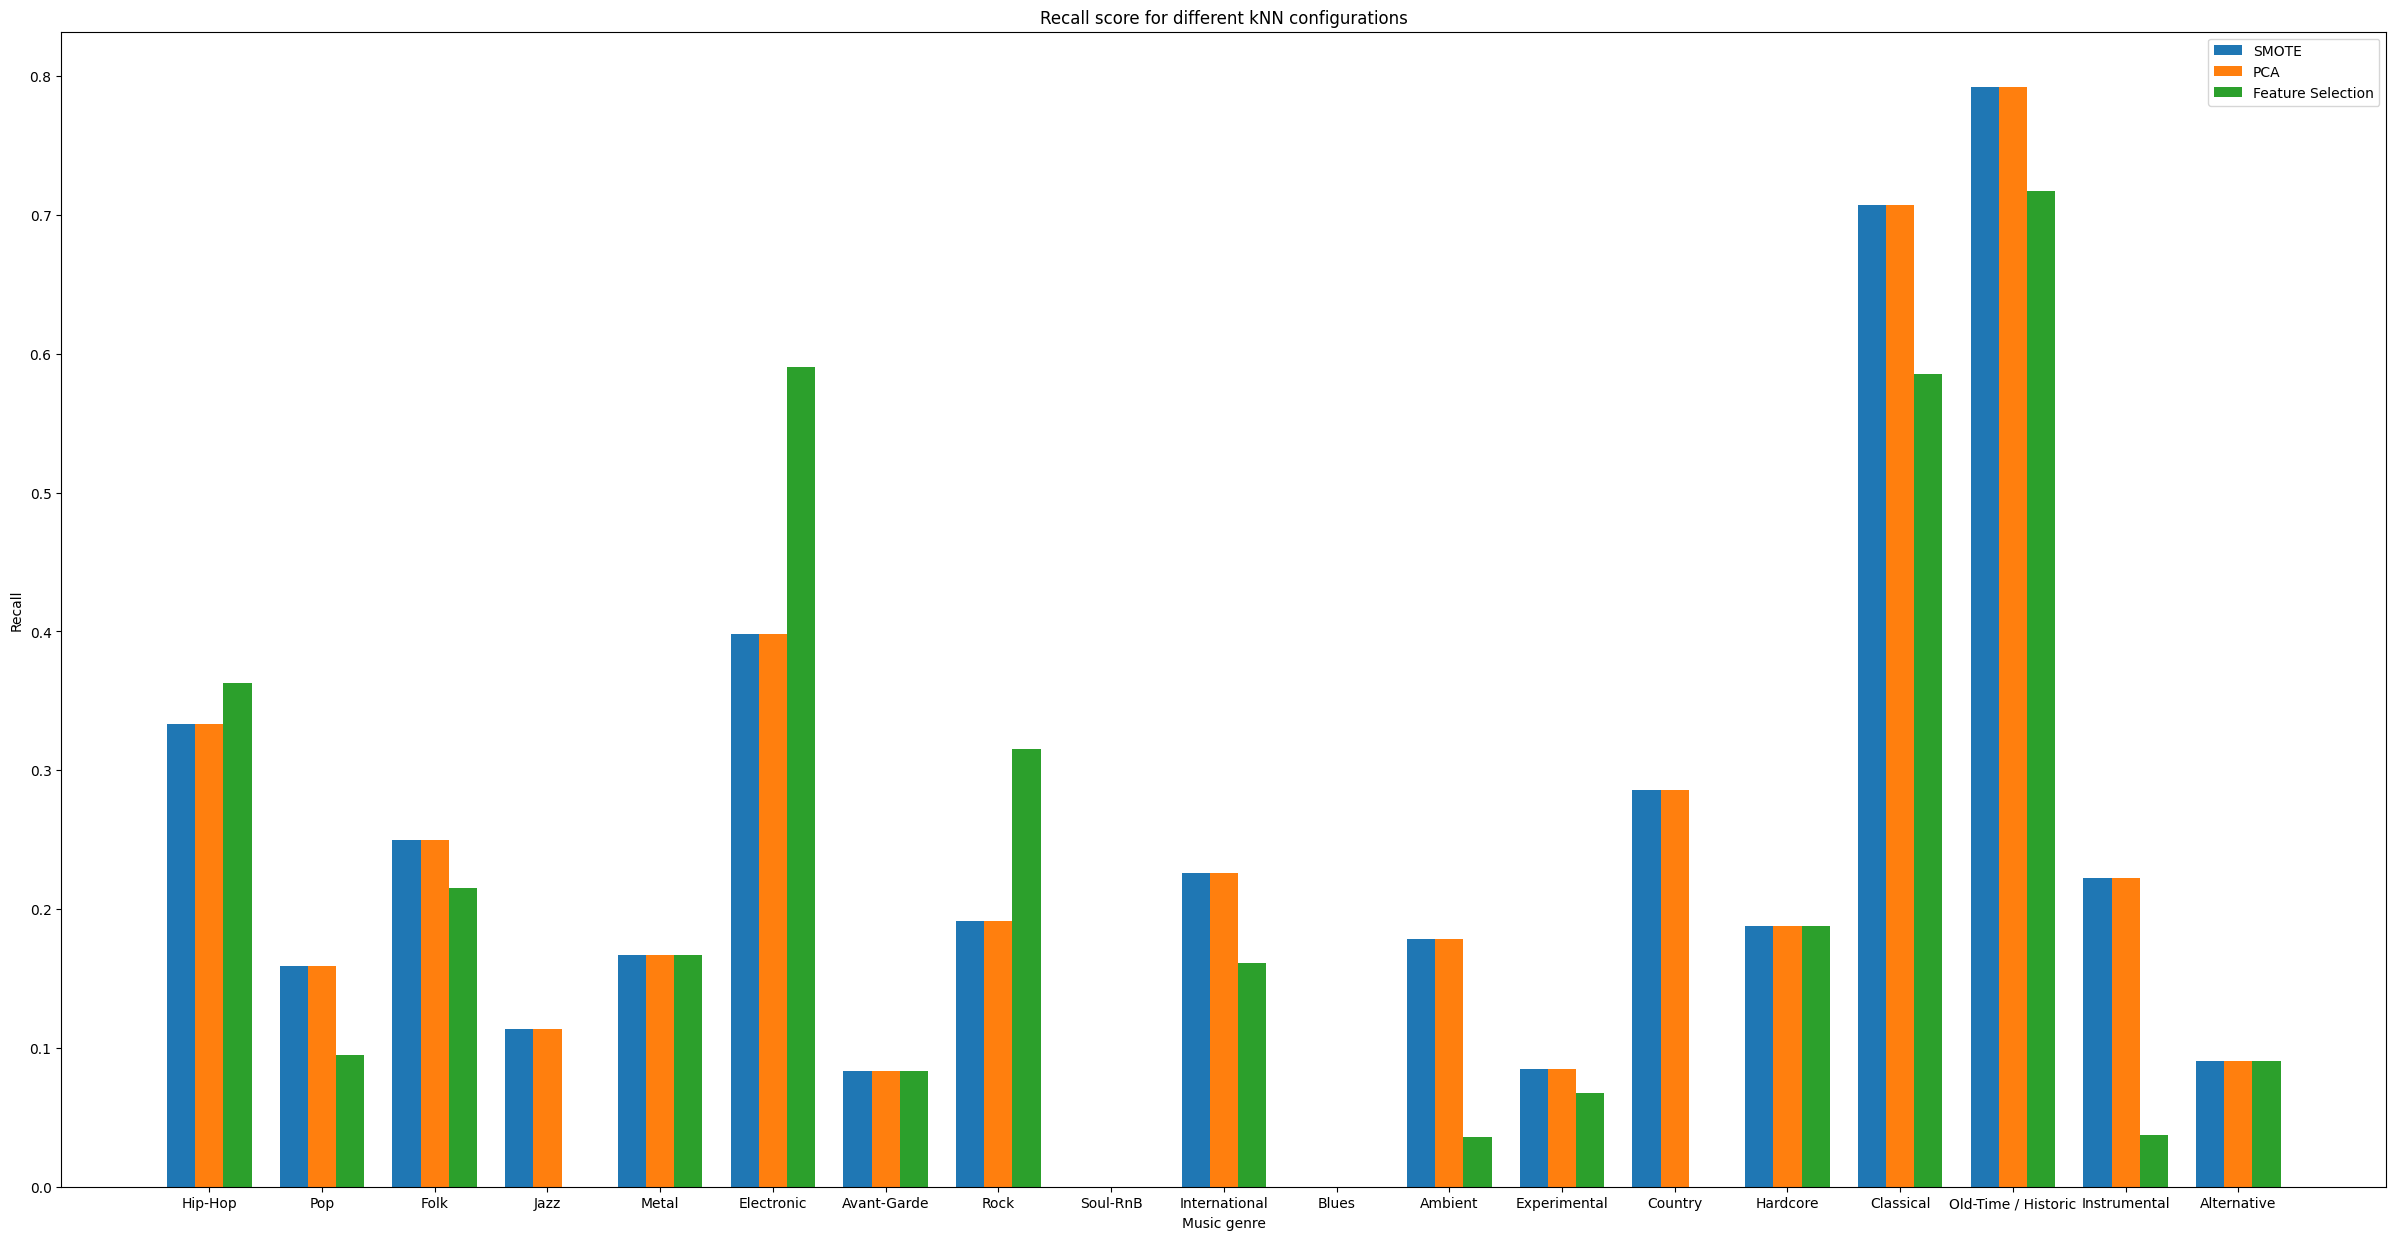

In [46]:
three_group_bar_plot(knn_recall_test, knn_recall_test_pca, knn_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different kNN configurations", "Music genre", 
                    "Recall", ["SMOTE"]+legend_test)

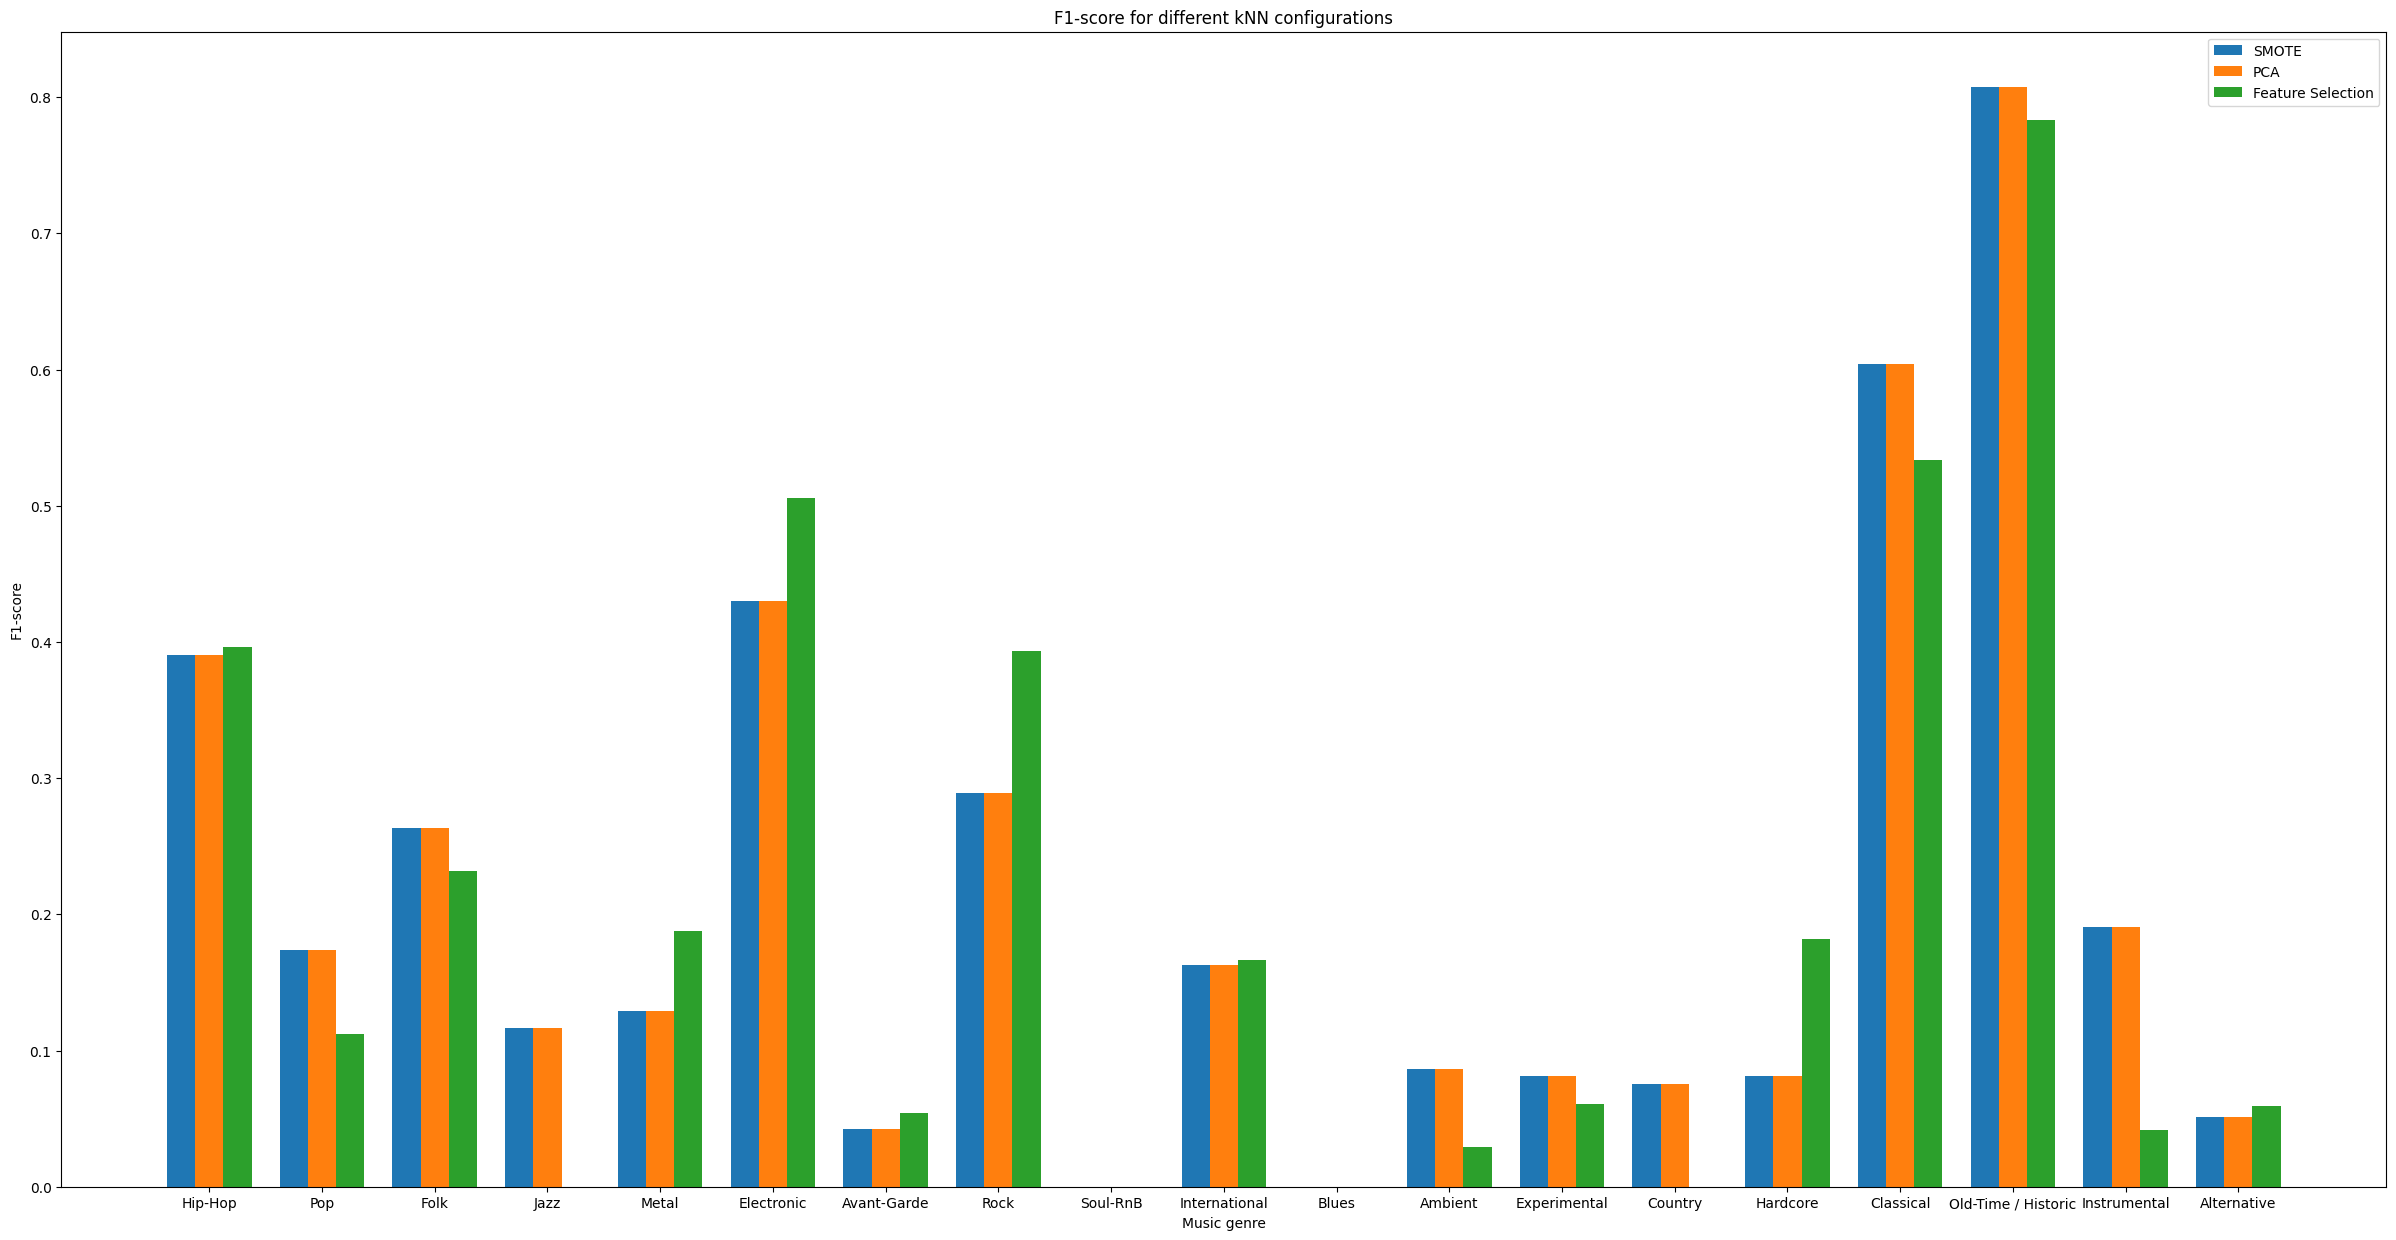

In [47]:
three_group_bar_plot(knn_f1_test, knn_f1_test_pca, knn_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different kNN configurations", "Music genre", 
                    "F1-score", ["SMOTE"]+legend_test)

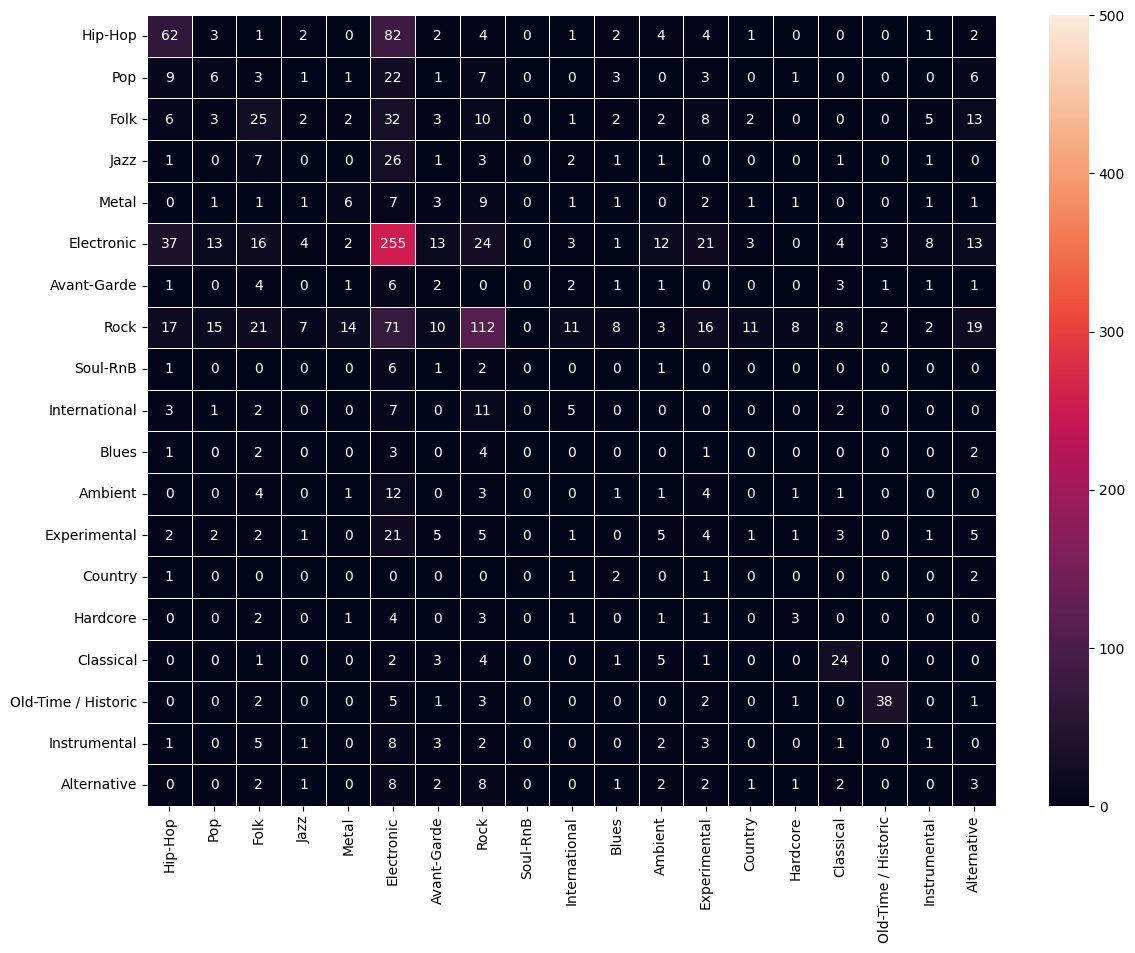

In [75]:
# Confusion matrix
knn_cm_test = confusion_matrix(y_test_fs, knn_test_preds_fs, labels=labels)
print_cm(knn_cm_test, orig_labels, "Confusion matrix for kNN")

## MLP classification

### MLP without tweaks

In [39]:
mlp_clf = MLPClassifier(solver='adam', alpha=plain['MLP']['alpha'], 
                        hidden_layer_sizes=(plain['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train, y_train)
mlp_val_predict = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results = compute_class_metrics(predictions=le.inverse_transform(mlp_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
mlp_report = mlp_results[0]
mlp_precision = mlp_results[1]
mlp_recall = mlp_results[2]
mlp_f1 = mlp_results[3]

------------------------------ MLP completed ------------------------------


### MLP with oversampling

In [40]:
mlp_clf = MLPClassifier(solver='adam', alpha=overs['MLP']['alpha'], 
                        hidden_layer_sizes=(overs['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_os, y_train_os)

mlp_val_predict_os = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results_os = compute_class_metrics(predictions=le.inverse_transform(mlp_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
mlp_report_os = mlp_results_os[0]
mlp_precision_os = mlp_results_os[1]
mlp_recall_os = mlp_results_os[2]
mlp_f1_os = mlp_results_os[3]

------------------------------ MLP oversampling completed ------------------------------


### MLP with SMOTE

In [41]:
mlp_clf = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_smote, y_train_smote)

mlp_val_predict_smote = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results_smote = compute_class_metrics(
    predictions=le.inverse_transform(mlp_val_predict_smote), 
    y_set=le.inverse_transform(y_validate), 
    labels=le.inverse_transform(labels))

mlp_report_smote = mlp_results_smote[0]
mlp_precision_smote = mlp_results_smote[1]
mlp_recall_smote = mlp_results_smote[2]
mlp_f1_smote = mlp_results_smote[3]

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


------------------------------ MLP SMOTE completed ------------------------------


### Metrics comparison for MLP

In [42]:
print("-------------------------------- Metrics without tweaks --------------------------------")
mlp_report

-------------------------------- Metrics without tweaks --------------------------------


{'Hip-Hop': {'precision': 0.39751552795031053,
  'recall': 0.4050632911392405,
  'f1-score': 0.4012539184952978,
  'support': 158},
 'Pop': {'precision': 0.09803921568627451,
  'recall': 0.09803921568627451,
  'f1-score': 0.09803921568627451,
  'support': 51},
 'Folk': {'precision': 0.2323943661971831,
  'recall': 0.3473684210526316,
  'f1-score': 0.27848101265822783,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.1111111111111111,
  'recall': 0.14285714285714285,
  'f1-score': 0.125,
  'support': 21},
 'Electronic': {'precision': 0.41923076923076924,
  'recall': 0.5491183879093199,
  'f1-score': 0.4754634678298801,
  'support': 397},
 'Avant-Garde': {'precision': 0.06666666666666667,
  'recall': 0.06896551724137931,
  'f1-score': 0.06779661016949153,
  'support': 29},
 'Rock': {'precision': 0.48951048951048953,
  'recall': 0.19337016574585636,
  'f1-score': 0.27722772277227725,
  'support': 362},
 'Soul-RnB': {'p

In [43]:
print("------------------------------ Metrics with oversampling ------------------------------")
mlp_report_os

------------------------------ Metrics with oversampling ------------------------------


{'Hip-Hop': {'precision': 0.3953488372093023,
  'recall': 0.3227848101265823,
  'f1-score': 0.3554006968641115,
  'support': 158},
 'Pop': {'precision': 0.0625,
  'recall': 0.058823529411764705,
  'f1-score': 0.06060606060606061,
  'support': 51},
 'Folk': {'precision': 0.23232323232323232,
  'recall': 0.24210526315789474,
  'f1-score': 0.23711340206185566,
  'support': 95},
 'Jazz': {'precision': 0.02040816326530612,
  'recall': 0.05714285714285714,
  'f1-score': 0.030075187969924807,
  'support': 35},
 'Metal': {'precision': 0.0425531914893617,
  'recall': 0.09523809523809523,
  'f1-score': 0.0588235294117647,
  'support': 21},
 'Electronic': {'precision': 0.4483695652173913,
  'recall': 0.4156171284634761,
  'f1-score': 0.43137254901960786,
  'support': 397},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 29},
 'Rock': {'precision': 0.5034246575342466,
  'recall': 0.40607734806629836,
  'f1-score': 0.4495412844036697,
  'support': 362},
 'Soul-Rn

In [44]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
mlp_report_smote

-------------------------------- Metrics with SMOTE --------------------------------


{'Hip-Hop': {'precision': 0.3163265306122449,
  'recall': 0.3924050632911392,
  'f1-score': 0.35028248587570626,
  'support': 158},
 'Pop': {'precision': 0.025,
  'recall': 0.0196078431372549,
  'f1-score': 0.021978021978021976,
  'support': 51},
 'Folk': {'precision': 0.24050632911392406,
  'recall': 0.2,
  'f1-score': 0.21839080459770116,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.4700460829493088,
  'recall': 0.5138539042821159,
  'f1-score': 0.49097472924187724,
  'support': 397},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 29},
 'Rock': {'precision': 0.4697674418604651,
  'recall': 0.5580110497237569,
  'f1-score': 0.51010101010101,
  'support': 362},
 'Soul-RnB': {'precision': 0.16666666666666666,
  'recall': 0.15384615384615385,
  'f1-score': 0.16,
  'support': 13},
 'International':

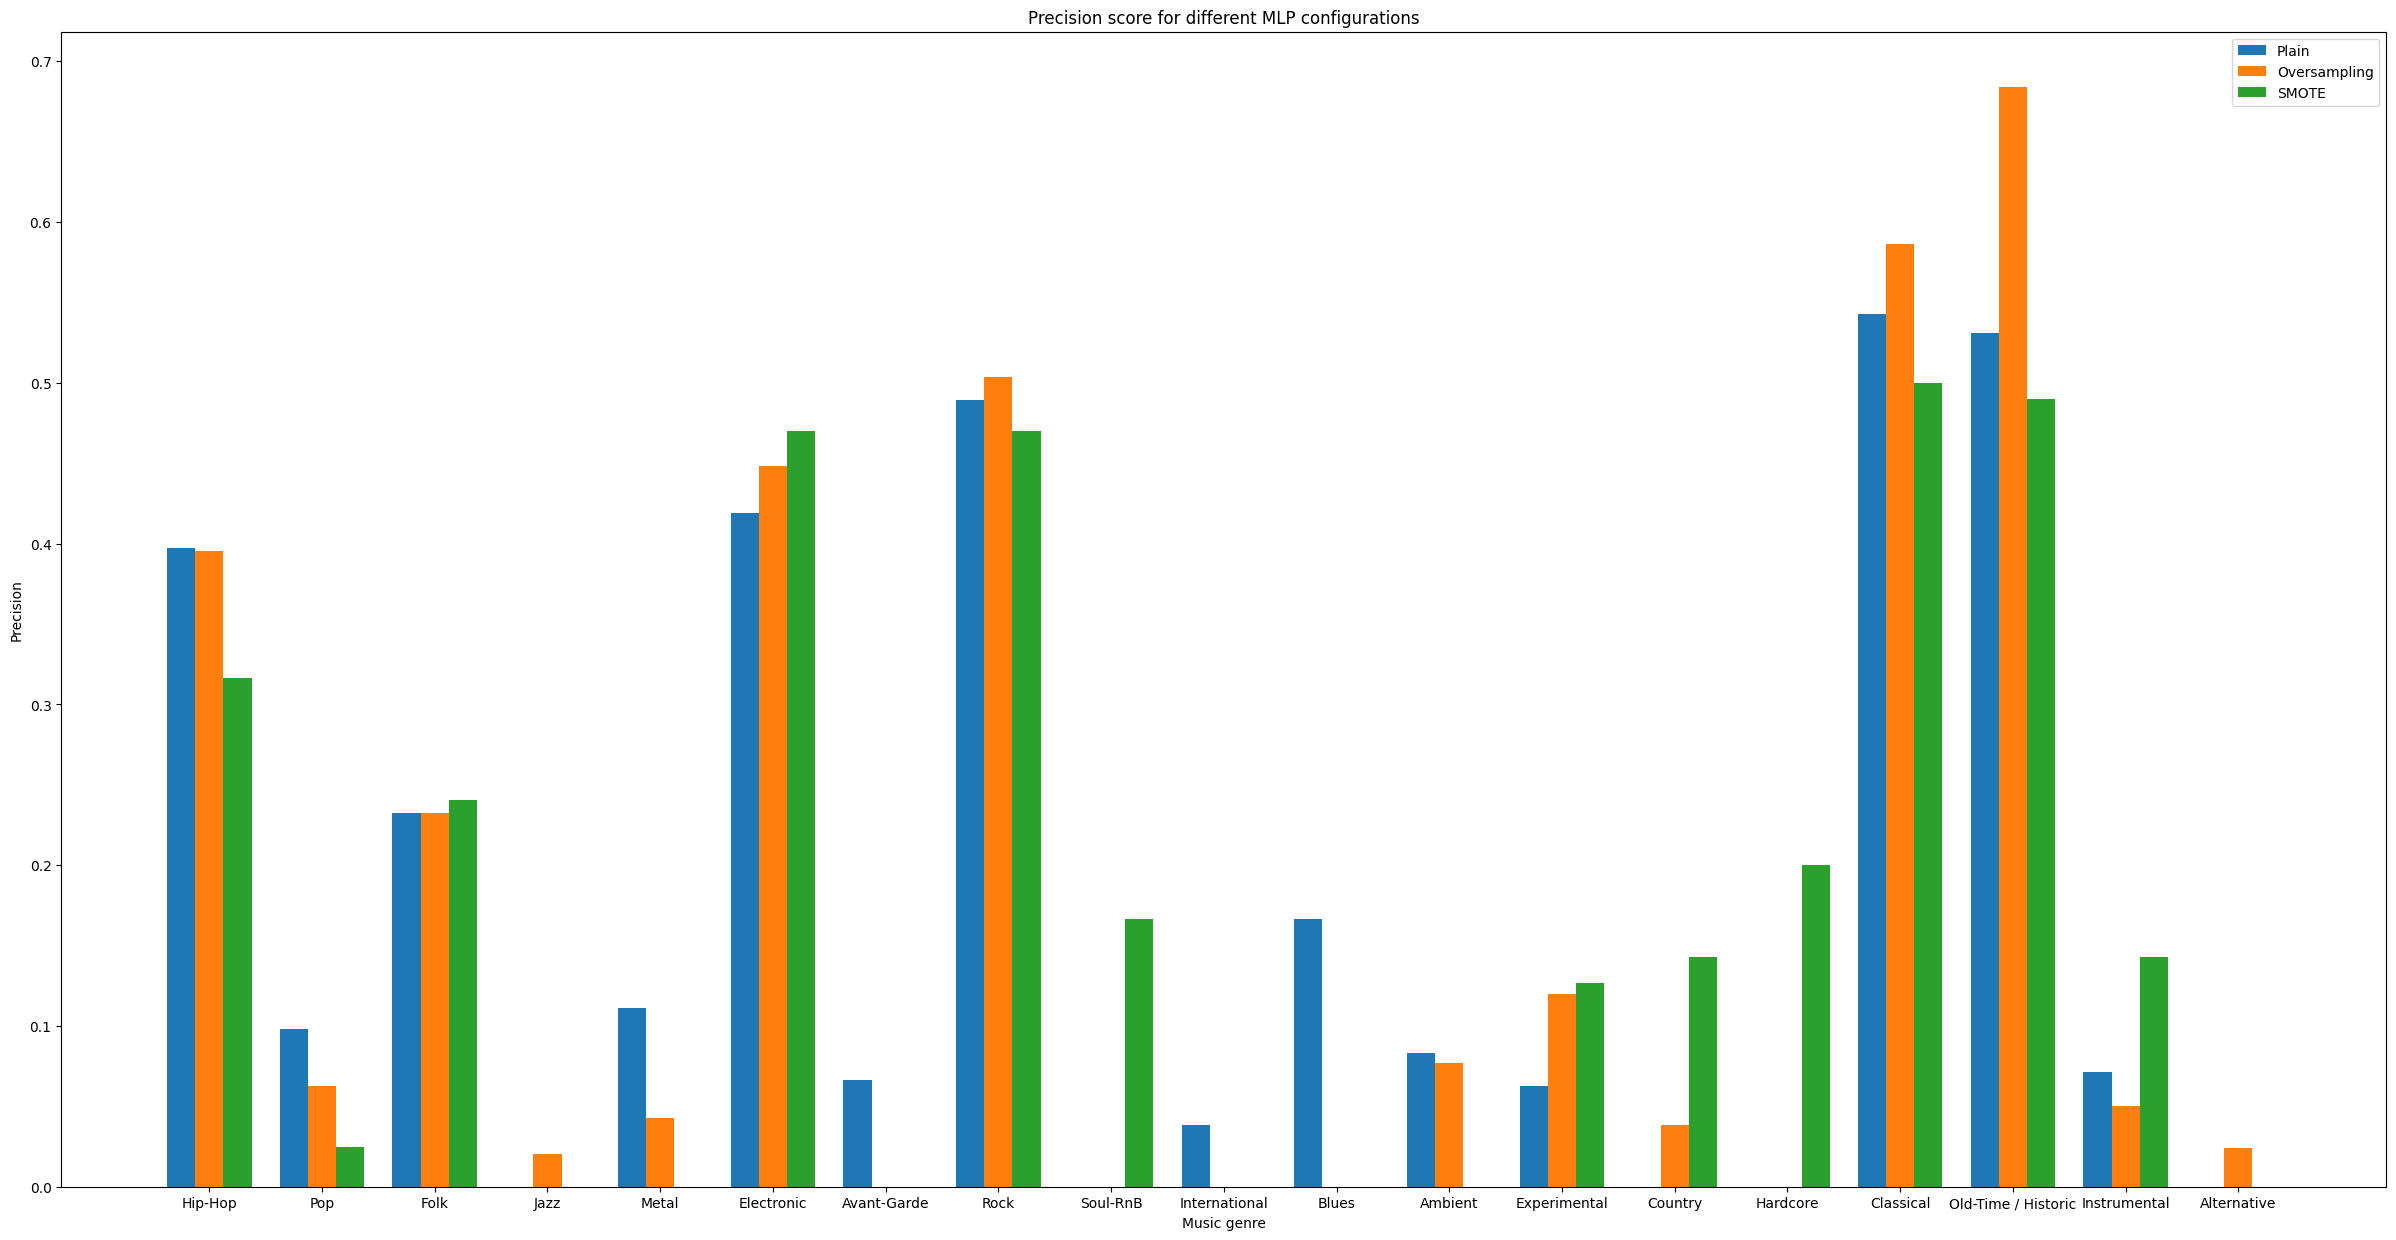

In [45]:
three_group_bar_plot(mlp_precision, mlp_precision_os, mlp_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different MLP configurations", "Music genre", 
                    "Precision", legend_validation)

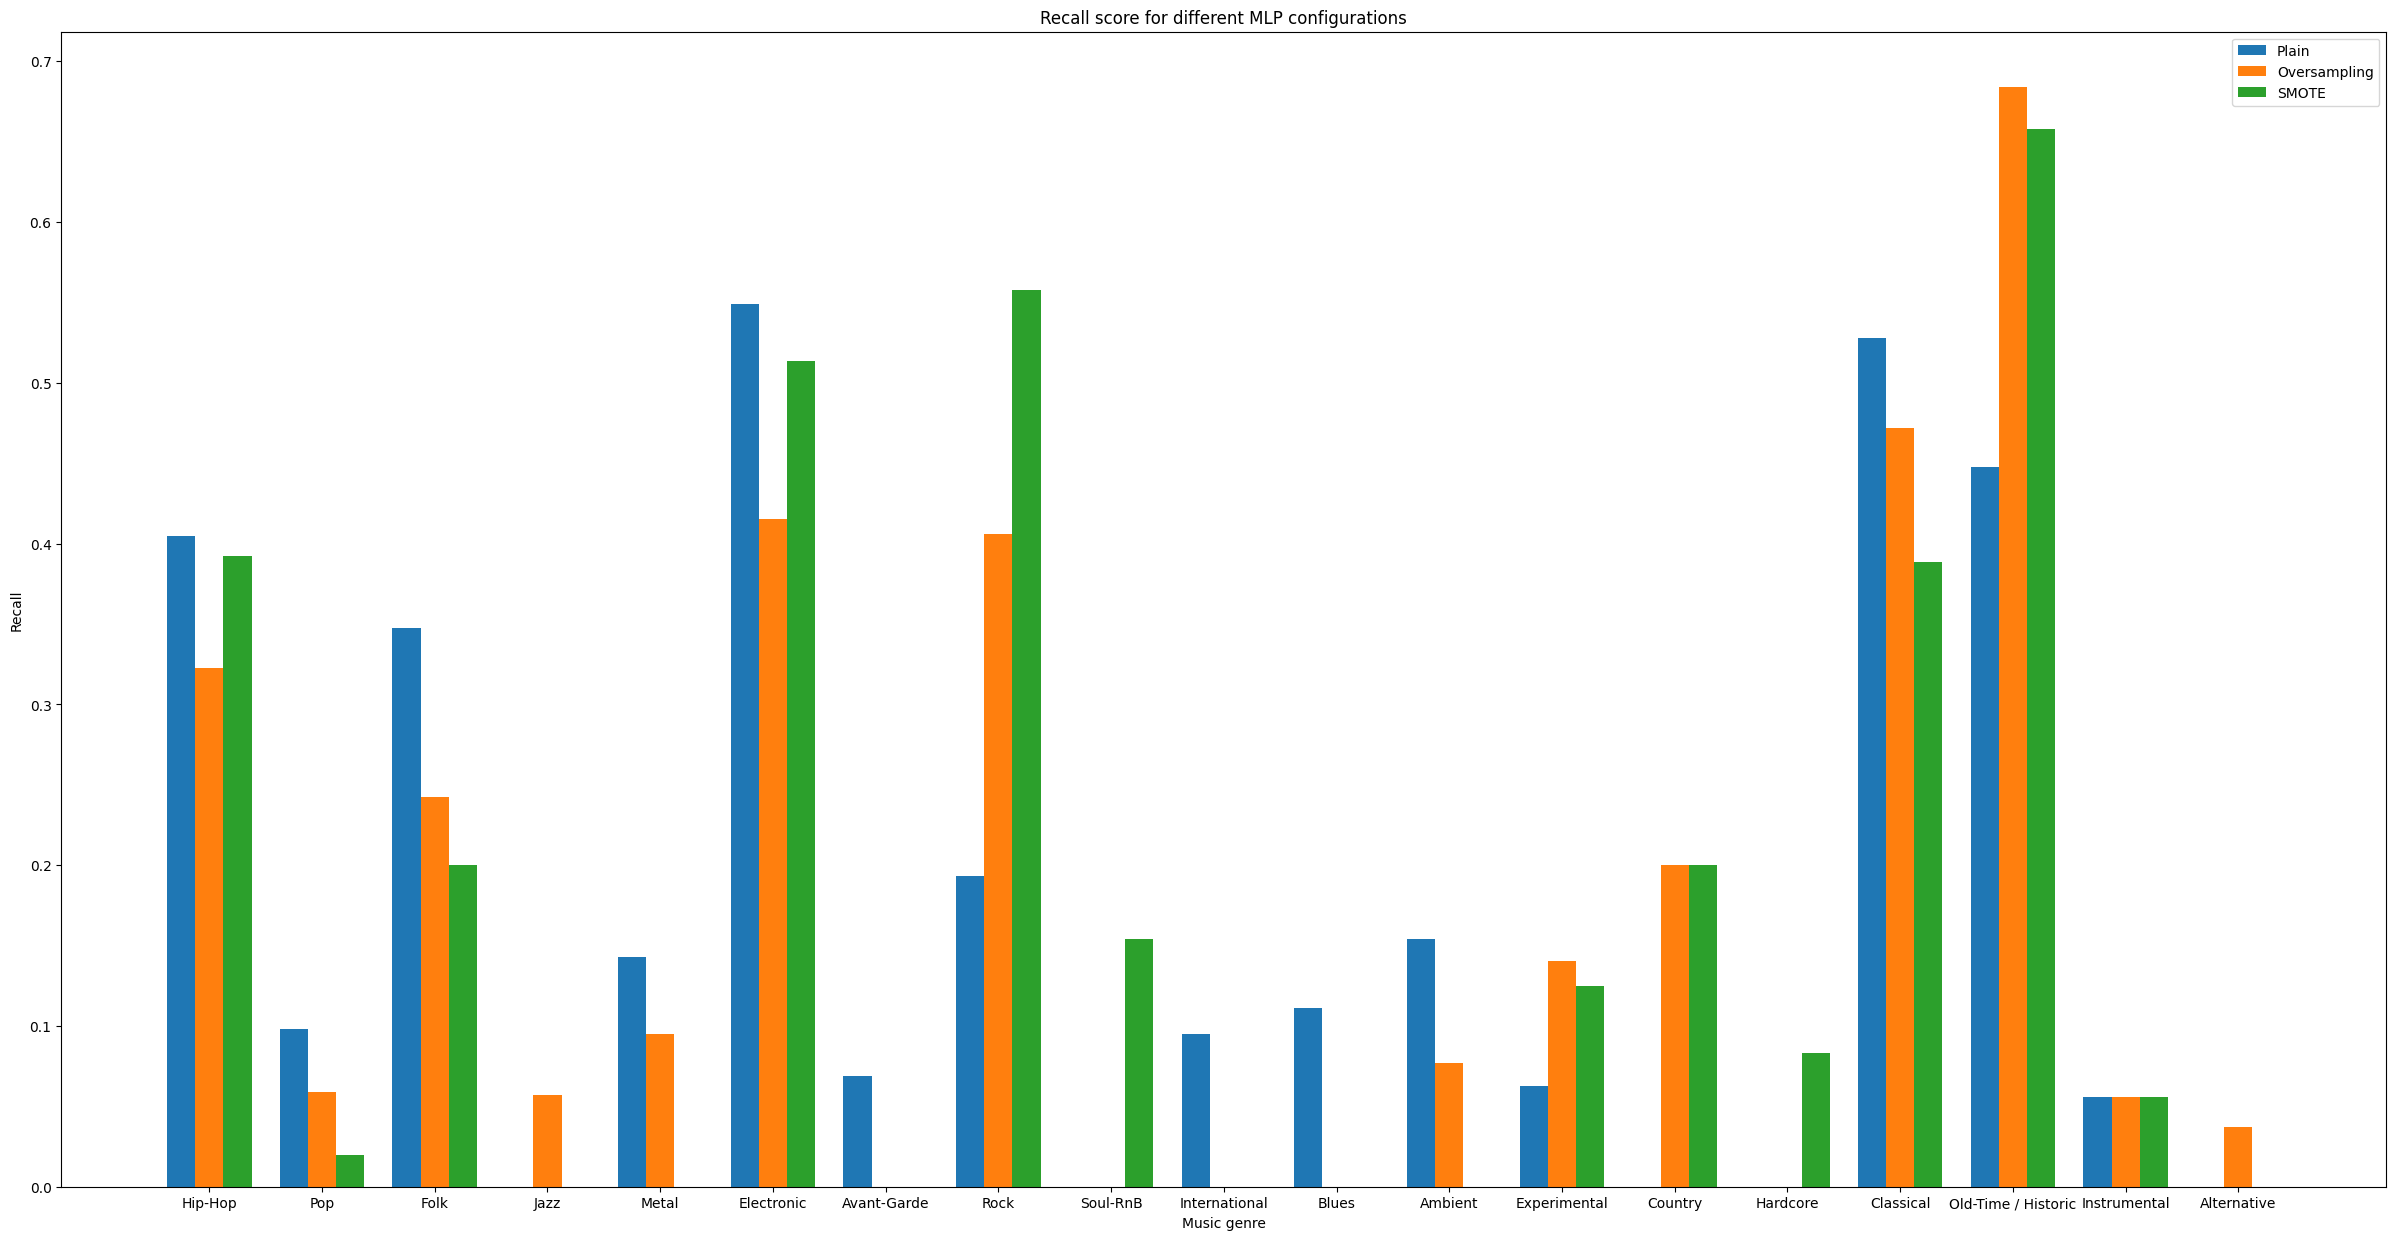

In [46]:
three_group_bar_plot(mlp_recall, mlp_recall_os, mlp_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different MLP configurations", "Music genre", 
                    "Recall", legend_validation)

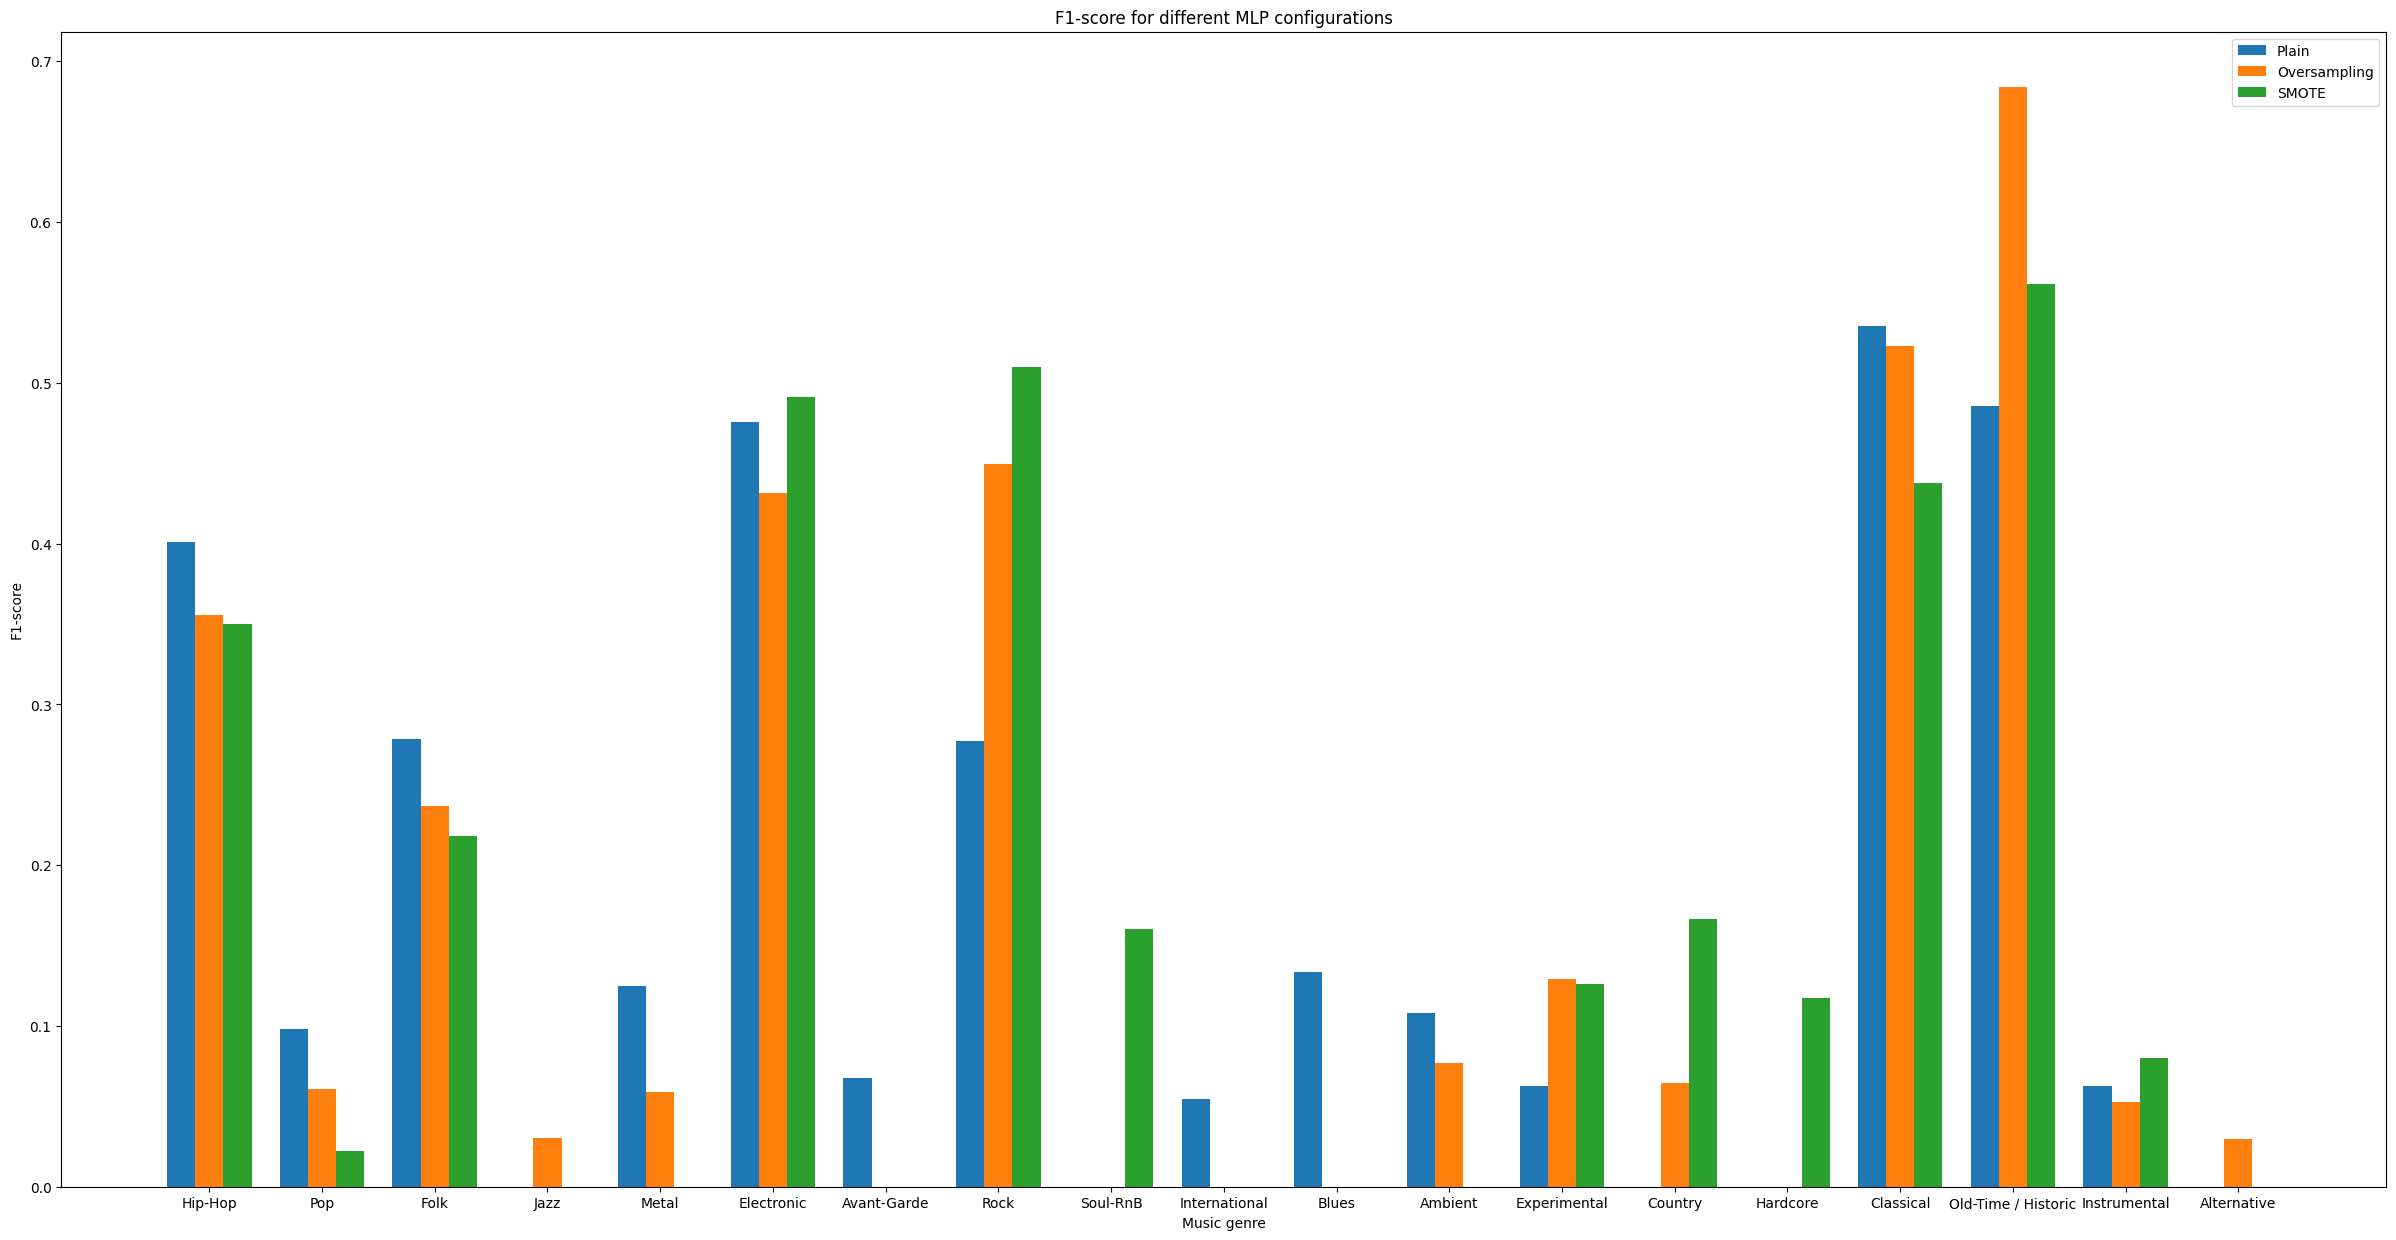

In [47]:
three_group_bar_plot(mlp_f1, mlp_f1_os, mlp_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different MLP configurations", "Music genre", 
                    "F1-score", legend_validation)

### MLP on test set
Best case: SMOTE

In [52]:
orig_labels = le.inverse_transform(labels)
    
mlp_clf = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_smote, y_train_smote)

mlp_test_preds = mlp_clf.predict(X_test)
mlp_results_test = compute_class_metrics(
    predictions=le.inverse_transform(mlp_test_preds), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

mlp_report_test = mlp_results_test[0]
mlp_precision_test = mlp_results_test[1]
mlp_recall_test = mlp_results_test[2]
mlp_f1_test = mlp_results_test[3]

In [55]:
pca = PCA(n_components=smote_pca['MLP']['n_components'])
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

mlp_clf = MLPClassifier(solver='adam', alpha=smote_pca['MLP']['alpha'], 
                        hidden_layer_sizes=(smote_pca['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_pca, y_train)

mlp_test_preds_pca = mlp_clf.predict(X_test_pca)
mlp_results_test_pca = compute_class_metrics(
    predictions=le.inverse_transform(mlp_test_preds_pca), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

mlp_report_test_pca = mlp_results_test_pca[0]
mlp_precision_test_pca = mlp_results_test_pca[1]
mlp_recall_test_pca = mlp_results_test_pca[2]
mlp_f1_test_pca = mlp_results_test_pca[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

In [57]:
mlp_clf = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_fs, y_train_fs)

mlp_test_preds_fs = mlp_clf.predict(X_test_fs)
mlp_results_test_fs = compute_class_metrics(
    predictions=le.inverse_transform(mlp_test_preds_fs), 
    y_set=le.inverse_transform(y_test_fs), 
    labels=orig_labels
)

mlp_report_test_fs = mlp_results_test_fs[0]
mlp_precision_test_fs = mlp_results_test_fs[1]
mlp_recall_test_fs = mlp_results_test_fs[2]
mlp_f1_test_fs = mlp_results_test_fs[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

In [58]:
mlp_report_test

{'Hip-Hop': {'precision': 0.4596774193548387,
  'recall': 0.6666666666666666,
  'f1-score': 0.5441527446300716,
  'support': 171},
 'Pop': {'precision': 0.16666666666666666,
  'recall': 0.031746031746031744,
  'f1-score': 0.05333333333333334,
  'support': 63},
 'Folk': {'precision': 0.6545454545454545,
  'recall': 0.3103448275862069,
  'f1-score': 0.4210526315789474,
  'support': 116},
 'Jazz': {'precision': 0.3333333333333333,
  'recall': 0.022727272727272728,
  'f1-score': 0.04255319148936171,
  'support': 44},
 'Metal': {'precision': 0.12962962962962962,
  'recall': 0.19444444444444445,
  'f1-score': 0.15555555555555556,
  'support': 36},
 'Electronic': {'precision': 0.5885416666666666,
  'recall': 0.26157407407407407,
  'f1-score': 0.36217948717948717,
  'support': 432},
 'Avant-Garde': {'precision': 0.11428571428571428,
  'recall': 0.16666666666666666,
  'f1-score': 0.13559322033898305,
  'support': 24},
 'Rock': {'precision': 0.375,
  'recall': 0.008450704225352112,
  'f1-score':

In [59]:
mlp_report_test_pca

{'Hip-Hop': {'precision': 0.6174496644295302,
  'recall': 0.5380116959064327,
  'f1-score': 0.575,
  'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.23636363636363636,
  'recall': 0.22413793103448276,
  'f1-score': 0.23008849557522126,
  'support': 116},
 'Jazz': {'precision': 0.3333333333333333,
  'recall': 0.045454545454545456,
  'f1-score': 0.08,
  'support': 44},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36},
 'Electronic': {'precision': 0.5661538461538461,
  'recall': 0.42592592592592593,
  'f1-score': 0.4861294583883751,
  'support': 432},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 24},
 'Rock': {'precision': 0.37184115523465705,
  'recall': 0.8704225352112676,
  'f1-score': 0.5210792580101181,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'precision': 0.3,
  'recall': 0.

In [60]:
mlp_report_test_fs

{'Hip-Hop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.3984375,
  'recall': 0.4396551724137931,
  'f1-score': 0.41803278688524587,
  'support': 116},
 'Jazz': {'precision': 0.09523809523809523,
  'recall': 0.2727272727272727,
  'f1-score': 0.1411764705882353,
  'support': 44},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36},
 'Electronic': {'precision': 0.3659378596087457,
  'recall': 0.7361111111111112,
  'f1-score': 0.4888547271329747,
  'support': 432},
 'Avant-Garde': {'precision': 0.05737704918032787,
  'recall': 0.2916666666666667,
  'f1-score': 0.0958904109589041,
  'support': 24},
 'Rock': {'precision': 0.6329113924050633,
  'recall': 0.14084507042253522,
  'f1-score': 0.2304147465437788,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'precision': 0.0,
  're

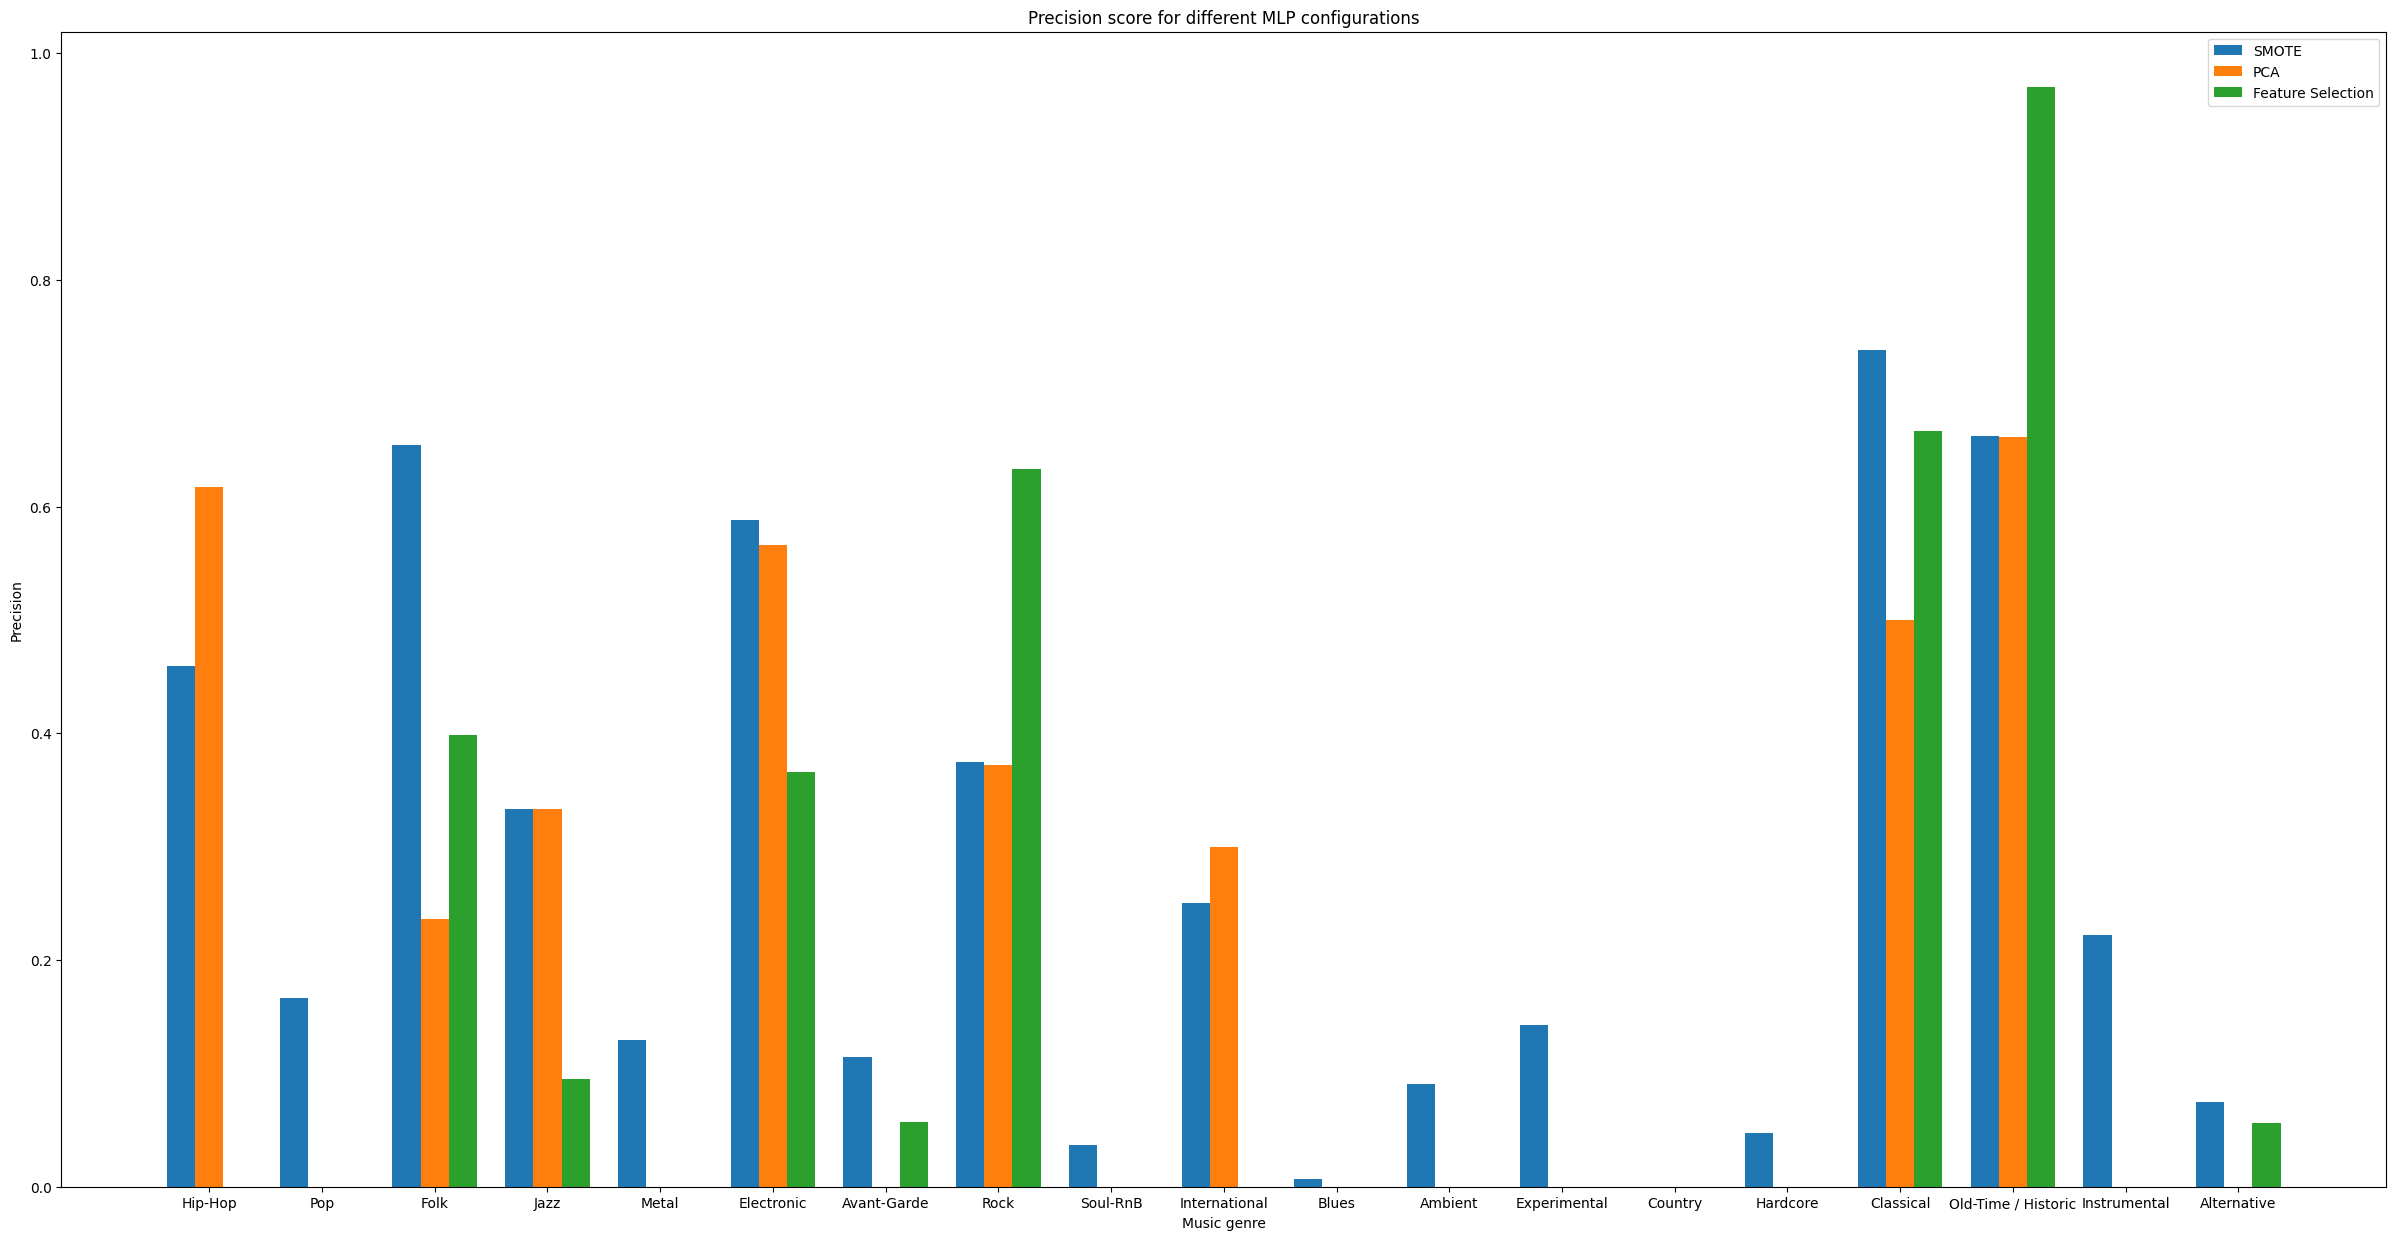

In [61]:
three_group_bar_plot(mlp_precision_test, mlp_precision_test_pca, mlp_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different MLP configurations", "Music genre", 
                    "Precision", ["SMOTE"]+legend_test)

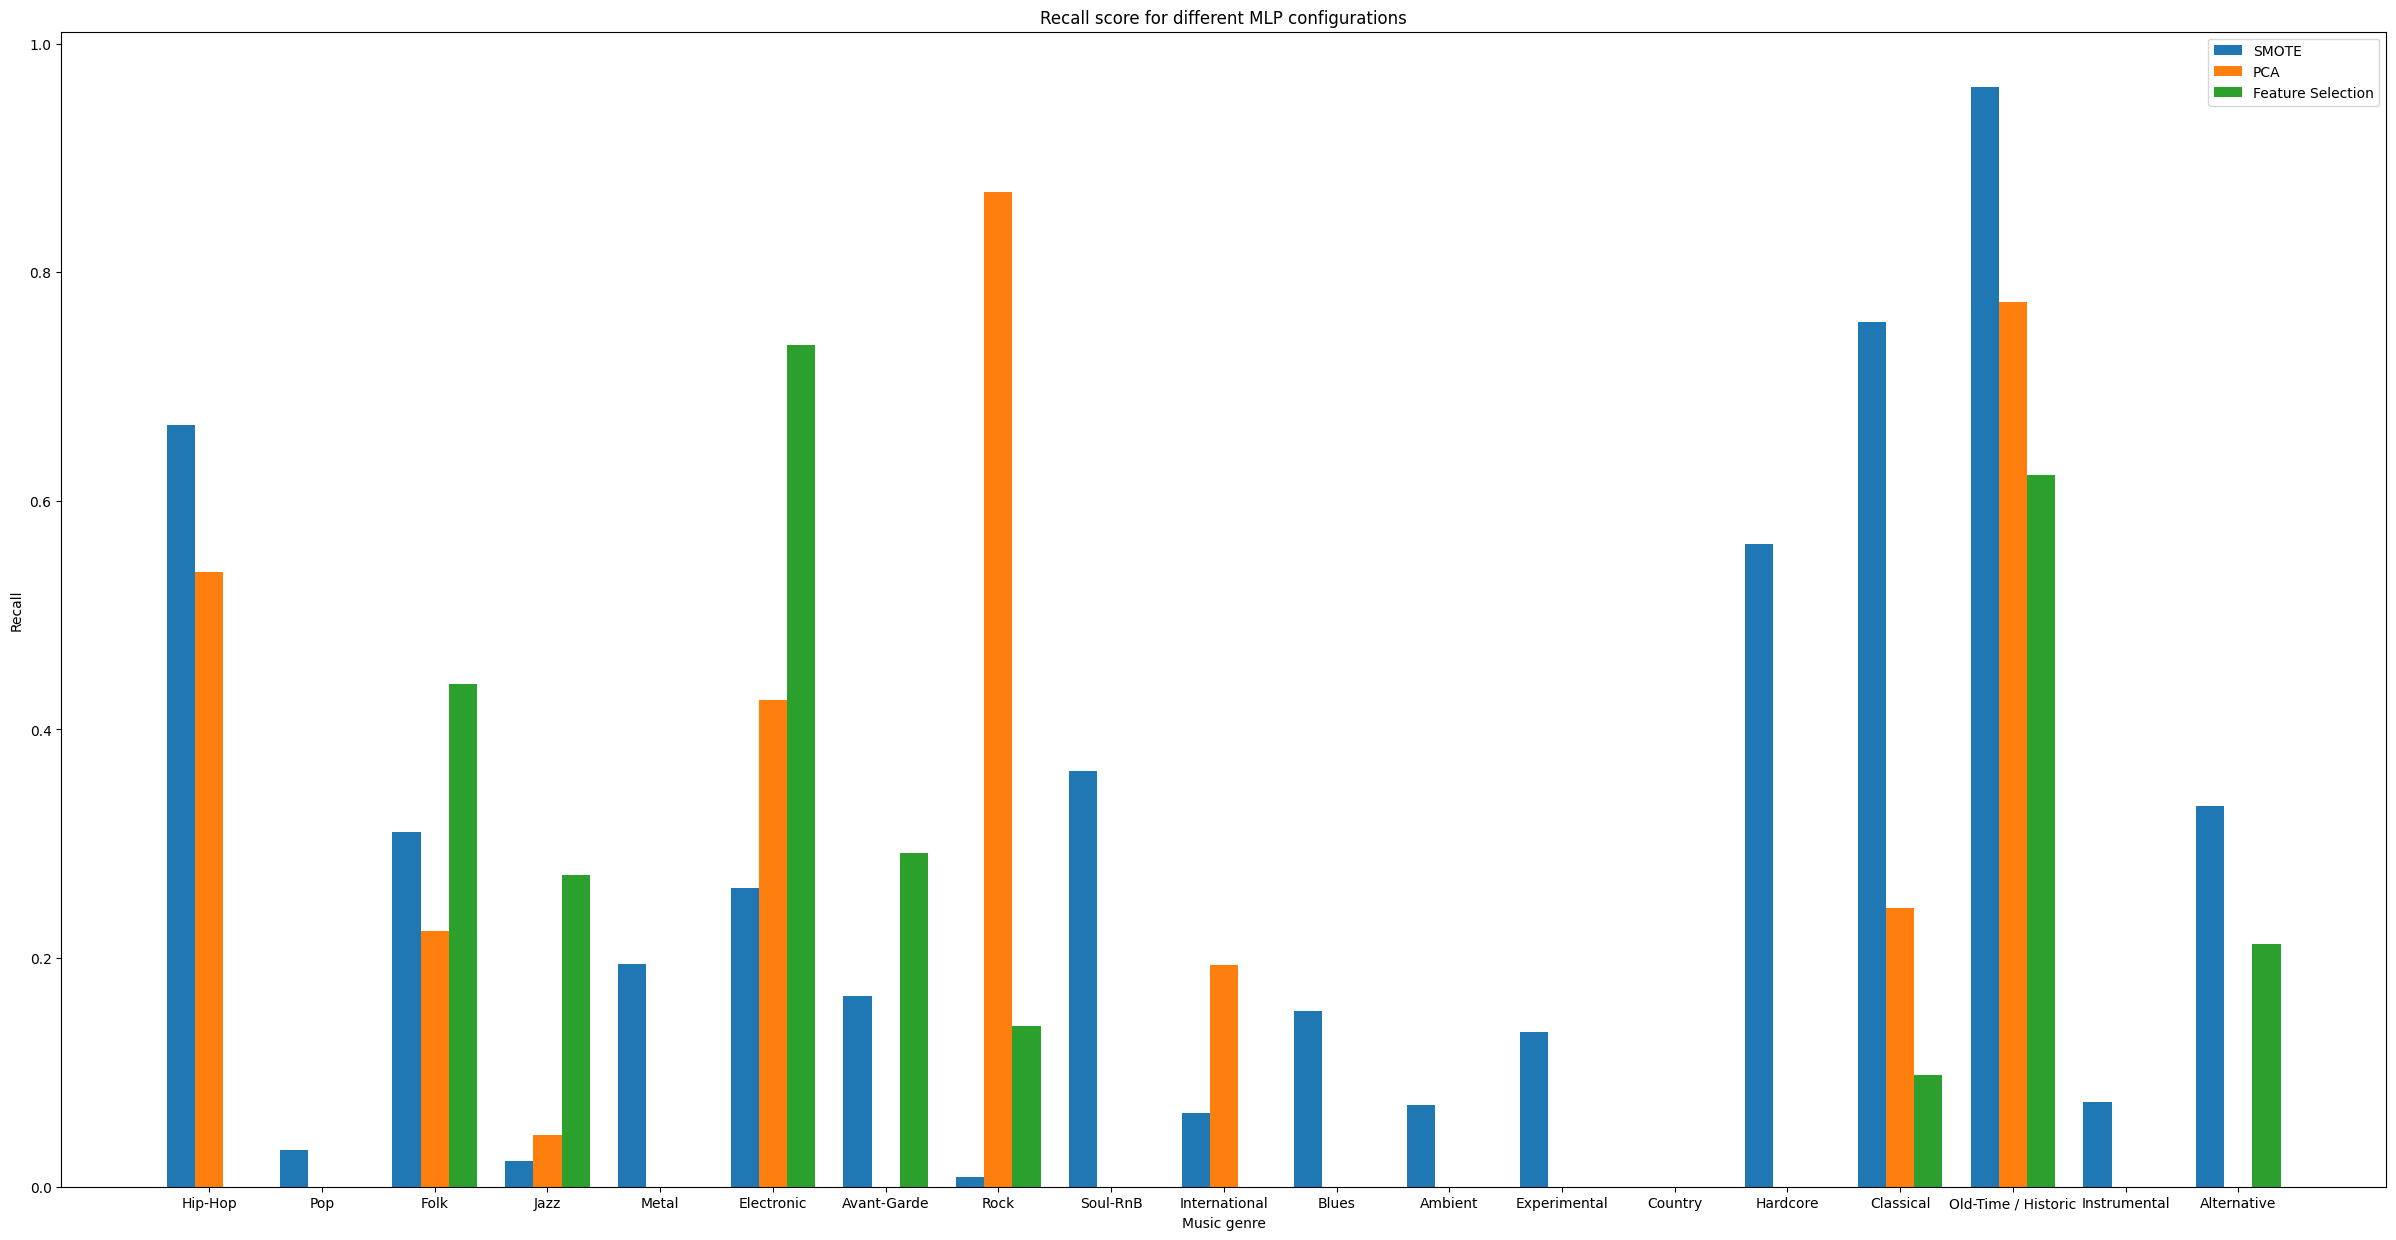

In [62]:
three_group_bar_plot(mlp_recall_test, mlp_recall_test_pca, mlp_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different MLP configurations", "Music genre", 
                    "Recall", ["SMOTE"]+legend_test)

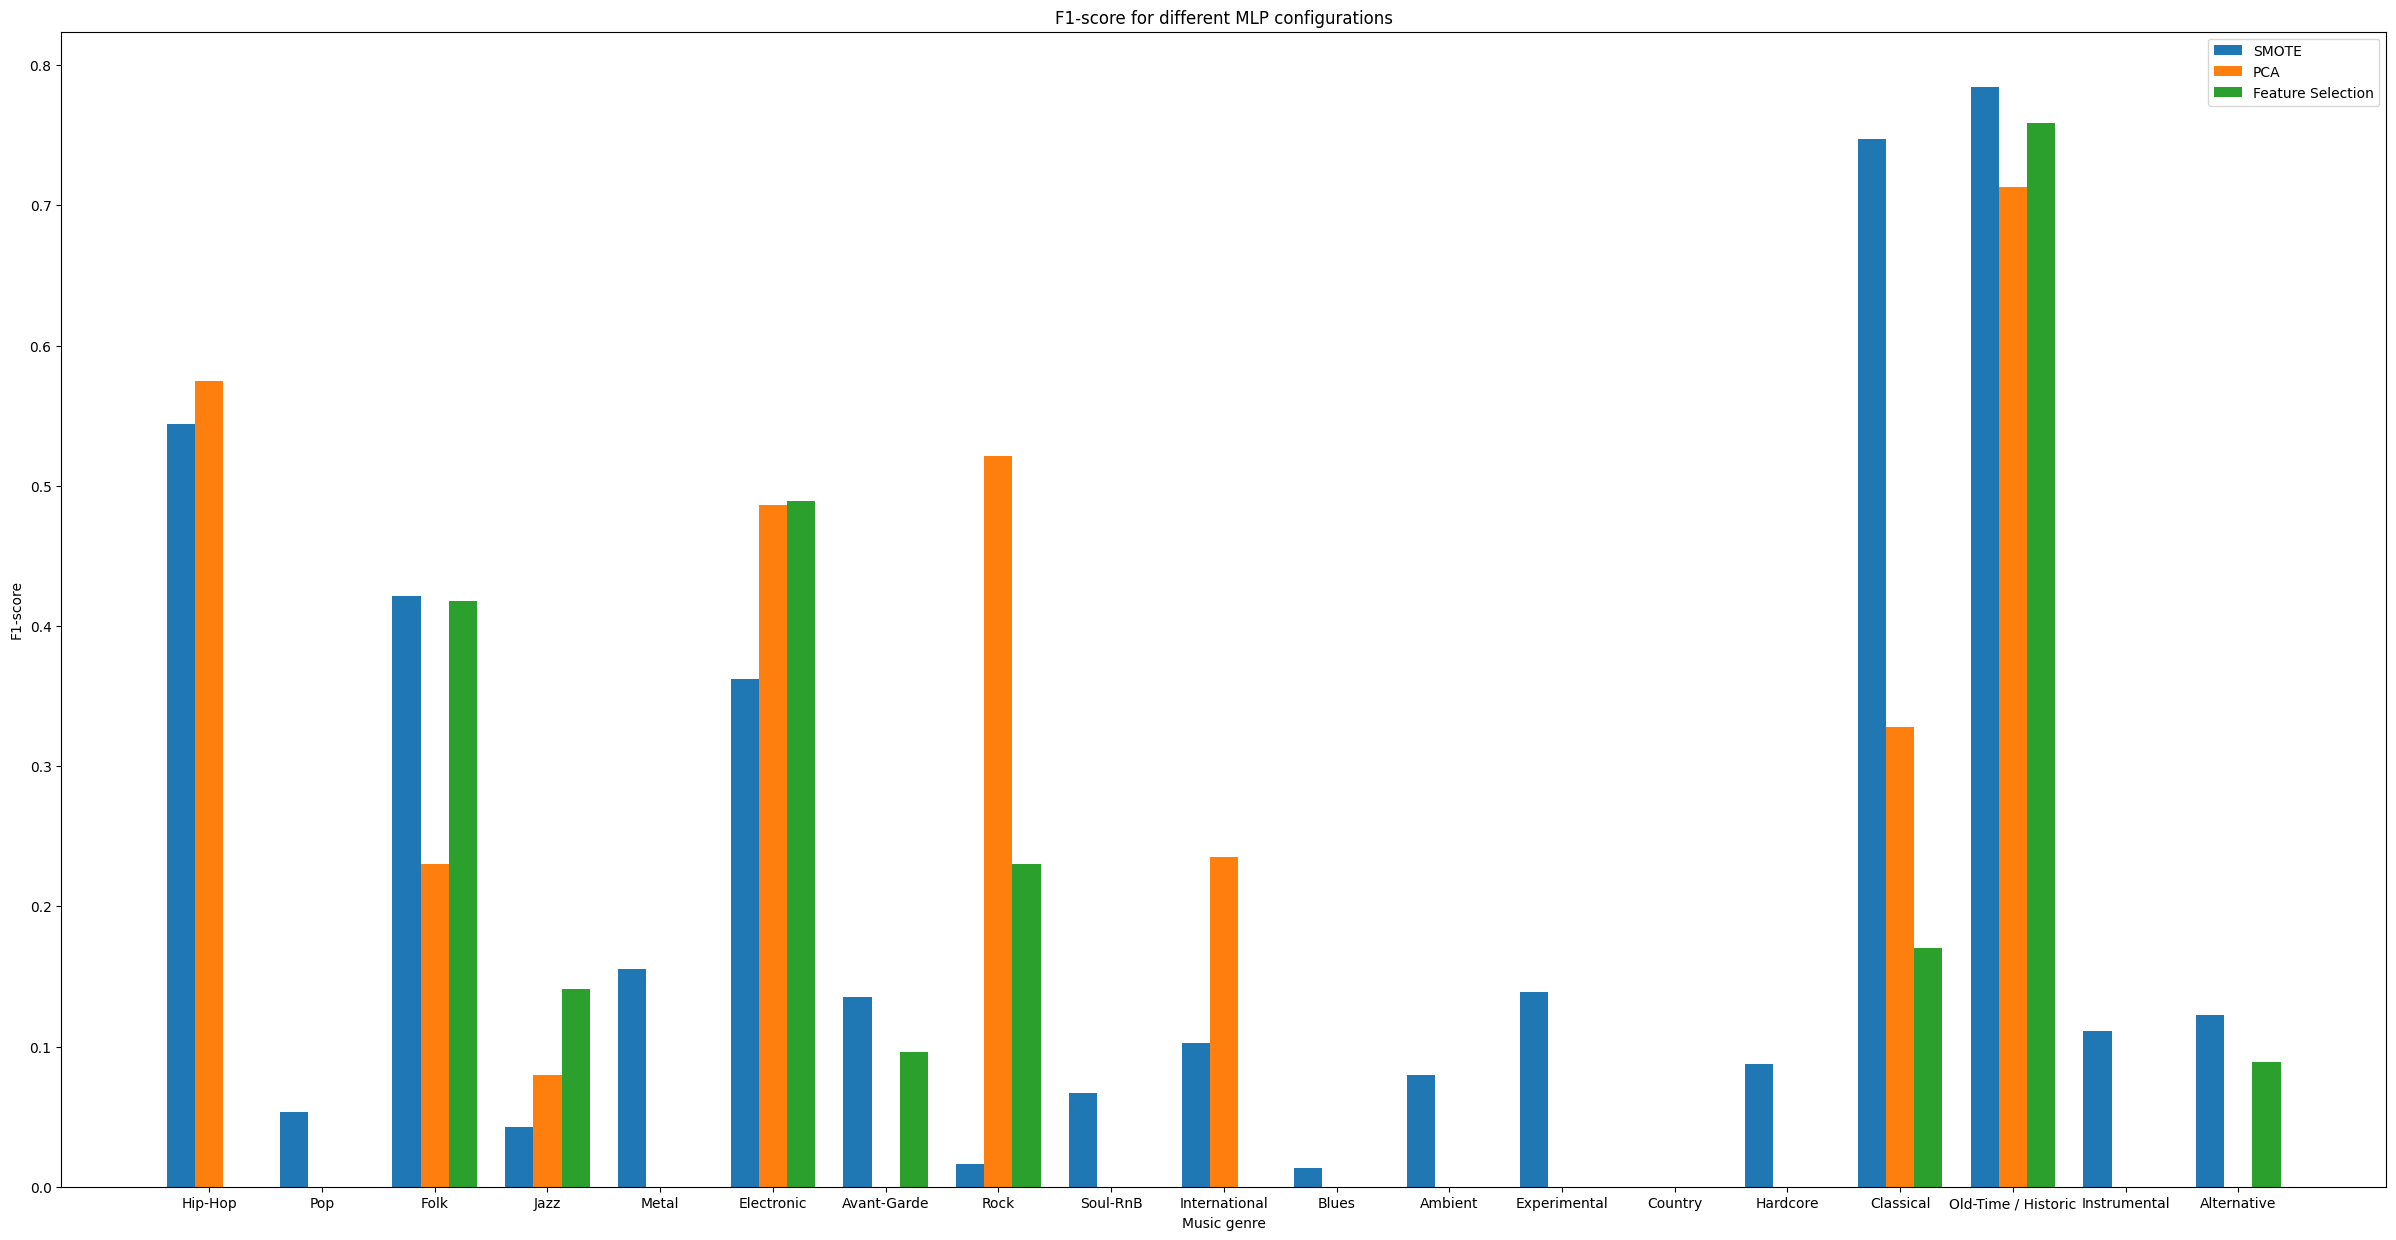

In [63]:
three_group_bar_plot(mlp_f1_test, mlp_f1_test_pca, mlp_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different MLP configurations", "Music genre", 
                    "F1-score", ["SMOTE"]+legend_test)

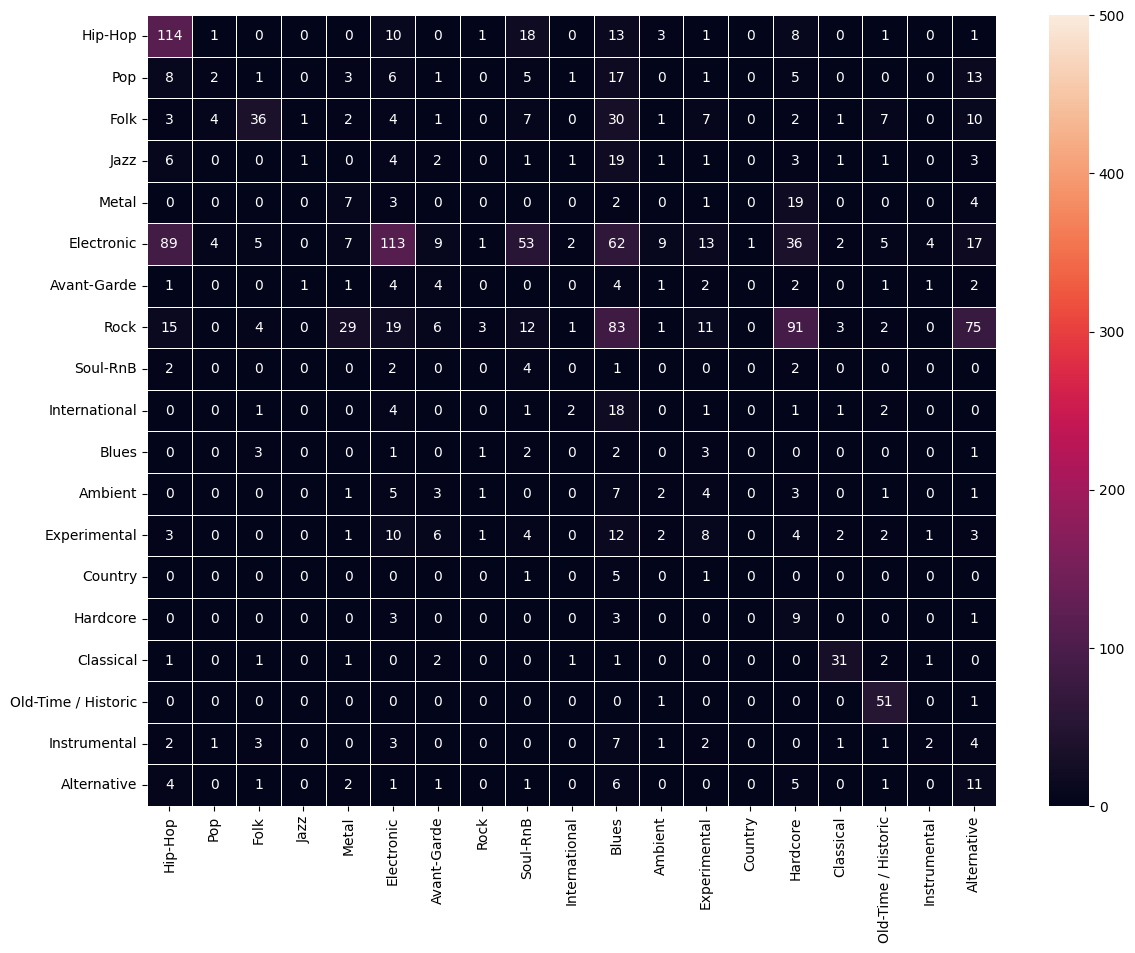

In [74]:
# Confusion matrix
mlp_cm_test = confusion_matrix(y_test, mlp_test_preds, labels=labels)
print_cm(mlp_cm_test, orig_labels, "Confusion matrix for MLP")

## Decision Three classification

### DT without tweaks

In [48]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=plain['DT']['min_samples_leaf'], 
                               min_samples_split=plain['DT']['min_samples_split']).fit(X_train, 
                                                                                      y_train)
dt_val_predict = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report = dt_results[0]
dt_precision = dt_results[1]
dt_recall = dt_results[2]
dt_f1 = dt_results[3]

------------------------------ DT completed ------------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

### DT with oversampling

In [51]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(X_train_os, 
                                                                                       y_train_os)
dt_val_predict_os = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results_os = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report_os = dt_results_os[0]
dt_precision_os = dt_results_os[1]
dt_recall_os = dt_results_os[2]
dt_f1_os = dt_results_os[3]

------------------------------ DT oversampling completed ------------------------------


### DT with SMOTE

In [53]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=smote['DT']['min_samples_leaf'], 
                               min_samples_split=smote['DT']['min_samples_split']).fit(
    X_train_smote, y_train_smote)

dt_val_predict_smote = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results_smote = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict_smote), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report_smote = dt_results_smote[0]
dt_precision_smote = dt_results_smote[1]
dt_recall_smote = dt_results_smote[2]
dt_f1_smote = dt_results_smote[3]

------------------------------ DT oversampling completed ------------------------------


### Metrics comparison for DT

In [54]:
print("-------------------------------- Metrics without tweaks --------------------------------")
dt_report

-------------------------------- Metrics without tweaks --------------------------------


{'Hip-Hop': {'precision': 0.4297520661157025,
  'recall': 0.3291139240506329,
  'f1-score': 0.37275985663082434,
  'support': 158},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 51},
 'Folk': {'precision': 0.2116788321167883,
  'recall': 0.30526315789473685,
  'f1-score': 0.25,
  'support': 95},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Metal': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'Electronic': {'precision': 0.45161290322580644,
  'recall': 0.5994962216624685,
  'f1-score': 0.5151515151515151,
  'support': 397},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 29},
 'Rock': {'precision': 0.492,
  'recall': 0.6795580110497238,
  'f1-score': 0.5707656612529002,
  'support': 362},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13},
 'International': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 21},
 'Blues': {'prec

In [55]:
print("------------------------------ Metrics with oversampling ------------------------------")
dt_report_os

------------------------------ Metrics with oversampling ------------------------------


{'Hip-Hop': {'precision': 0.45255474452554745,
  'recall': 0.3924050632911392,
  'f1-score': 0.42033898305084744,
  'support': 158},
 'Pop': {'precision': 0.13636363636363635,
  'recall': 0.11764705882352941,
  'f1-score': 0.1263157894736842,
  'support': 51},
 'Folk': {'precision': 0.3229166666666667,
  'recall': 0.3263157894736842,
  'f1-score': 0.32460732984293195,
  'support': 95},
 'Jazz': {'precision': 0.037037037037037035,
  'recall': 0.02857142857142857,
  'f1-score': 0.03225806451612903,
  'support': 35},
 'Metal': {'precision': 0.10526315789473684,
  'recall': 0.09523809523809523,
  'f1-score': 0.1,
  'support': 21},
 'Electronic': {'precision': 0.5086848635235732,
  'recall': 0.5163727959697733,
  'f1-score': 0.5125000000000001,
  'support': 397},
 'Avant-Garde': {'precision': 0.029411764705882353,
  'recall': 0.034482758620689655,
  'f1-score': 0.03174603174603175,
  'support': 29},
 'Rock': {'precision': 0.5062893081761006,
  'recall': 0.4447513812154696,
  'f1-score': 0.4

In [56]:
print("-------------------------------- Metrics with SMOTE --------------------------------")
dt_report_smote

-------------------------------- Metrics with SMOTE --------------------------------


{'Hip-Hop': {'precision': 0.45323741007194246,
  'recall': 0.3987341772151899,
  'f1-score': 0.4242424242424243,
  'support': 158},
 'Pop': {'precision': 0.16129032258064516,
  'recall': 0.09803921568627451,
  'f1-score': 0.1219512195121951,
  'support': 51},
 'Folk': {'precision': 0.3125,
  'recall': 0.3157894736842105,
  'f1-score': 0.31413612565445026,
  'support': 95},
 'Jazz': {'precision': 0.06896551724137931,
  'recall': 0.05714285714285714,
  'f1-score': 0.0625,
  'support': 35},
 'Metal': {'precision': 0.06666666666666667,
  'recall': 0.047619047619047616,
  'f1-score': 0.05555555555555555,
  'support': 21},
 'Electronic': {'precision': 0.4864864864864865,
  'recall': 0.4987405541561713,
  'f1-score': 0.49253731343283585,
  'support': 397},
 'Avant-Garde': {'precision': 0.06060606060606061,
  'recall': 0.06896551724137931,
  'f1-score': 0.06451612903225808,
  'support': 29},
 'Rock': {'precision': 0.5047619047619047,
  'recall': 0.43922651933701656,
  'f1-score': 0.46971935007

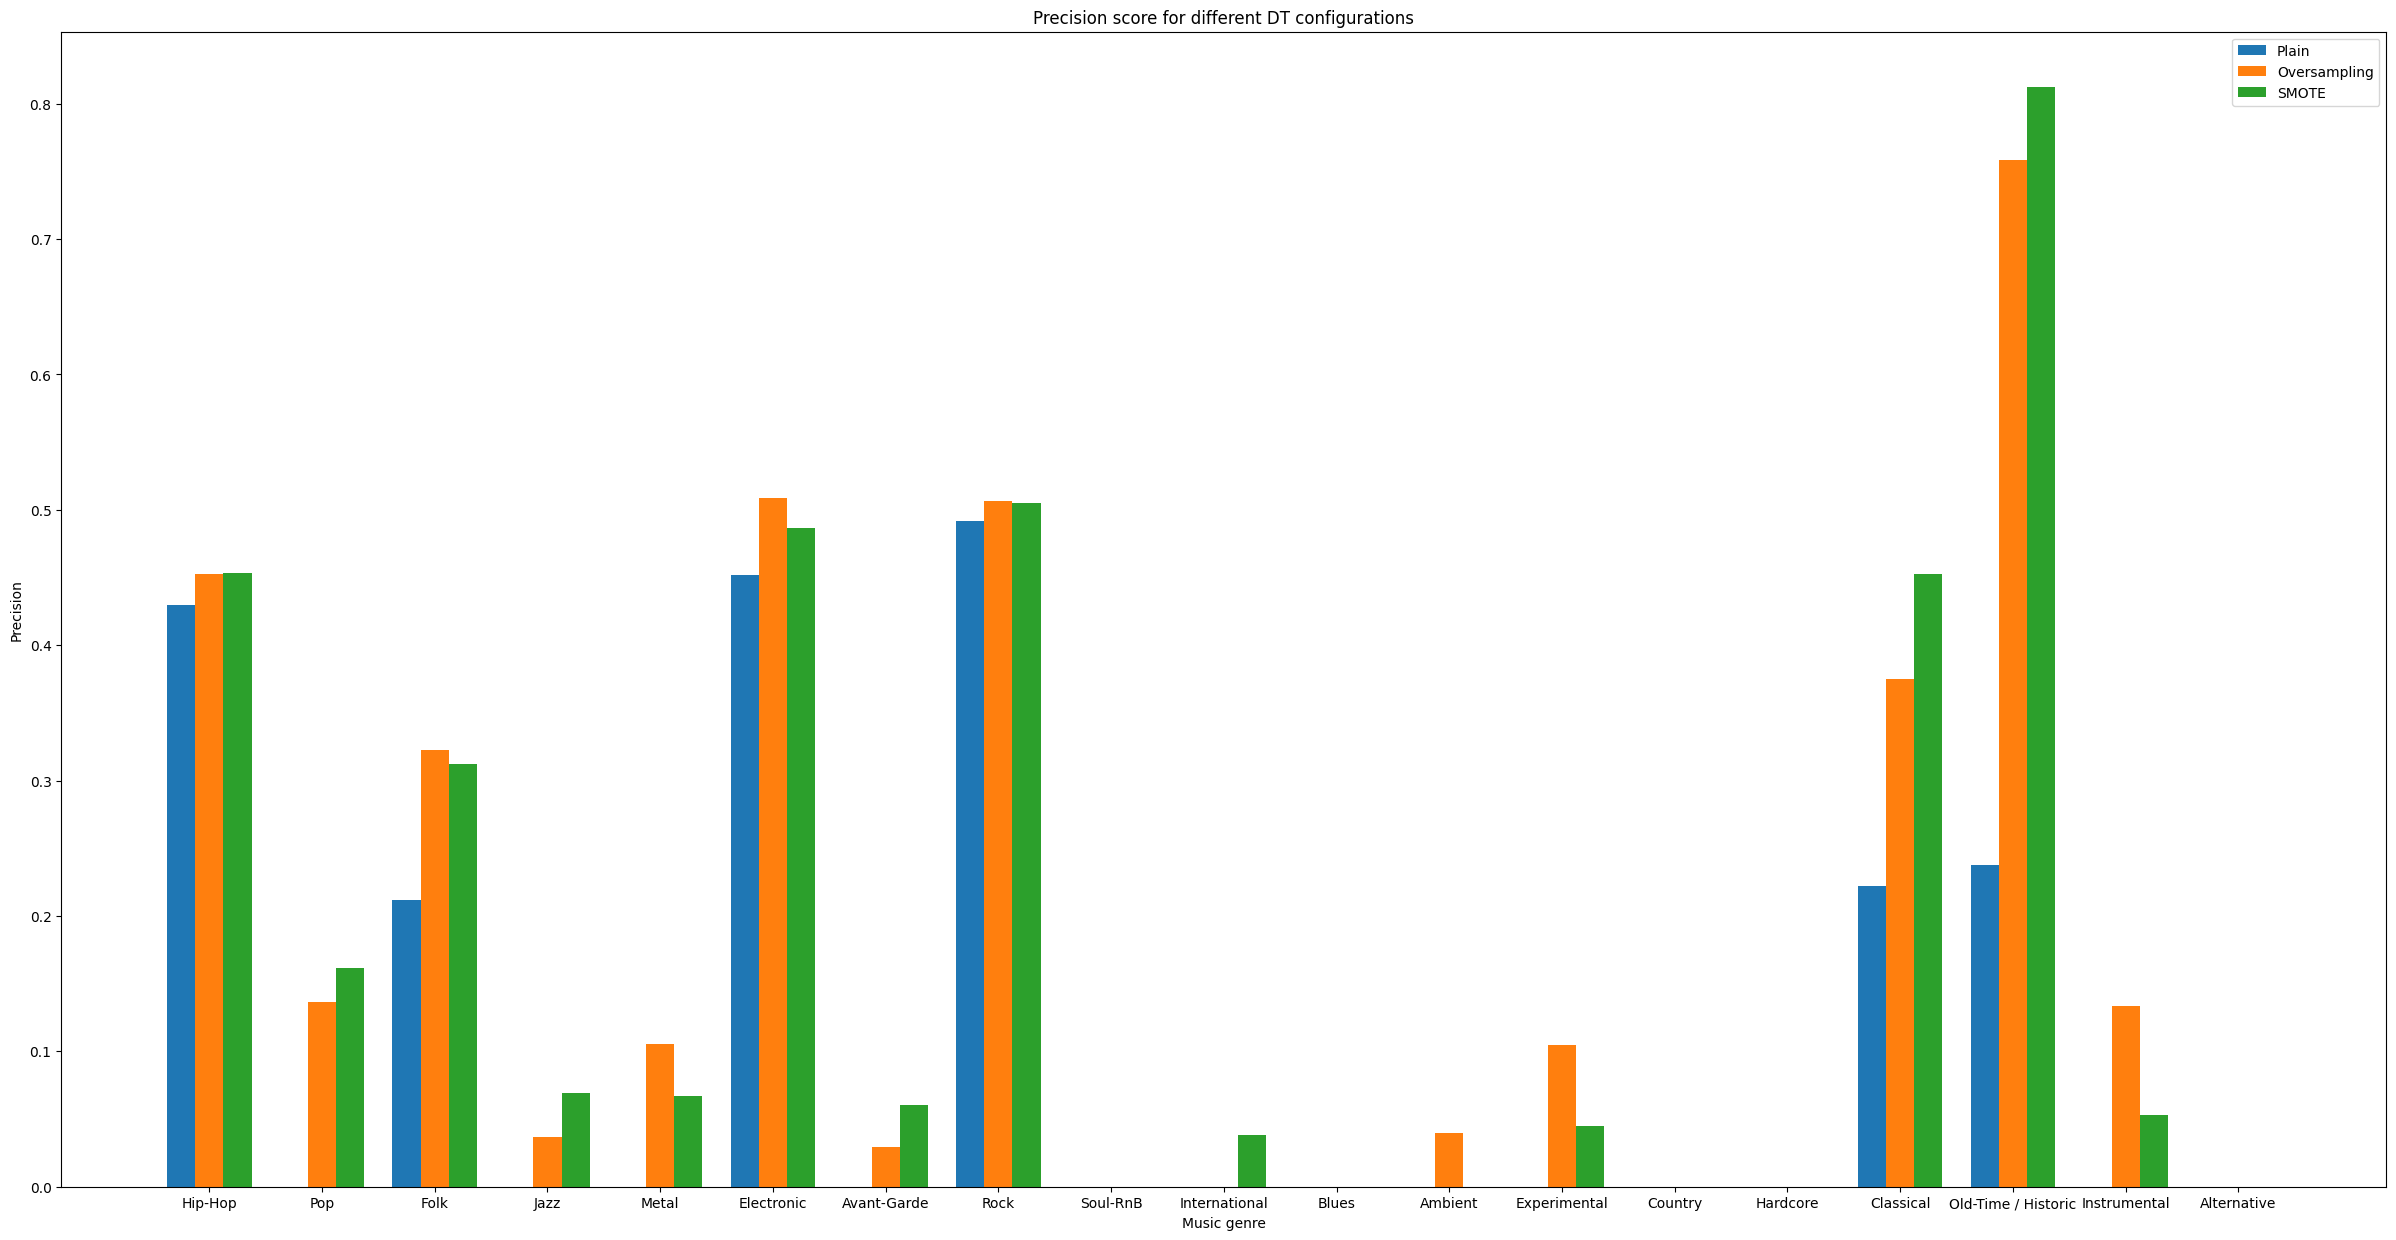

In [57]:
three_group_bar_plot(dt_precision, dt_precision_os, dt_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different DT configurations", "Music genre", 
                    "Precision", legend_validation)

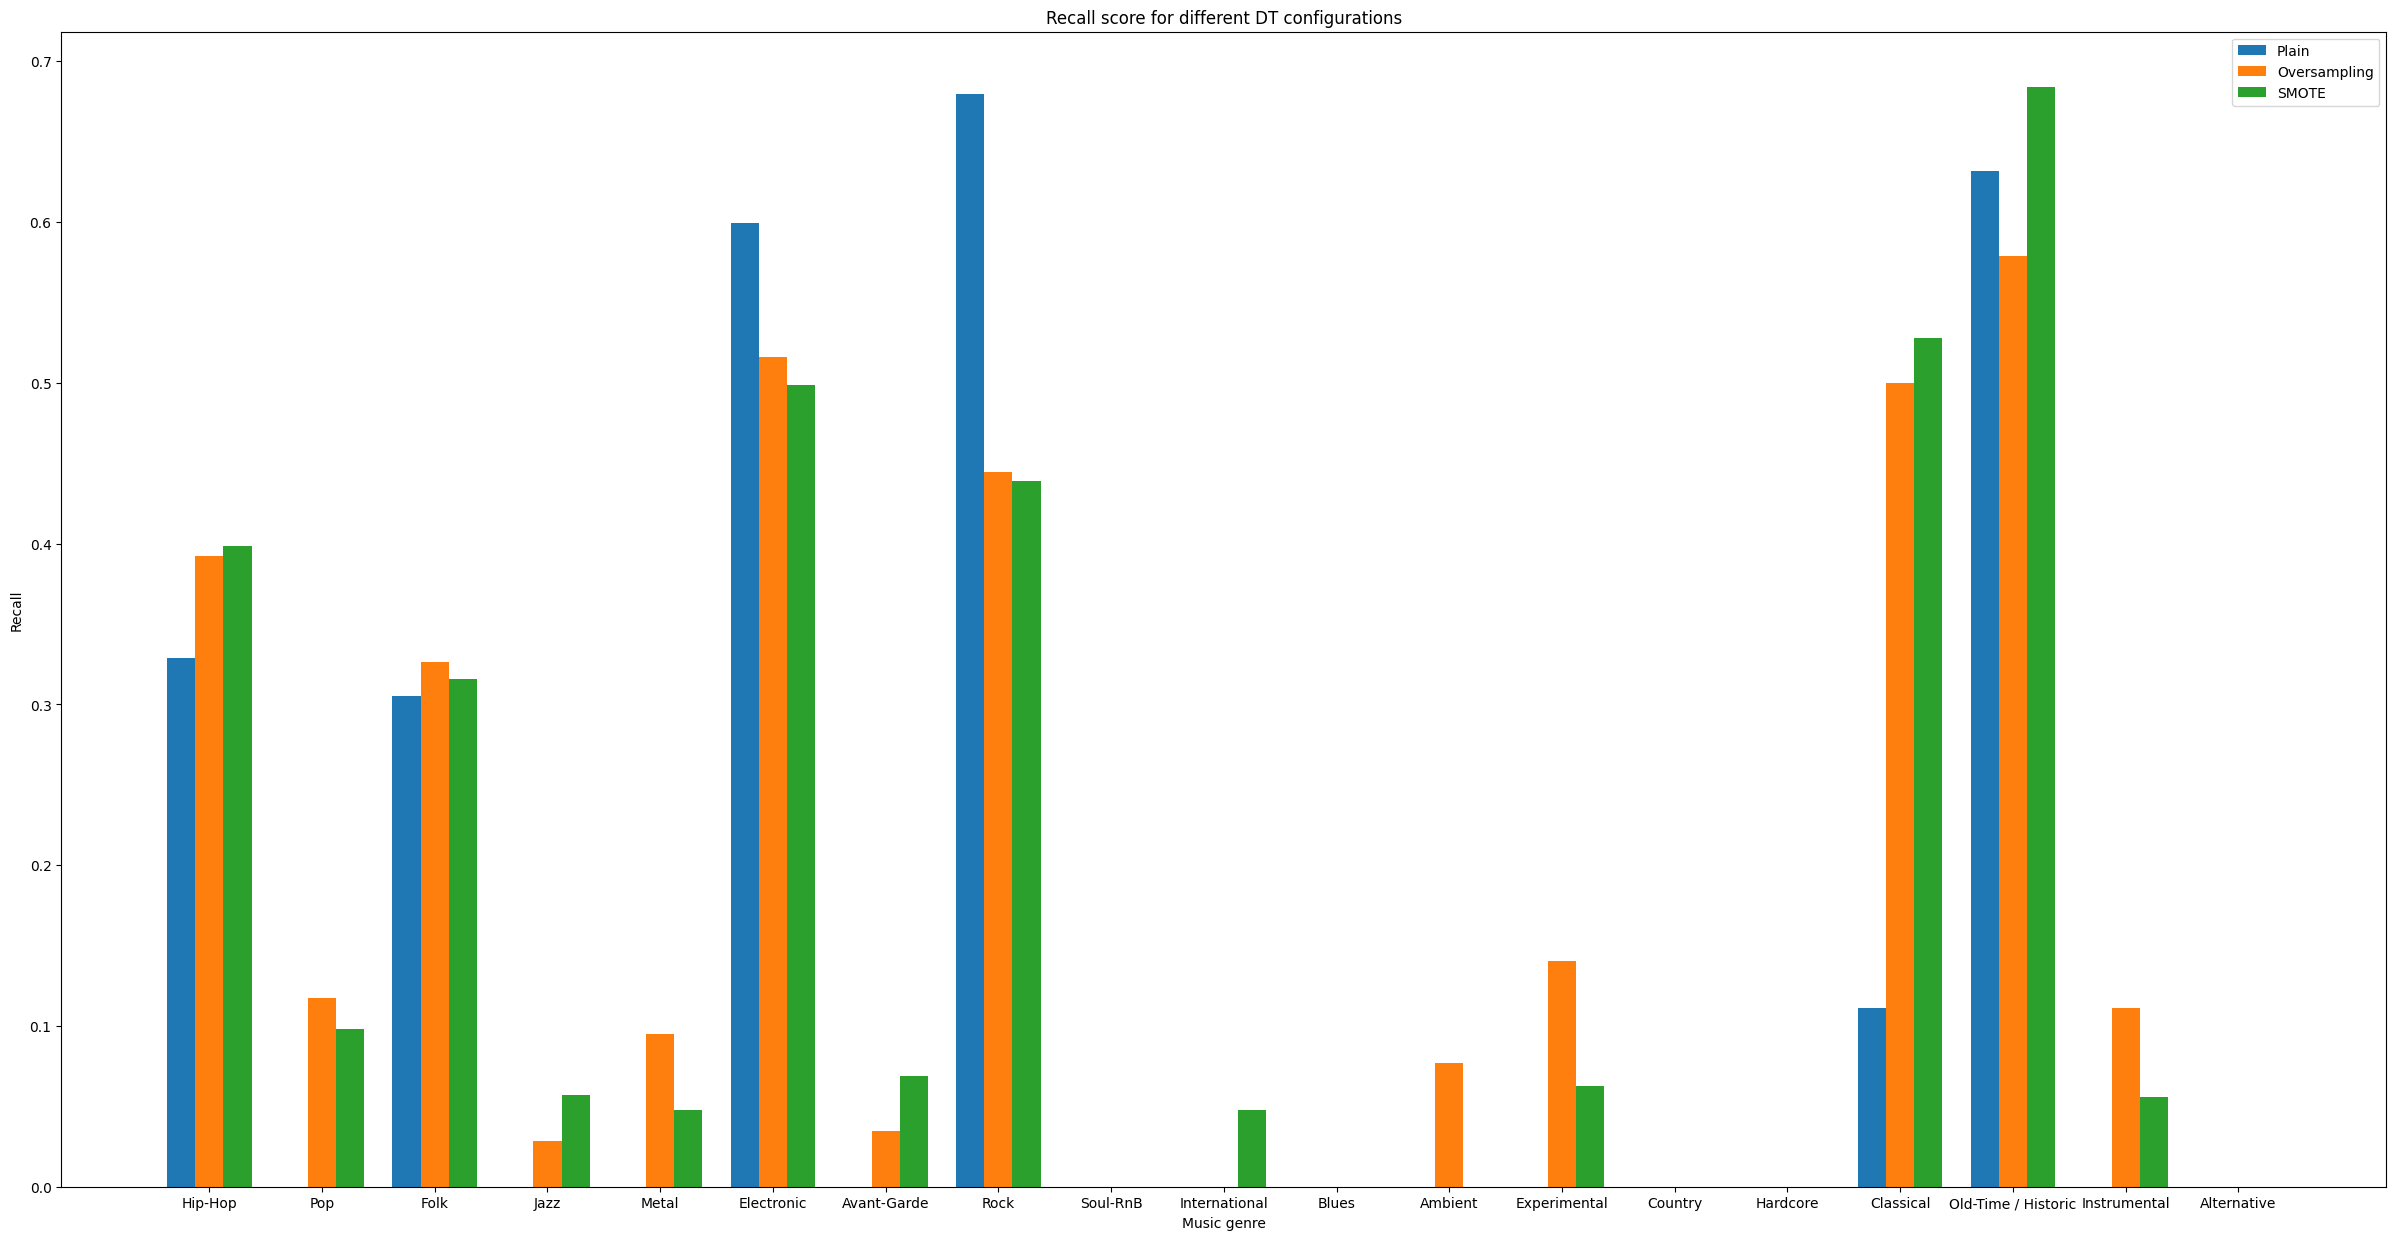

In [58]:
three_group_bar_plot(dt_recall, dt_recall_os, dt_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different DT configurations", "Music genre", 
                    "Recall", legend_validation)

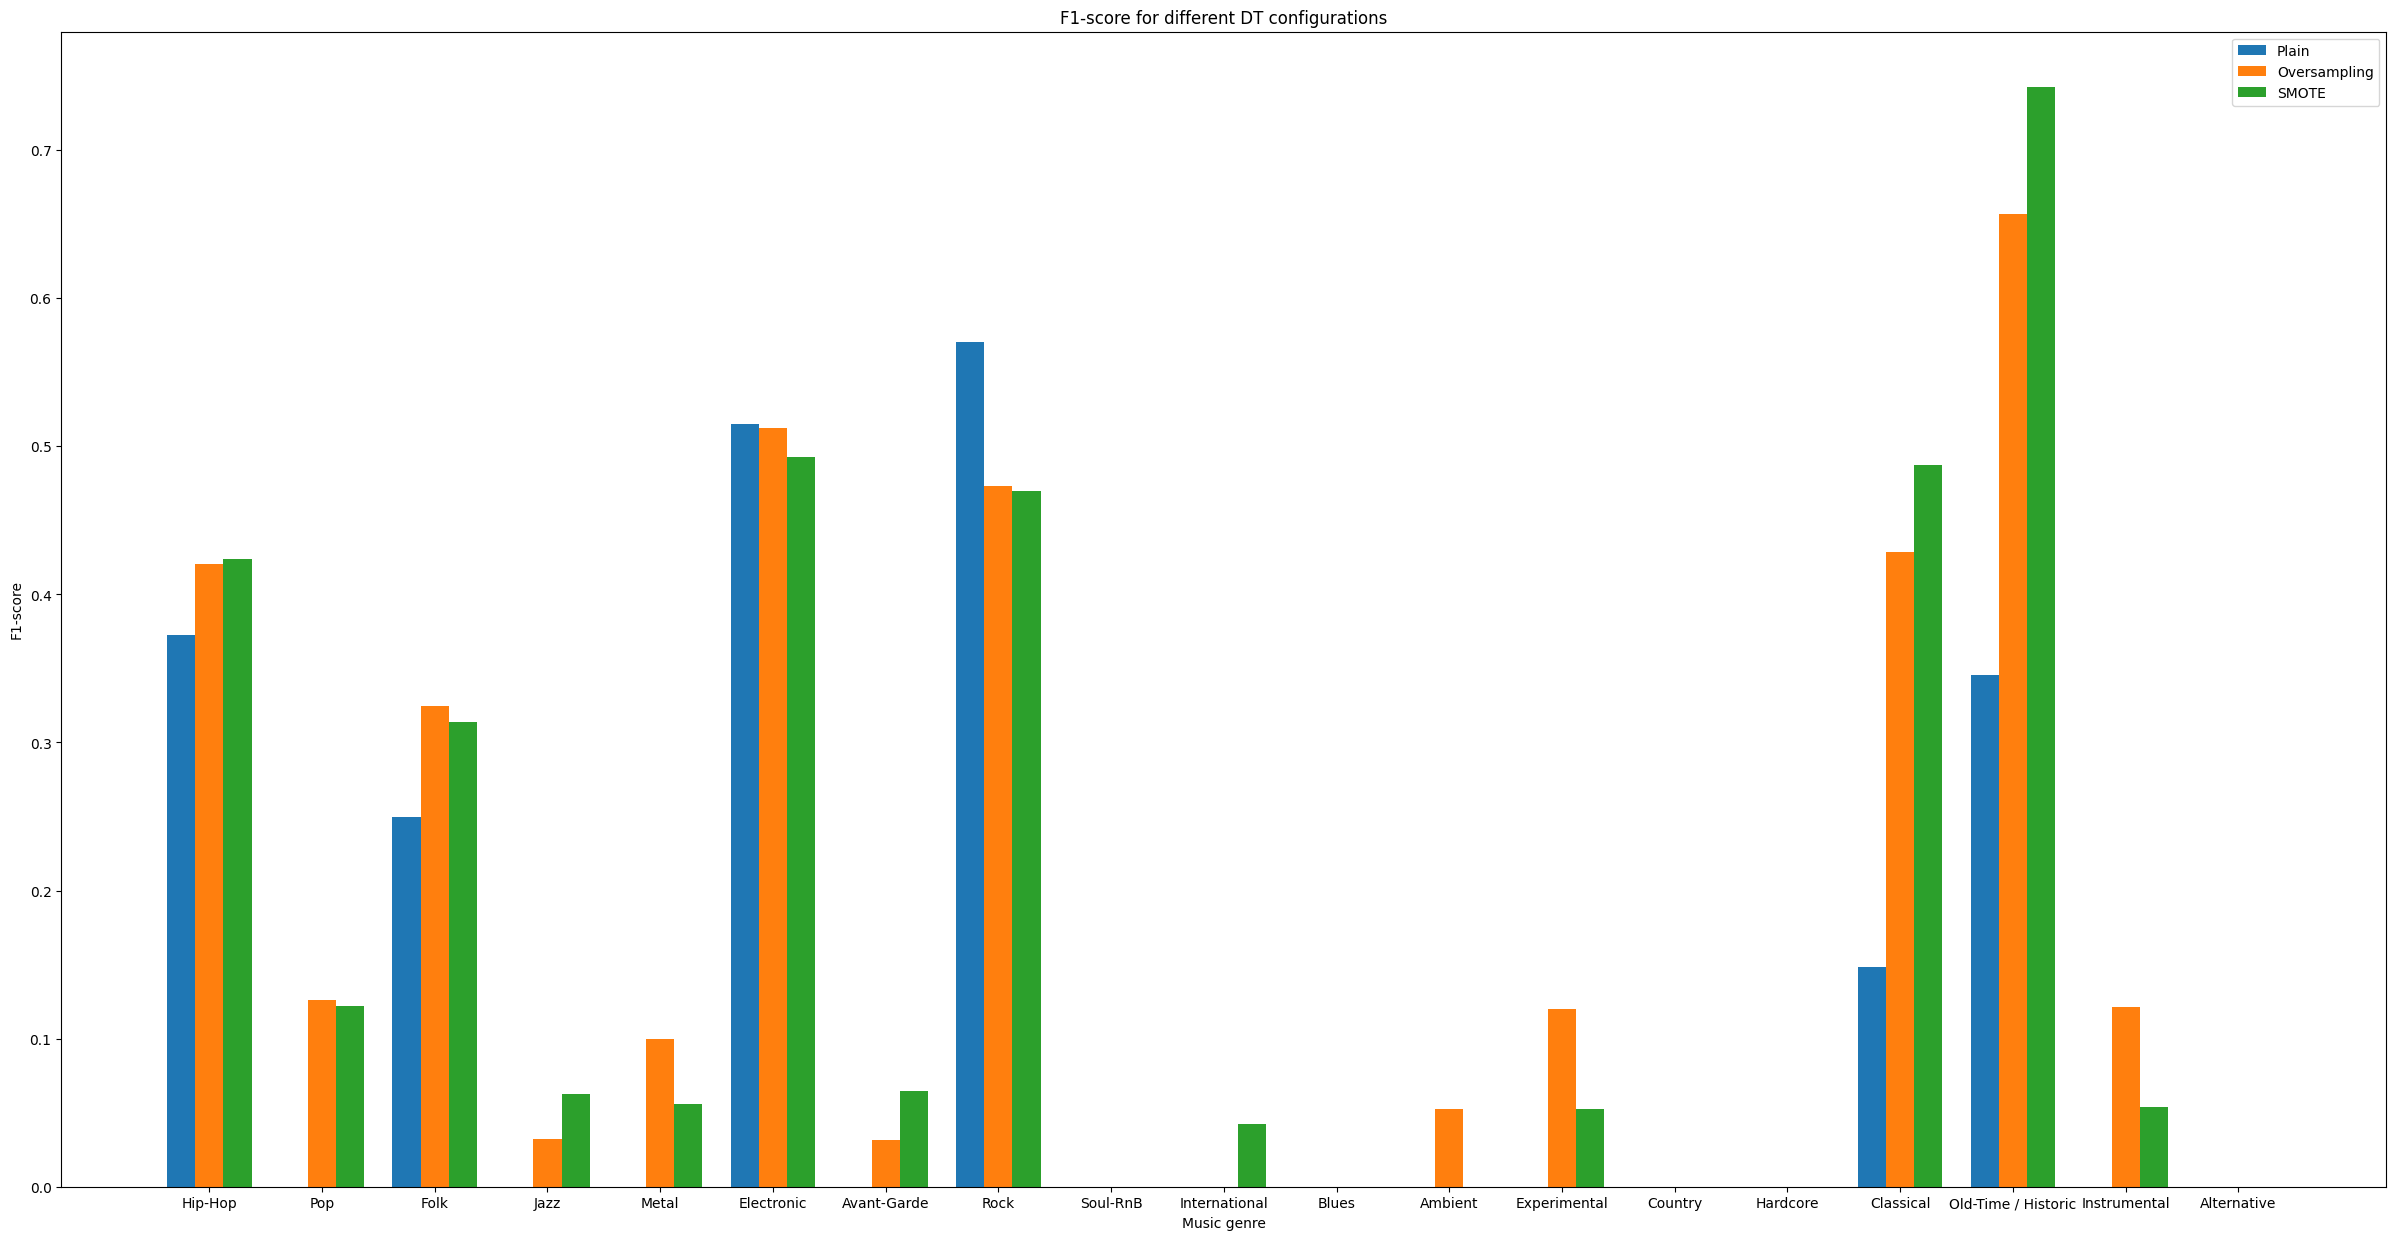

In [59]:
three_group_bar_plot(dt_f1, dt_f1_os, dt_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different DT configurations", "Music genre", 
                    "F1-score", legend_validation)

### DT on test set
Best case: OVERS

In [64]:
orig_labels = le.inverse_transform(labels)
dt_clf = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(
    X_train_os, y_train_os)
dt_test_preds = dt_clf.predict(X_test)

dt_results_test = compute_class_metrics(
    predictions=le.inverse_transform(dt_test_preds), 
    y_set=le.inverse_transform(y_test), 
    labels= orig_labels
)

dt_report_test = dt_results_test[0]
dt_precision_test = dt_results_test[1]
dt_recall_test = dt_results_test[2]
dt_f1_test = dt_results_test[3]

In [66]:
pca = PCA(n_components=overs_pca['DT']['n_components'])
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

dt_clf = DecisionTreeClassifier(min_samples_leaf=overs_pca['DT']['min_samples_leaf'], 
                               min_samples_split=overs_pca['DT']['min_samples_split']).fit(
    X_train_pca, y_train)
dt_test_preds_pca = dt_clf.predict(X_test_pca)

dt_results_test_pca = compute_class_metrics(
    predictions=le.inverse_transform(dt_test_preds_pca), 
    y_set=le.inverse_transform(y_test), 
    labels= orig_labels
)

dt_report_test_pca = dt_results_test_pca[0]
dt_precision_test_pca = dt_results_test_pca[1]
dt_recall_test_pca = dt_results_test_pca[2]
dt_f1_test_pca = dt_results_test_pca[3]

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Undefin

In [67]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(
    X_train_fs, y_train_fs)

dt_test_preds_fs = dt_clf.predict(X_test_fs)

dt_results_test_fs = compute_class_metrics(
    predictions=le.inverse_transform(dt_test_preds_fs), 
    y_set=le.inverse_transform(y_test_fs), 
    labels= orig_labels
)

dt_report_test_fs = dt_results_test_fs[0]
dt_precision_test_fs = dt_results_test_fs[1]
dt_recall_test_fs = dt_results_test_fs[2]
dt_f1_test_fs = dt_results_test_fs[3]

In [68]:
dt_report_test

{'Hip-Hop': {'precision': 0.5384615384615384,
  'recall': 0.5321637426900585,
  'f1-score': 0.5352941176470588,
  'support': 171},
 'Pop': {'precision': 0.08955223880597014,
  'recall': 0.09523809523809523,
  'f1-score': 0.09230769230769231,
  'support': 63},
 'Folk': {'precision': 0.41904761904761906,
  'recall': 0.3793103448275862,
  'f1-score': 0.3981900452488688,
  'support': 116},
 'Jazz': {'precision': 0.14516129032258066,
  'recall': 0.20454545454545456,
  'f1-score': 0.169811320754717,
  'support': 44},
 'Metal': {'precision': 0.2702702702702703,
  'recall': 0.2777777777777778,
  'f1-score': 0.273972602739726,
  'support': 36},
 'Electronic': {'precision': 0.4918793503480278,
  'recall': 0.49074074074074076,
  'f1-score': 0.49130938586326767,
  'support': 432},
 'Avant-Garde': {'precision': 0.09090909090909091,
  'recall': 0.125,
  'f1-score': 0.10526315789473685,
  'support': 24},
 'Rock': {'precision': 0.5743944636678201,
  'recall': 0.4676056338028169,
  'f1-score': 0.515527

In [69]:
dt_report_test_pca

{'Hip-Hop': {'precision': 0.4906832298136646,
  'recall': 0.4619883040935672,
  'f1-score': 0.4759036144578313,
  'support': 171},
 'Pop': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 63},
 'Folk': {'precision': 0.39823008849557523,
  'recall': 0.3879310344827586,
  'f1-score': 0.39301310043668125,
  'support': 116},
 'Jazz': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 44},
 'Metal': {'precision': 0.3333333333333333,
  'recall': 0.027777777777777776,
  'f1-score': 0.05128205128205128,
  'support': 36},
 'Electronic': {'precision': 0.4759535655058043,
  'recall': 0.6643518518518519,
  'f1-score': 0.5545893719806764,
  'support': 432},
 'Avant-Garde': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 24},
 'Rock': {'precision': 0.49606299212598426,
  'recall': 0.7098591549295775,
  'f1-score': 0.5840092699884125,
  'support': 355},
 'Soul-RnB': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 'International': {'preci

In [70]:
dt_report_test_fs

{'Hip-Hop': {'precision': 0.3924050632911392,
  'recall': 0.36257309941520466,
  'f1-score': 0.3768996960486322,
  'support': 171},
 'Pop': {'precision': 0.15384615384615385,
  'recall': 0.09523809523809523,
  'f1-score': 0.11764705882352941,
  'support': 63},
 'Folk': {'precision': 0.336734693877551,
  'recall': 0.28448275862068967,
  'f1-score': 0.30841121495327106,
  'support': 116},
 'Jazz': {'precision': 0.13793103448275862,
  'recall': 0.09090909090909091,
  'f1-score': 0.1095890410958904,
  'support': 44},
 'Metal': {'precision': 0.07692307692307693,
  'recall': 0.05555555555555555,
  'f1-score': 0.06451612903225808,
  'support': 36},
 'Electronic': {'precision': 0.46496815286624205,
  'recall': 0.5069444444444444,
  'f1-score': 0.48504983388704315,
  'support': 432},
 'Avant-Garde': {'precision': 0.0392156862745098,
  'recall': 0.08333333333333333,
  'f1-score': 0.05333333333333333,
  'support': 24},
 'Rock': {'precision': 0.4837758112094395,
  'recall': 0.4619718309859155,
  '

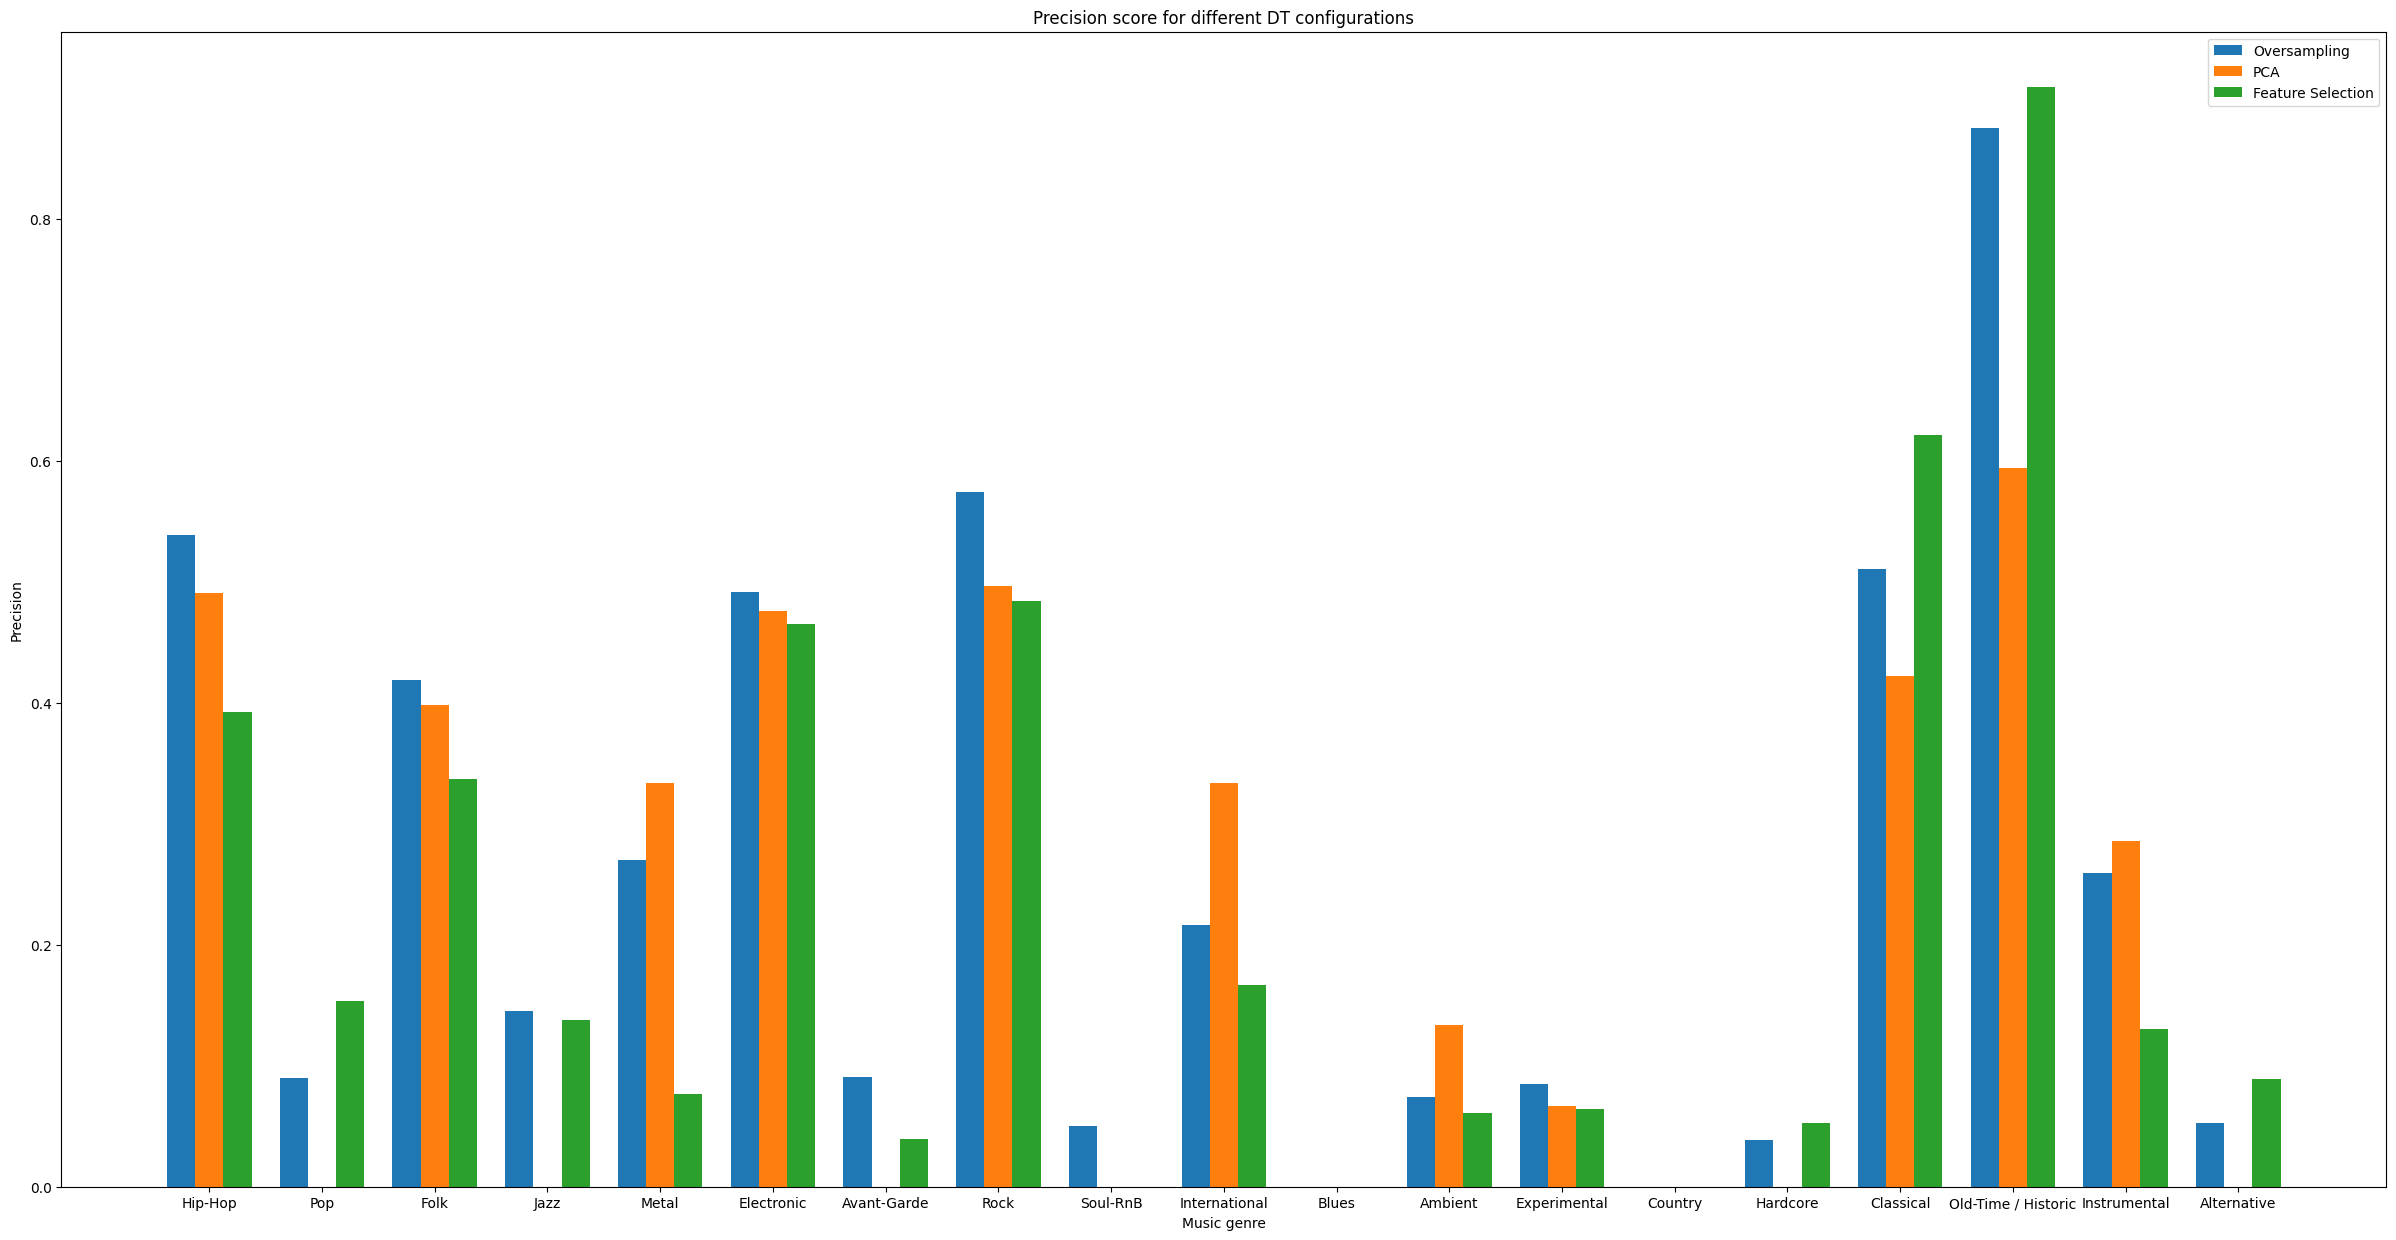

In [71]:
three_group_bar_plot(dt_precision_test, dt_precision_test_pca, dt_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different DT configurations", "Music genre", 
                    "Precision", ["Oversampling"]+legend_test)

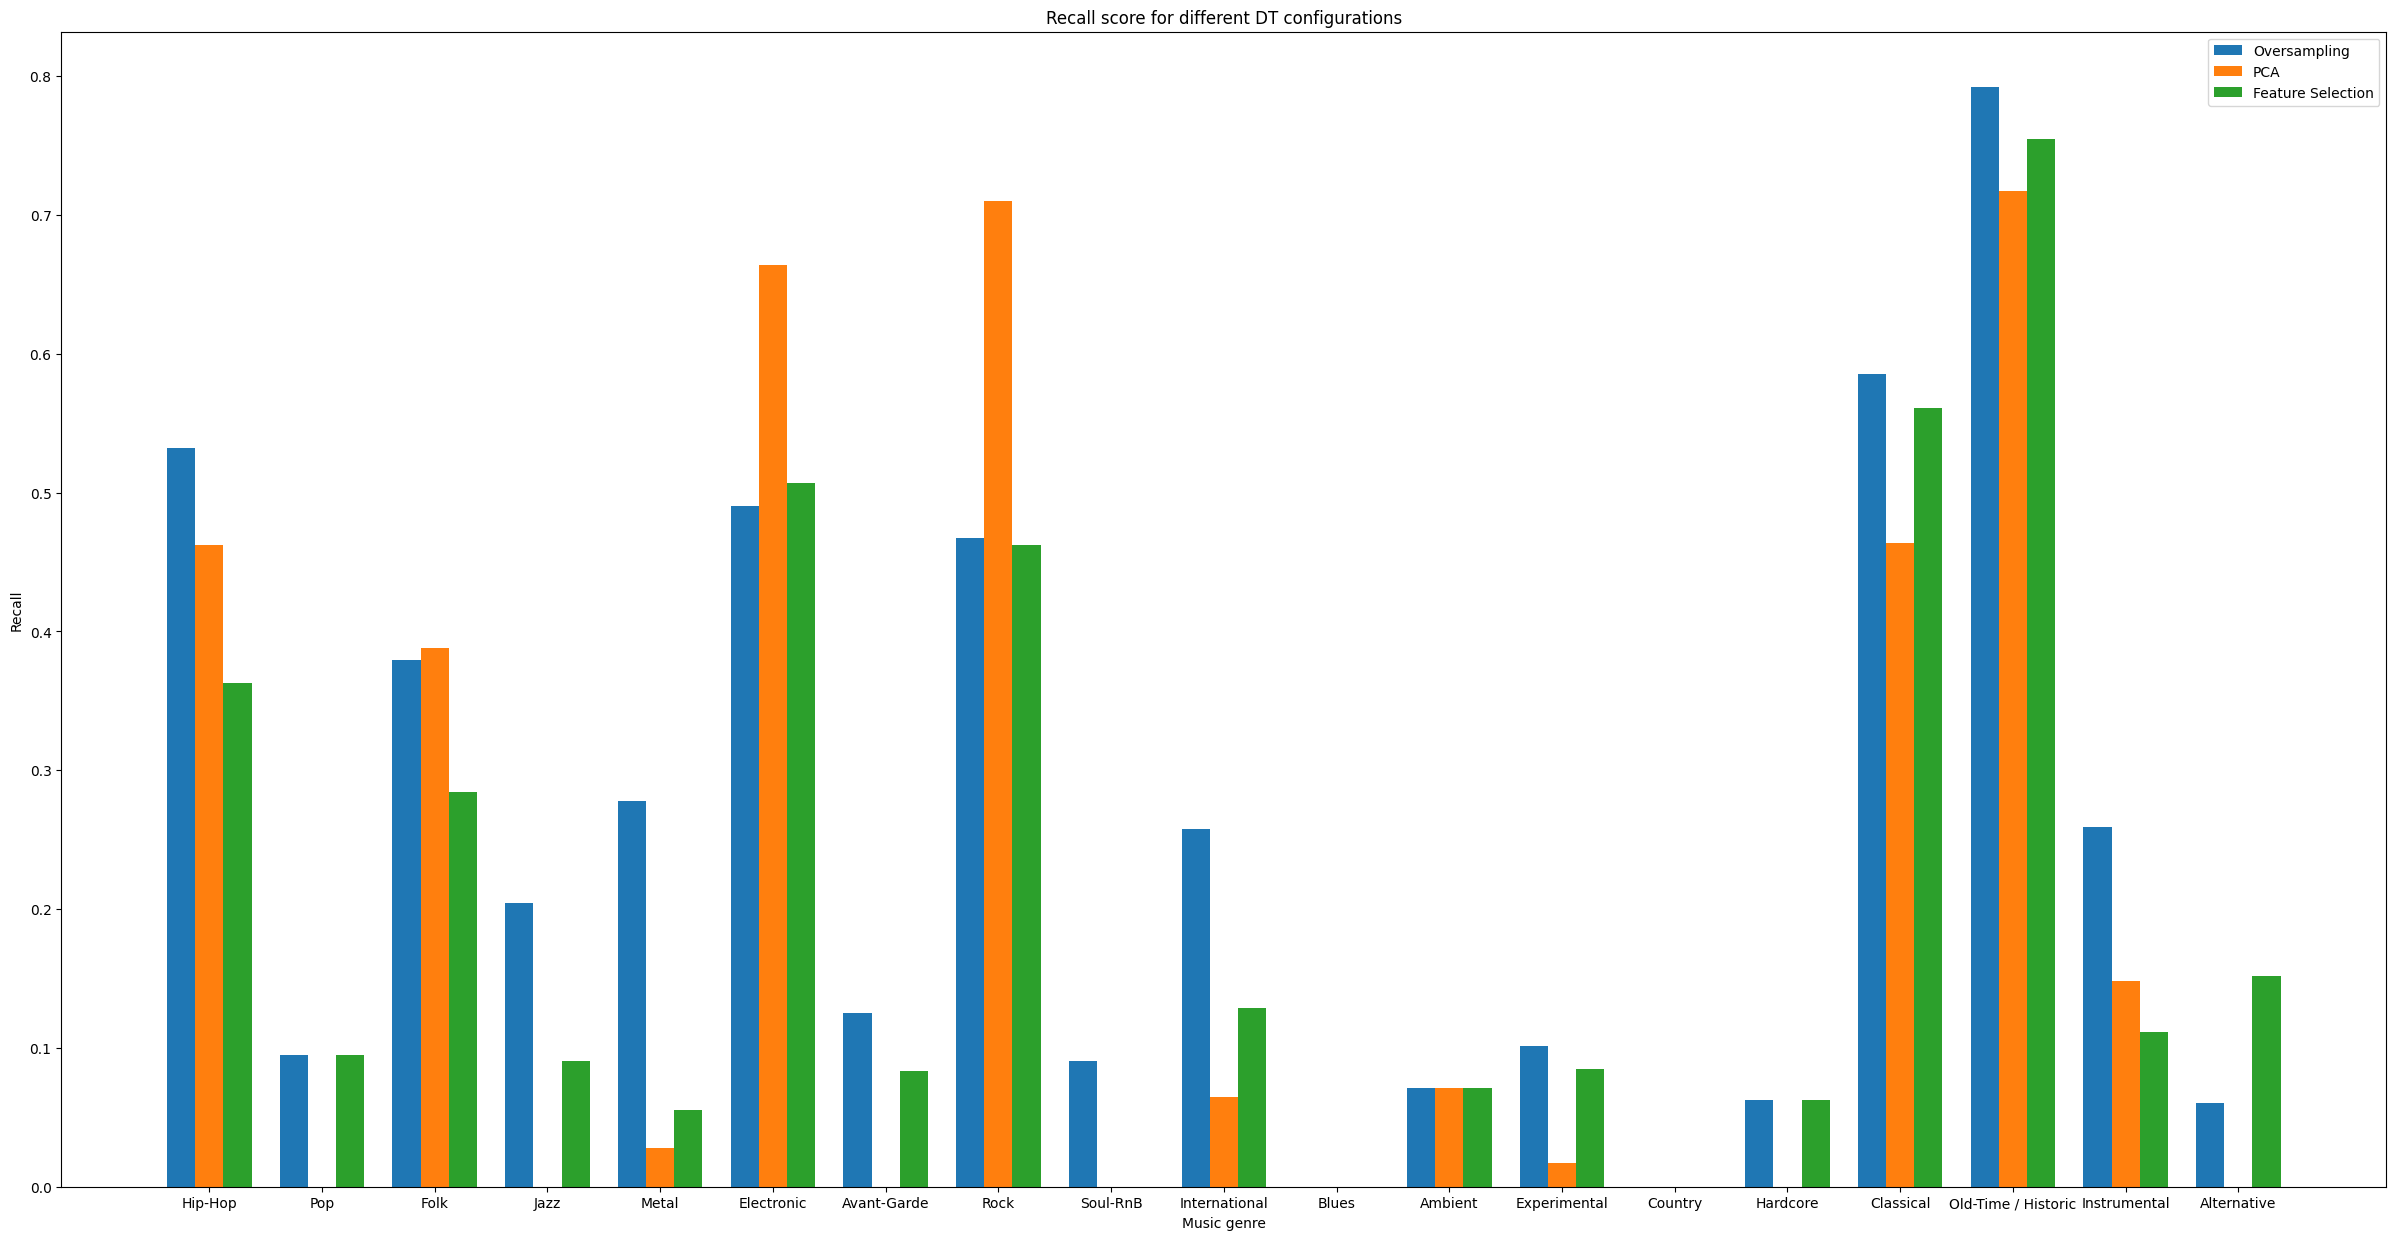

In [72]:
three_group_bar_plot(dt_recall_test, dt_recall_test_pca, dt_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different DT configurations", "Music genre", 
                    "Recall", ["Oversampling"]+legend_test)

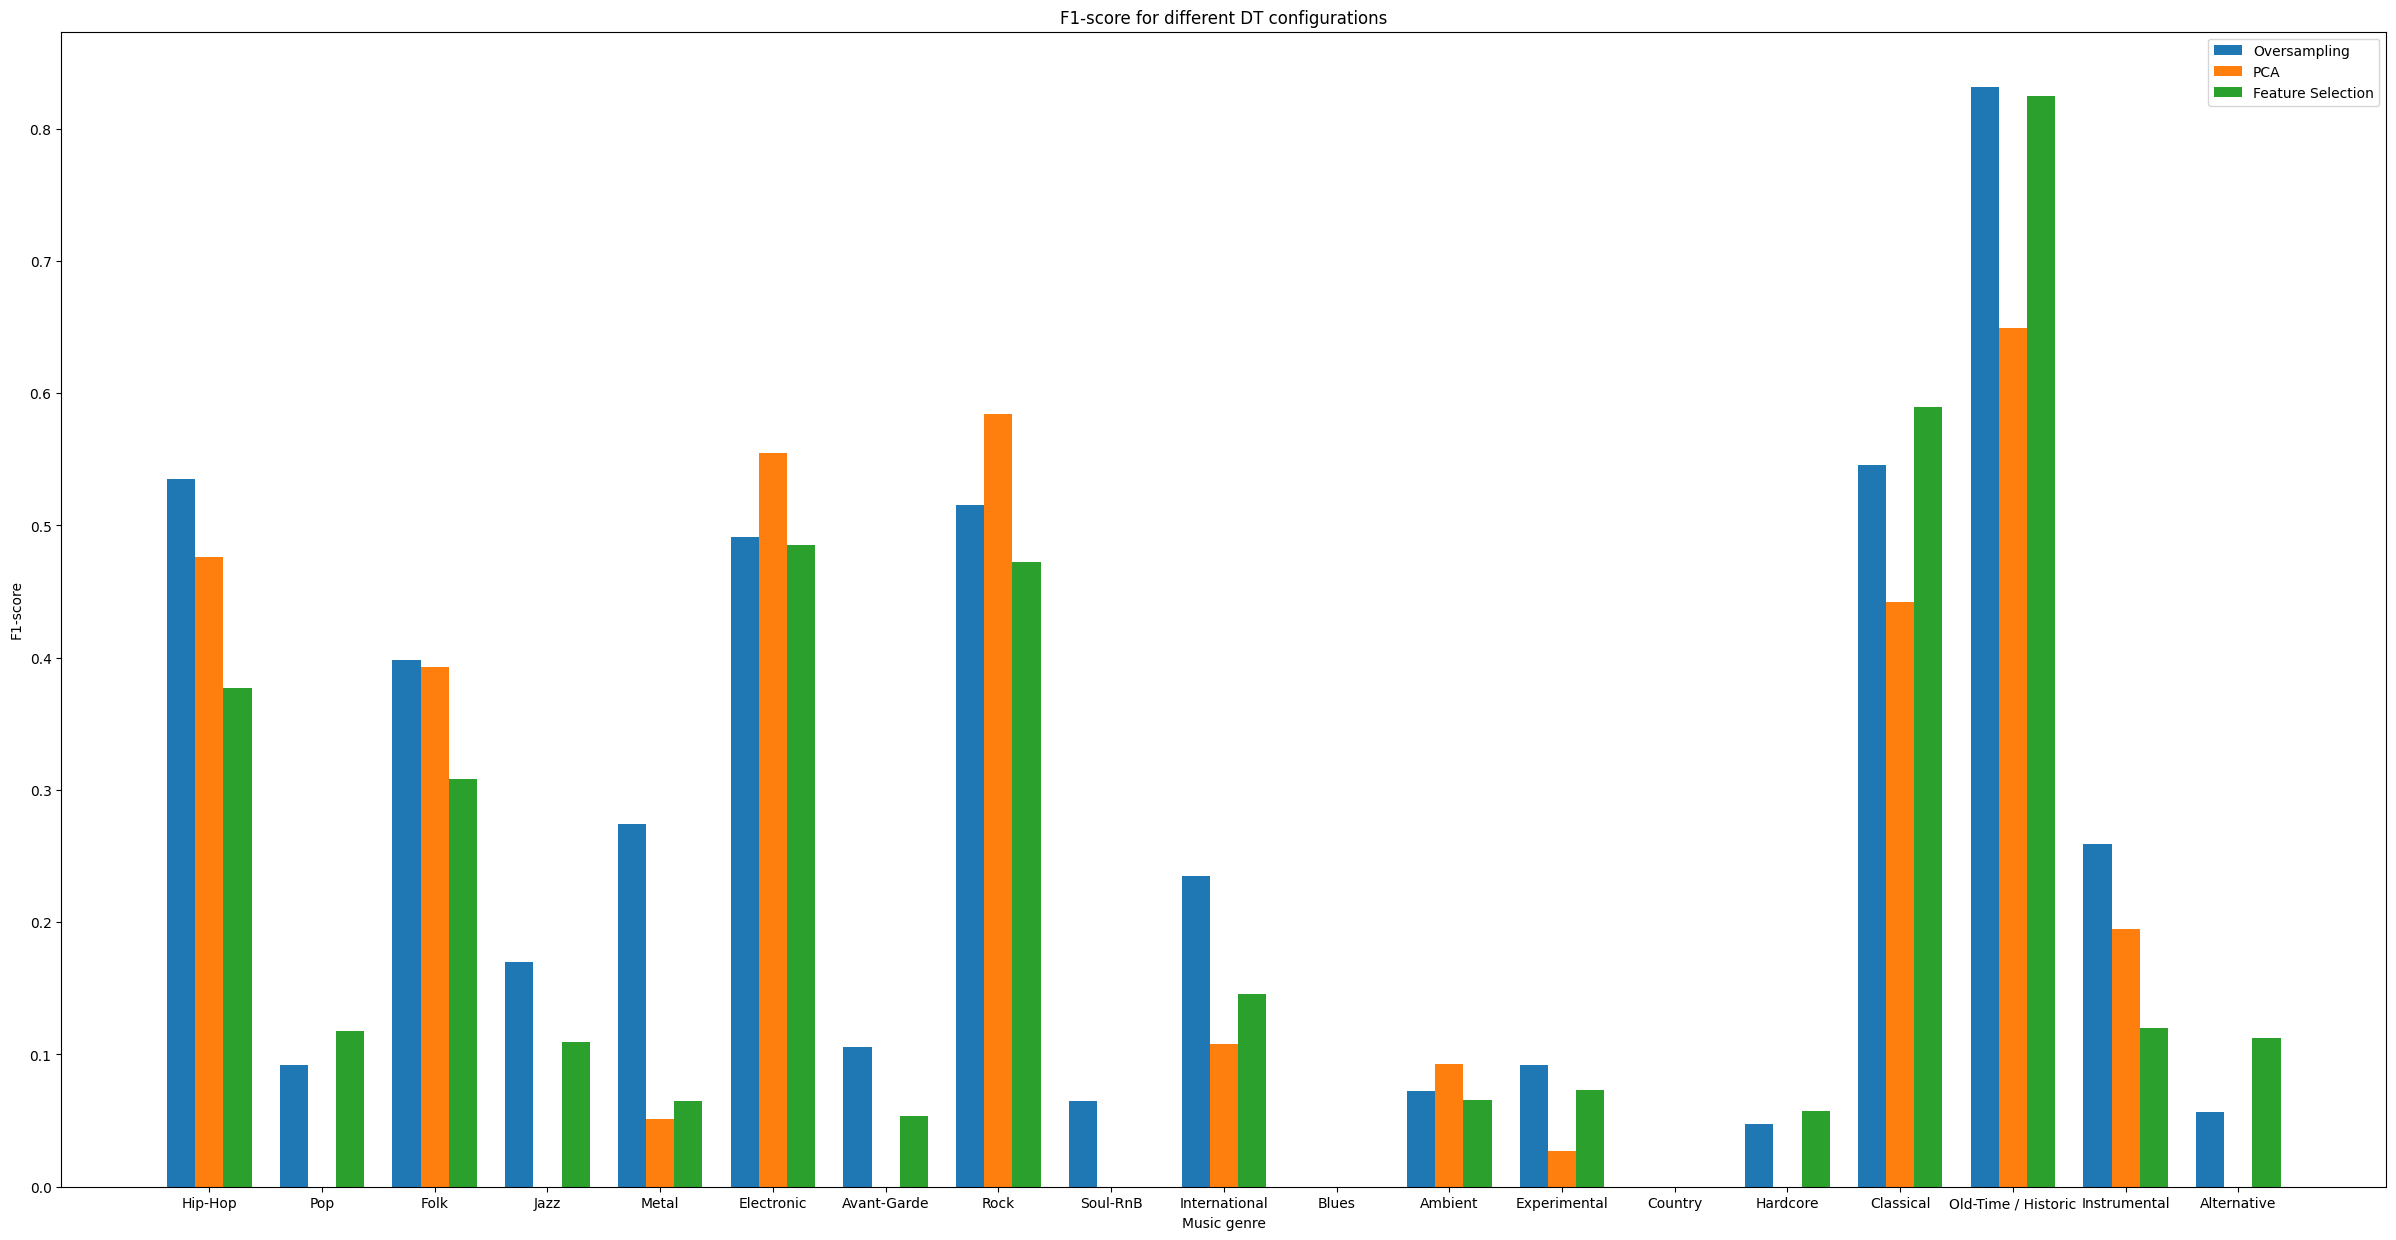

In [73]:
three_group_bar_plot(dt_f1_test, dt_f1_test_pca, dt_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different DT configurations", "Music genre", 
                    "F1-score", ["Oversampling"]+legend_test)

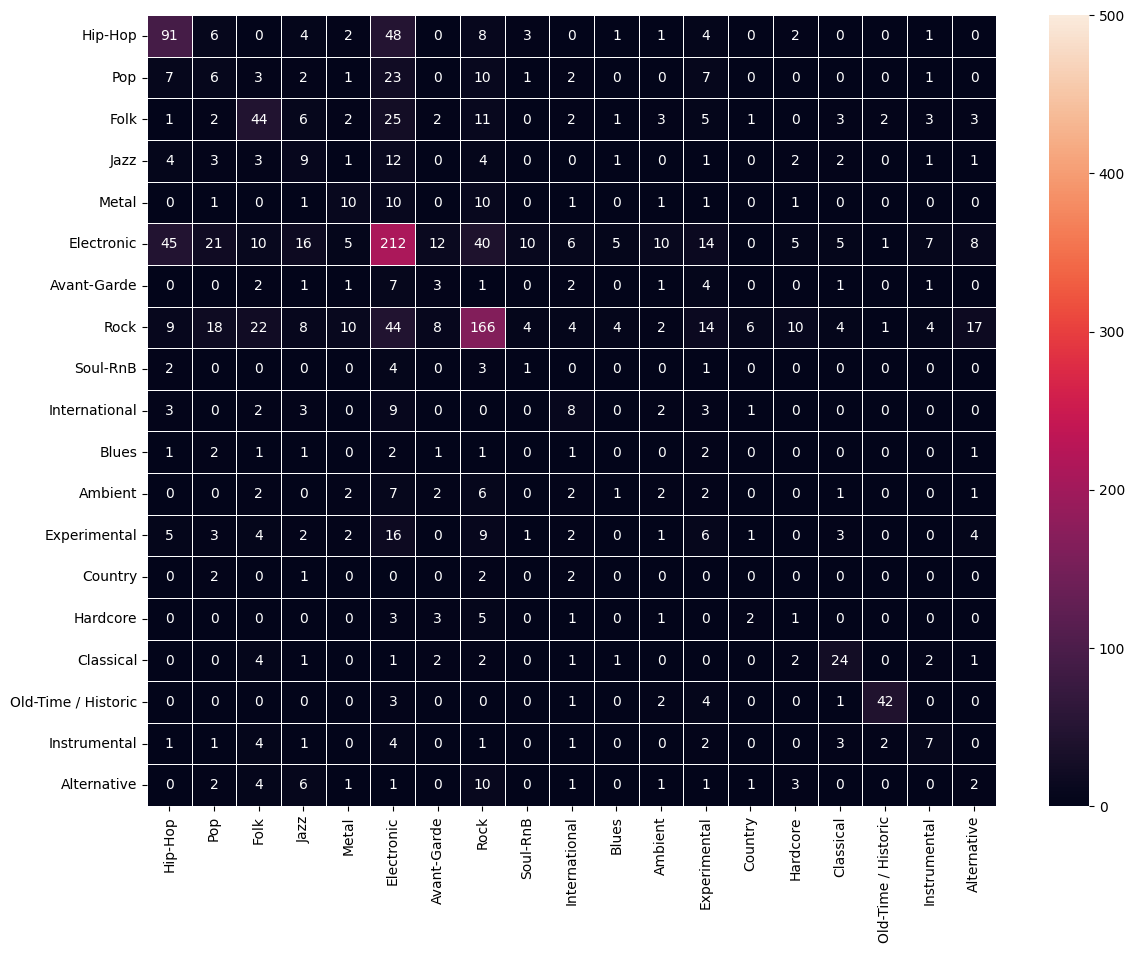

In [76]:
# Confusion matrix
dt_cm_test = confusion_matrix(y_test, dt_test_preds, labels=labels)
print_cm(dt_cm_test, orig_labels, "Confusion matrix for DT")

# Challenge
To conclude the study, there is a little "challenge" among all classifiers considered.
<br>

In particular, a song is opened, loaded, the feature extracted and it is passed to the classifier to see which is the genre predicted.

In [13]:
# Instantiate all the classifiers and fit them
C_best = 20
n_hidden_opt = 70

svm_clf_chall = skl.svm.SVC(C=C_best, kernel='rbf', probability=True).fit(X_train, y_train)
lr_clf_chall = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_train, y_train)
knn_clf_chall = KNeighborsClassifier(10).fit(X_train, y_train)
mlp_clf_chall = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n_hidden_opt,), 
                            random_state=1).fit(X_train, y_train)
dt_clf_chall = DecisionTreeClassifier(min_samples_leaf=70).fit(X_train, y_train).fit(X_train, 
                                                                                     y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


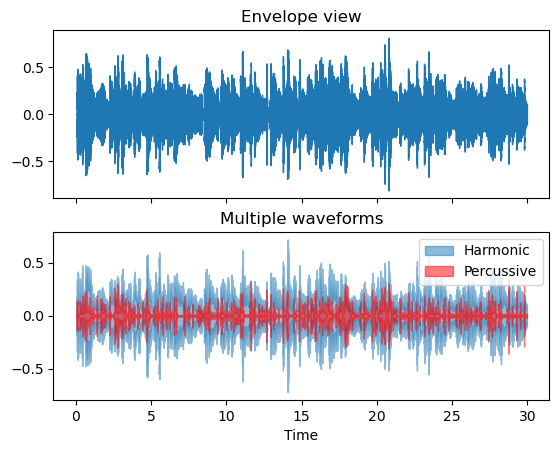

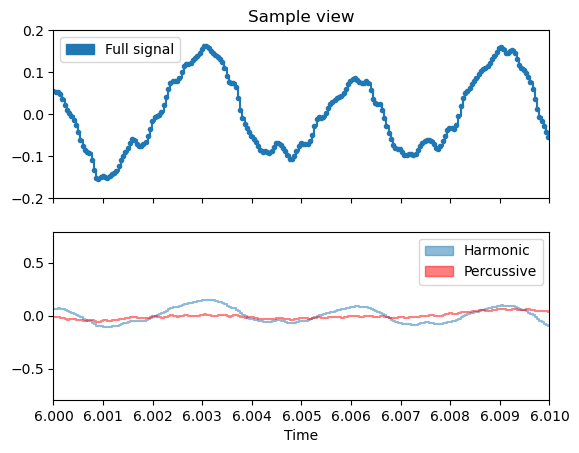

In [37]:
from utils import open_file_dialog
from Dataset_Generator import get_chroma_stft, get_chroma_cens, get_chroma_cqt, get_melspectrogram, get_mfcc, get_poly_features, get_rms, get_spectral_bandwidth, get_spectral_centroid, get_spectral_contrast, get_spectral_flatness, get_spectral_rolloff, get_tempogram, get_tonnetz, get_zero_crossing_rate

# Open dialogue box
file_path = open_file_dialog()
   
metrics = []

y, sr = librosa.load(file_path, offset=0, duration=30)
metrics.extend(calculate_metrics(get_chroma_stft(y, sr)))
metrics.extend(calculate_metrics(get_chroma_cens(y, sr)))
chroma_cqt = get_chroma_cqt(y, sr)
metrics.extend(calculate_metrics(chroma_cqt))
mel = get_melspectrogram(y, sr)
metrics.extend(calculate_metrics(mel))
metrics.extend(calculate_metrics(get_mfcc(y, sr)))
metrics.extend(calculate_metrics(get_poly_features(y, sr)))
metrics.extend(calculate_metrics(get_rms(y)))
metrics.extend(calculate_metrics(get_spectral_bandwidth(y, sr)))
metrics.extend(calculate_metrics(get_spectral_centroid(y, sr)))
metrics.extend(calculate_metrics(get_spectral_contrast(y, sr)))
metrics.extend(calculate_metrics(get_spectral_flatness(y)))
metrics.extend(calculate_metrics(get_spectral_rolloff(y, sr)))
metrics.extend(calculate_metrics(get_tempogram(y, sr)))
tonnetz = get_tonnetz(y, sr)
metrics.extend(calculate_metrics(tonnetz))
metrics.extend(calculate_metrics(get_zero_crossing_rate(y)))

X_test_elem = [metrics]

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view')
ax[0].label_outer()
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[1], label='Percussive')
ax[1].set(title='Multiple waveforms')
ax[1].legend()

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
ax.set(xlim=[6.0, 6.01], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(y, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.label_outer()
ax.legend()
ax2.legend()

Text(0.5, 1.0, 'Stft demonstration')

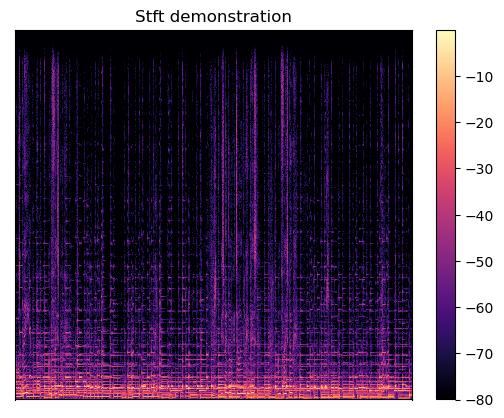

In [38]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()
plt.title('Stft demonstration')

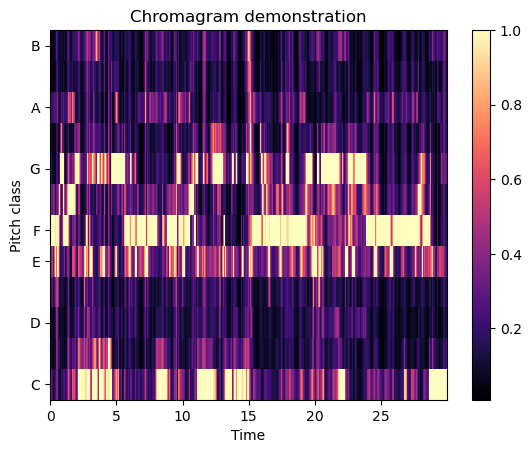

In [39]:
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

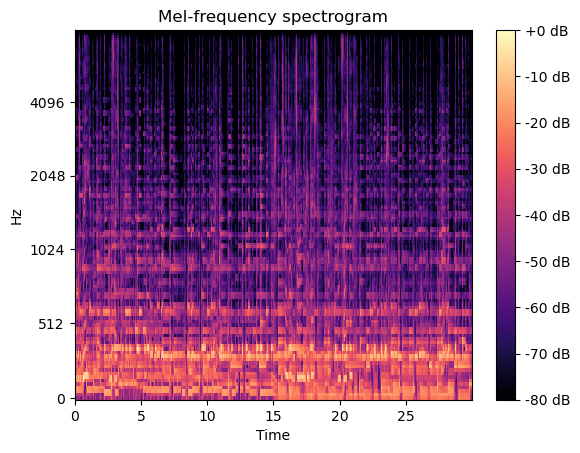

In [40]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Tonal Centroids (Tonnetz)')]

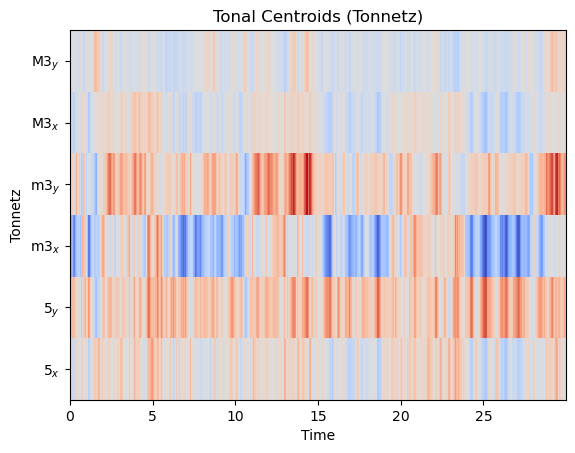

In [41]:
fig, ax = plt.subplots()
img = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax)
ax.set(title='Tonal Centroids (Tonnetz)')

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Convert predicitions to a dictionary of the form `label_name`:value
#
# @param string_labels: list of labels
# @param probs:         list of predicted probabilites
#
# @returns: dictonary
def preds_to_dict(string_labels, probs):
    probs_dict = {}
    for index in range(0, len(string_labels)):
        probs_dict[string_labels[index]] = probs[index]
    return probs_dict

# Get the probability scores for each classifier.
# We are supposing that the X train and y train are just the one element that we are trying
# to classify.
orig_labels = le.inverse_transform(labels) # convert labels back
orig_labels.sort()

svm_probs = svm_clf_chall.predict_proba(X_test_elem)
lr_probs = lr_clf_chall.predict_proba(X_test_elem)
knn_probs = knn_clf_chall.predict_proba(X_test_elem)
mlp_probs = mlp_clf_chall.predict_proba(X_test_elem)
dt_probs = dt_clf_chall.predict_proba(X_test_elem)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


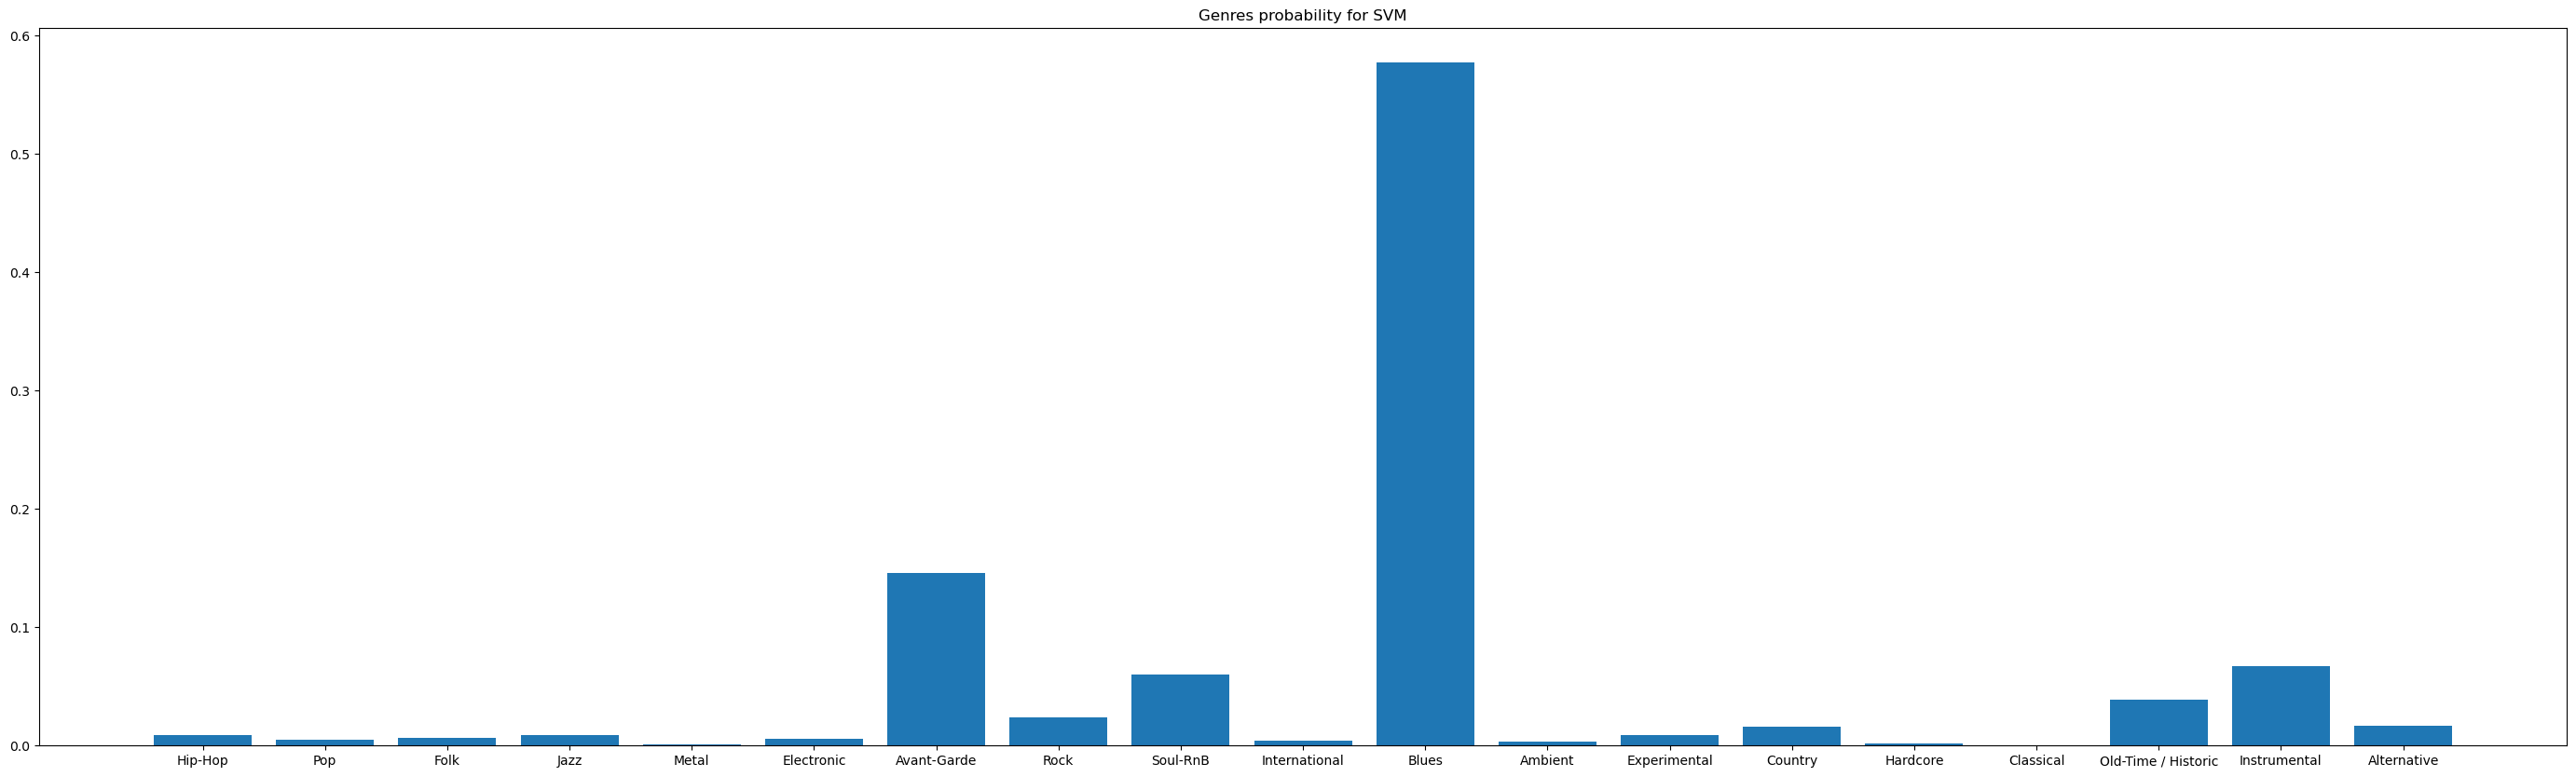

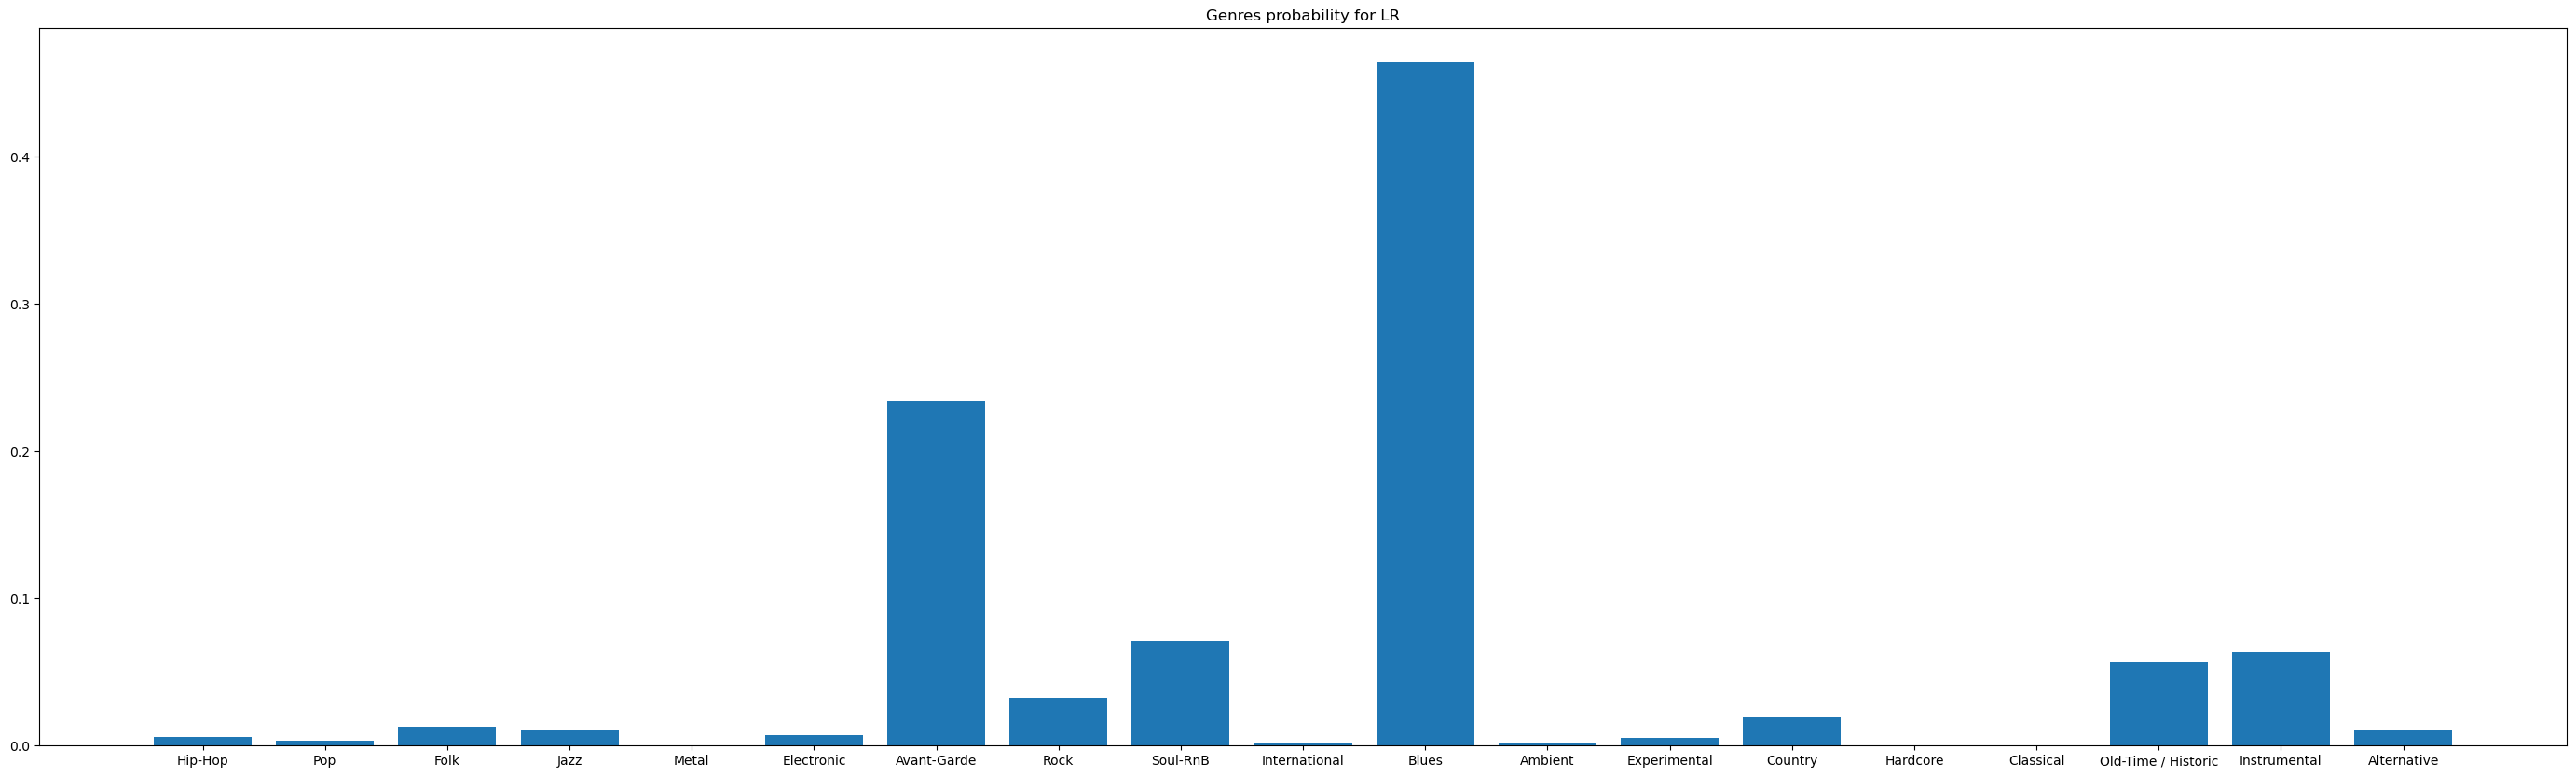

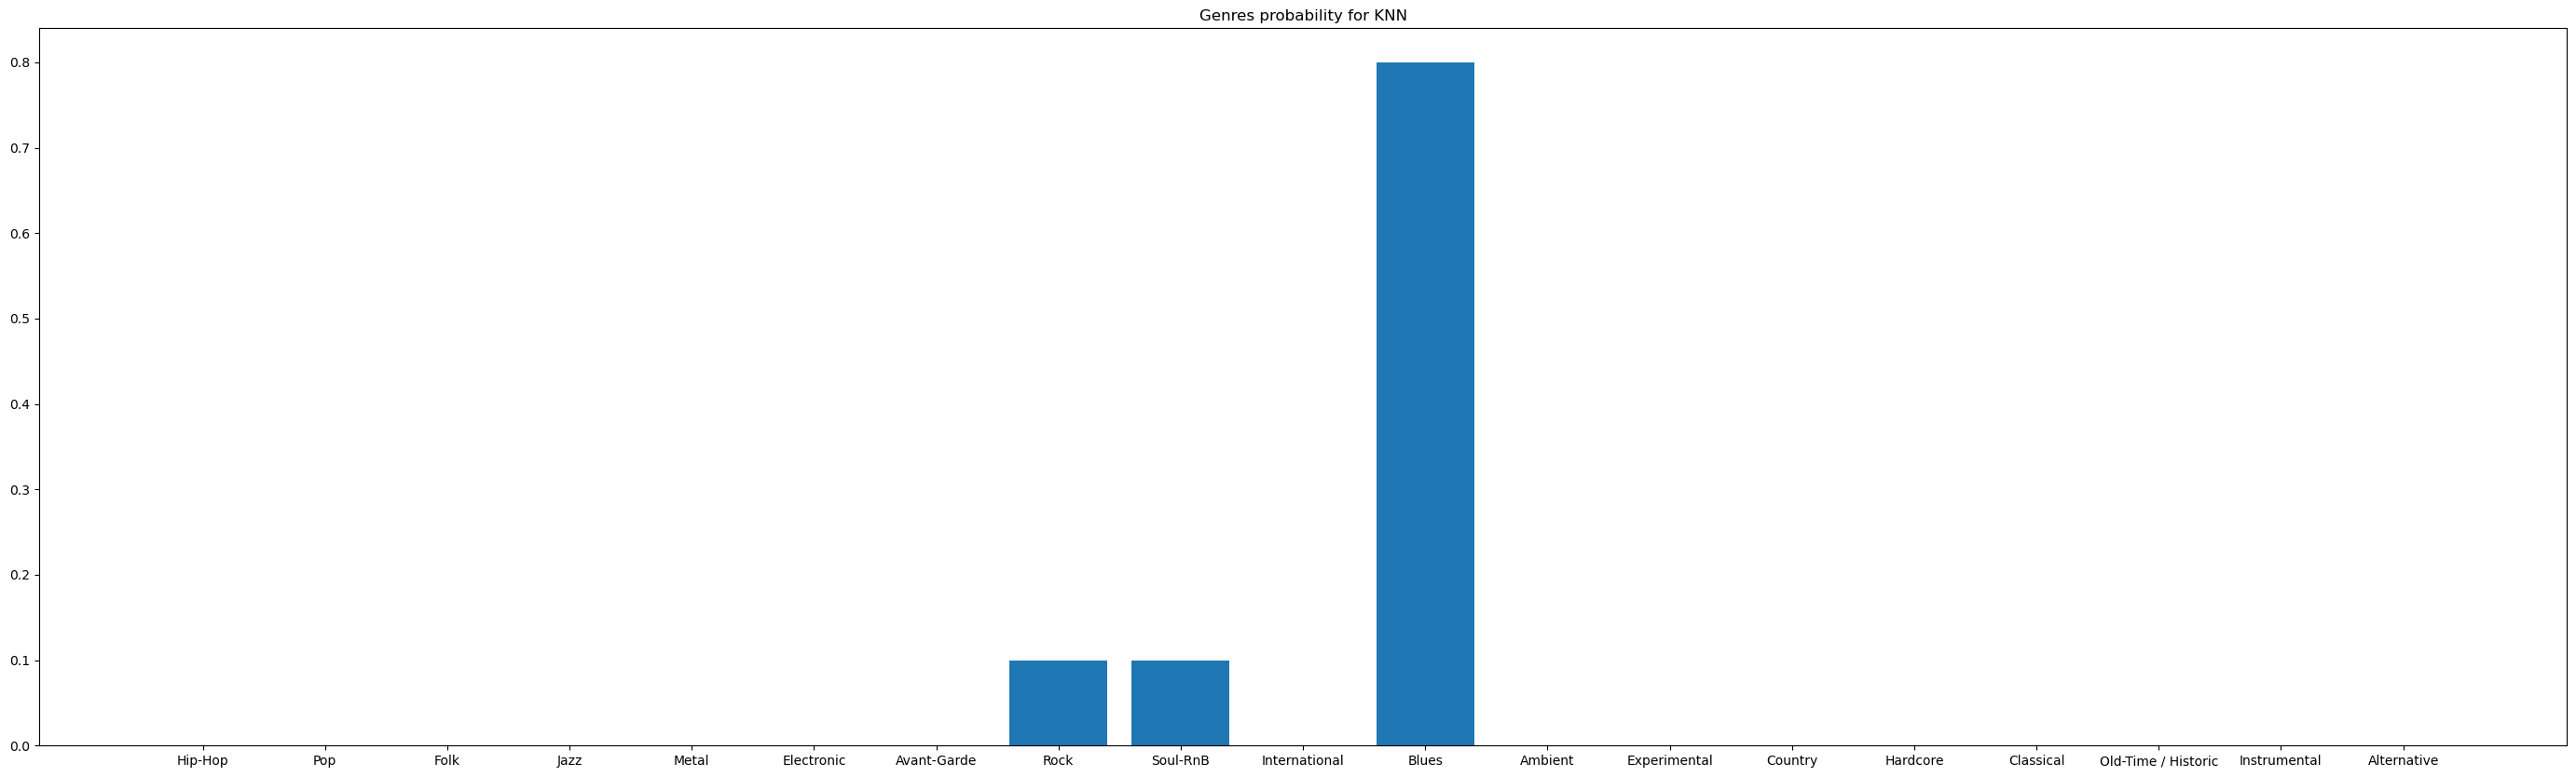

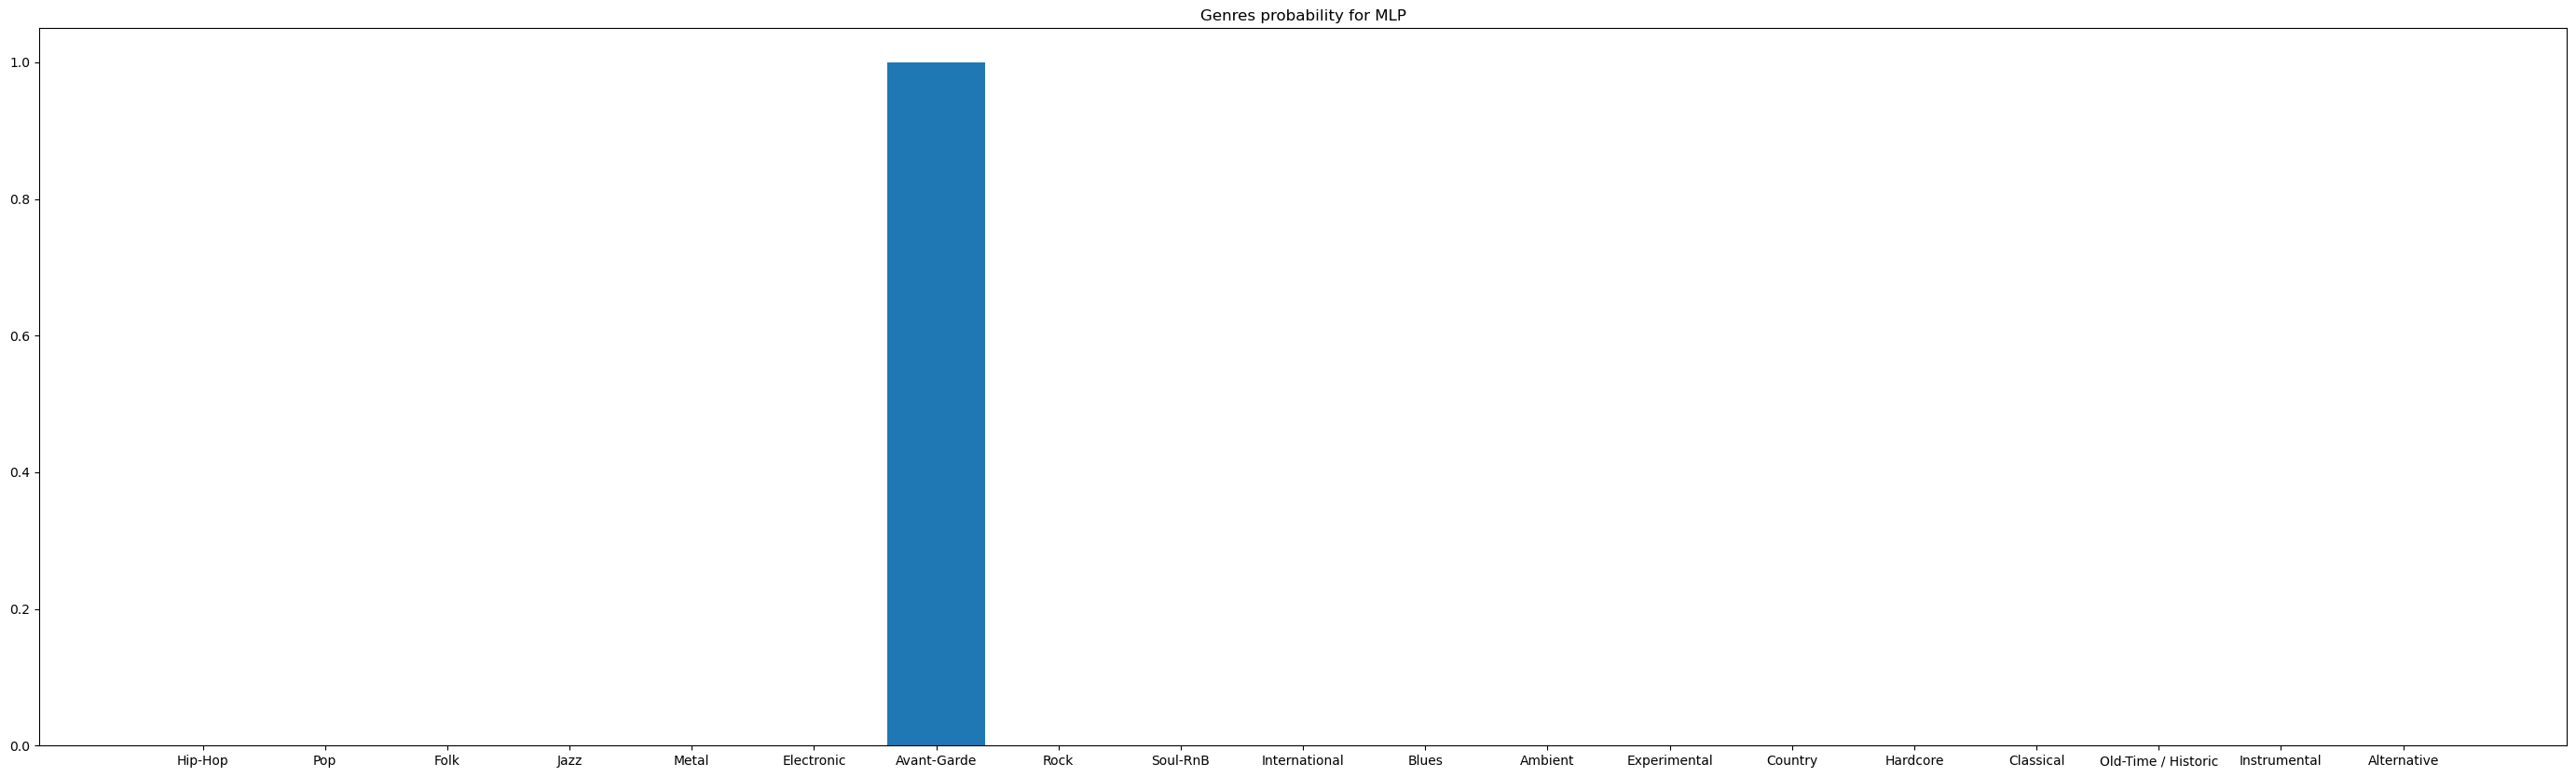

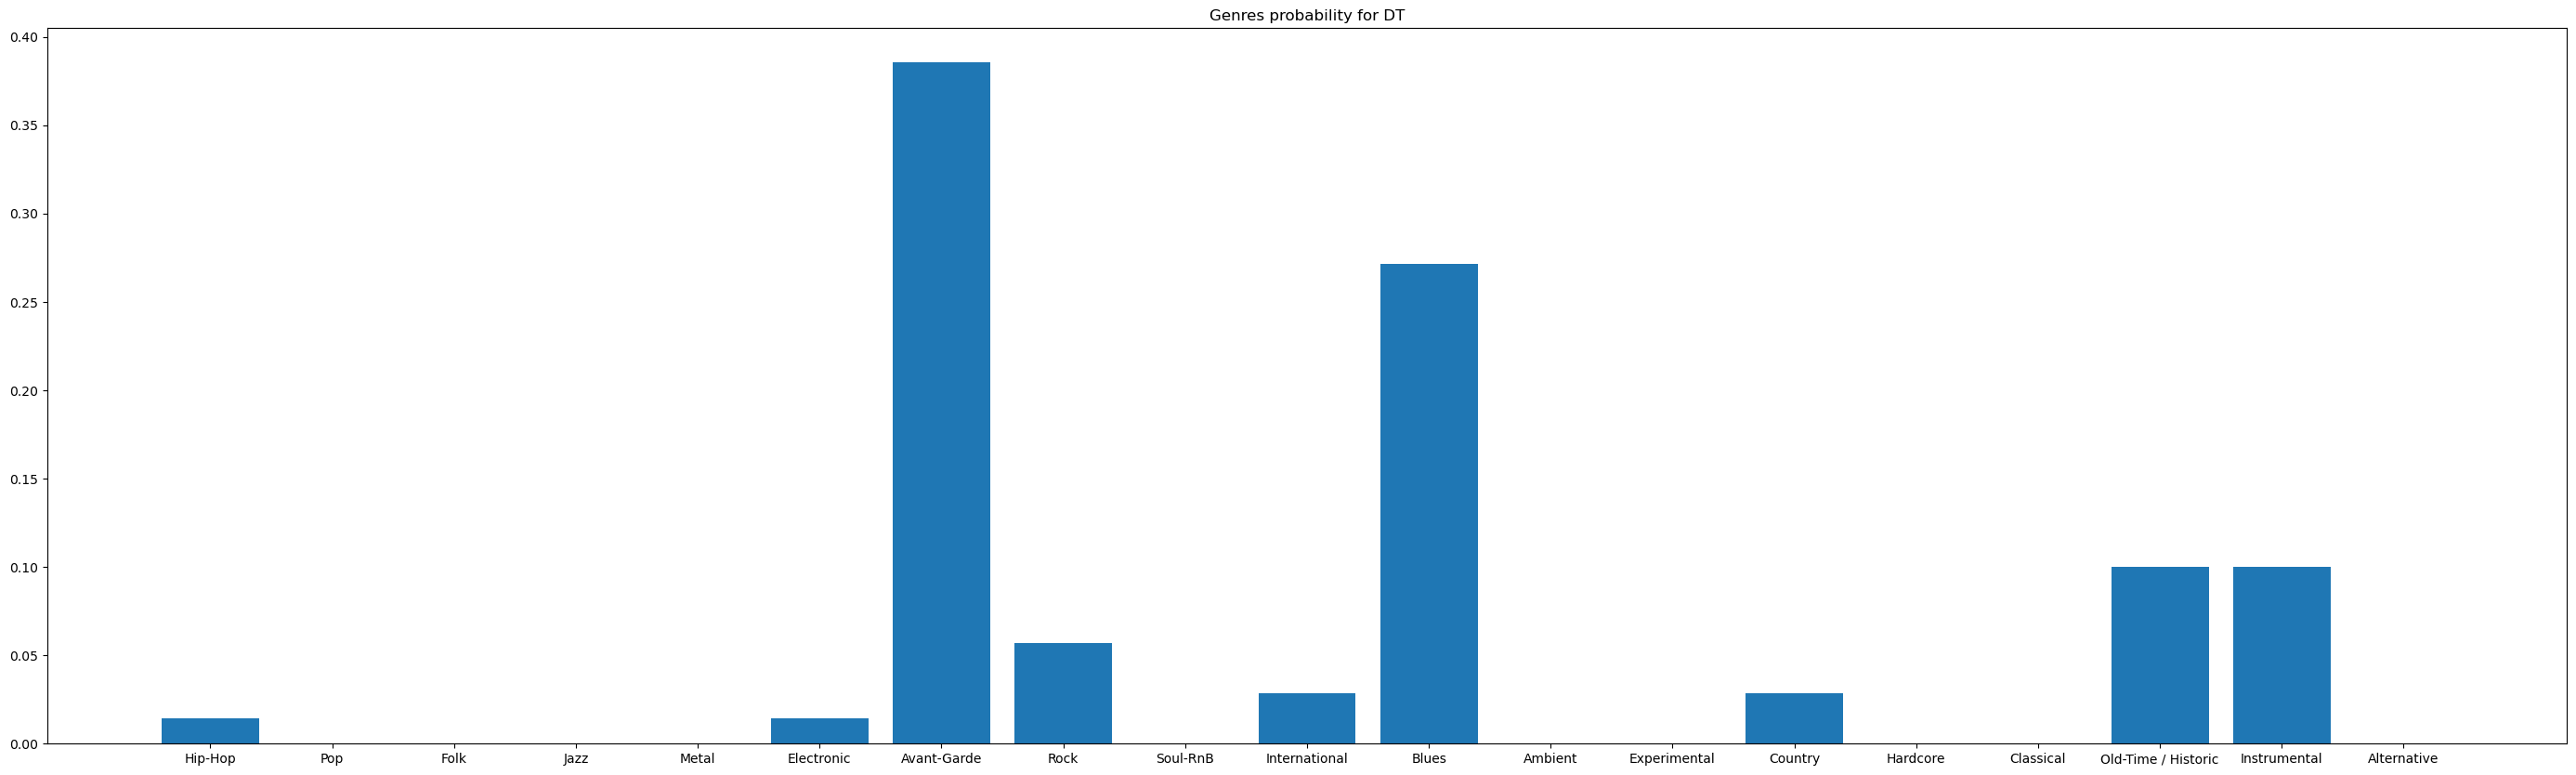

In [22]:
bar_plot((35,10), svm_probs[0], orig_labels, 'Genres probability for SVM')
bar_plot((35,10), lr_probs[0], orig_labels, 'Genres probability for LR')
bar_plot((35,10), knn_probs[0], orig_labels, 'Genres probability for KNN')
bar_plot((35,10), mlp_probs[0], orig_labels, 'Genres probability for MLP')
bar_plot((35,10), dt_probs[0], orig_labels, 'Genres probability for DT')

## Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

## Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)